In [1]:
%matplotlib inline

# Import custom scripts

In [2]:
path_scripts = '/Users/simjoo/Projects/10X_Skin/scripts/'

In [3]:
import sys
sys.path.append(path_scripts)

In [4]:
from Skin10X_misc_scripts_v1_4 import *
from Skin10X_plot_v1_0 import *
from Skin10X_affinity_propagation_v1_4 import *
from Skin10X_mann_whitney_u_v1_3 import *

/Users/simjoo/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
import pickle

# Initialize engines

In [6]:
from ipyparallel import Client

In [7]:
c = Client(profile='default')

In [8]:
dview = c[:]

In [9]:
dview.execute('import sys')
dview.execute('sys.path.append("/Users/simjoo/Projects/10X_Skin/scripts/")')
dview.execute('from Skin10X_affinity_propagation_v1_4 import *')
dview.execute('Skin10X_mann_whitney_u_v1_4 import *')

<AsyncResult: execute>

# Import Data

In [10]:
exp_id = '201806201840'
path_input = '/Users/simjoo/Projects/10X_Skin/data_input/v1.5/'
path_output = '/Users/simjoo/Projects/10X_Skin/data_output/v1.5'
path_figures = '/Users/simjoo/Projects/10X_Skin/figures/v1.5'

In [11]:
seq = loadData_v1(path_output, exp_id, 'seq', 'DataFrame')

In [12]:
seqN = loadData_v1(path_output, exp_id, 'seqN', 'DataFrame')

In [13]:
seqN_log2 = np.log2(seqN + 1)

In [14]:
cl_c_1st = loadData_v1(path_output, exp_id, 'cl_c_1st', 'Series')

In [15]:
cl_c_2nd = loadData_v1(path_output, exp_id, 'cl_c_2nd', 'Series')

In [16]:
cl_c_ANA = cl_c_2nd[[ix for ix in cl_c_2nd.index if cl_c_2nd[ix].split()[0] == 'ANA']]

In [17]:
cl_c_ANA = AP_invert_index(cl_c_ANA, 'ANA - 21')
#cl_c_ANA = AP_invert_index(cl_c_ANA, 'ANA - 11')

In [18]:
cl_c_ANA_IRS = loadData_v1(path_output, exp_id, 'cl_c_ANA_IRS', 'Series')

In [19]:
tsne_1st = loadData_v1(path_output, exp_id, 'tsne_1st', 'DataFrame')

In [20]:
umap_ANA = loadData_v1(path_output, exp_id, 'umap_ANA', 'DataFrame')

In [21]:
umap_ANA_IRS = loadData_v1(path_output, exp_id, 'umap_ANA_IRS', 'DataFrame')

In [22]:
MWU_av_ANA = loadData_v1(path_output, exp_id, 'MWU_av_ANA', 'DataFrame')
MWU_gr_ANA = loadData_v1(path_output, exp_id, 'MWU_gr_ANA', 'DataFrame')

In [23]:
MWU_av_ANA_IRS = loadData_v1(path_output, exp_id, 'MWU_av_ANA_IRS', 'DataFrame')
MWU_gr_ANA_IRS = loadData_v1(path_output, exp_id, 'MWU_gr_ANA_IRS', 'DataFrame')

In [24]:
cc_score = loadData_v1(path_output, exp_id, 'cc_score','DataFrame')
cc_score.index = [ix.replace('.','-') for ix in cc_score.index]

In [25]:
cc_score_v2 = loadData_v1(path_output, exp_id, 'cc_score_v2','Series')

In [26]:
cells_stage = pd.Series([c[-2:] for c in seq.columns], index = seq.columns)

In [27]:
bc = loadData_v1(path_input, exp_id, 'assigned_barcodes', 'Series')
cells_replicate = pd.Series(index = seq.columns)
for ix in cells_replicate.index:
    if type(bc['%s-1' % ix[:-3]]) != str:
        cells_replicate[ix] = '%s unassigned' % ix.split('-')[-1]
    elif bc['%s-1' % ix[:-3]] == 'unassigned':
        cells_replicate[ix] = '%s unassigned' % ix.split('-')[-1]
    else:
        cells_replicate[ix] = bc['%s-1' % ix[:-3]]

In [28]:
path = '%s/%s_cmap_1st.pkl' % (path_output, exp_id)
f = open(path, 'rb')
cmap_1st = pickle.load(f)

In [29]:
path = '%s/%s_cmap_2nd.pkl' % (path_output, exp_id)
f = open(path, 'rb')
cmap_2nd = pickle.load(f)

In [30]:
cmap_time = {'5w':'#fb9a99','9w':'#b2df8a'}

In [31]:
markers_time = {'5w':'o','9w':'o'}

# t-SNE - cell selection

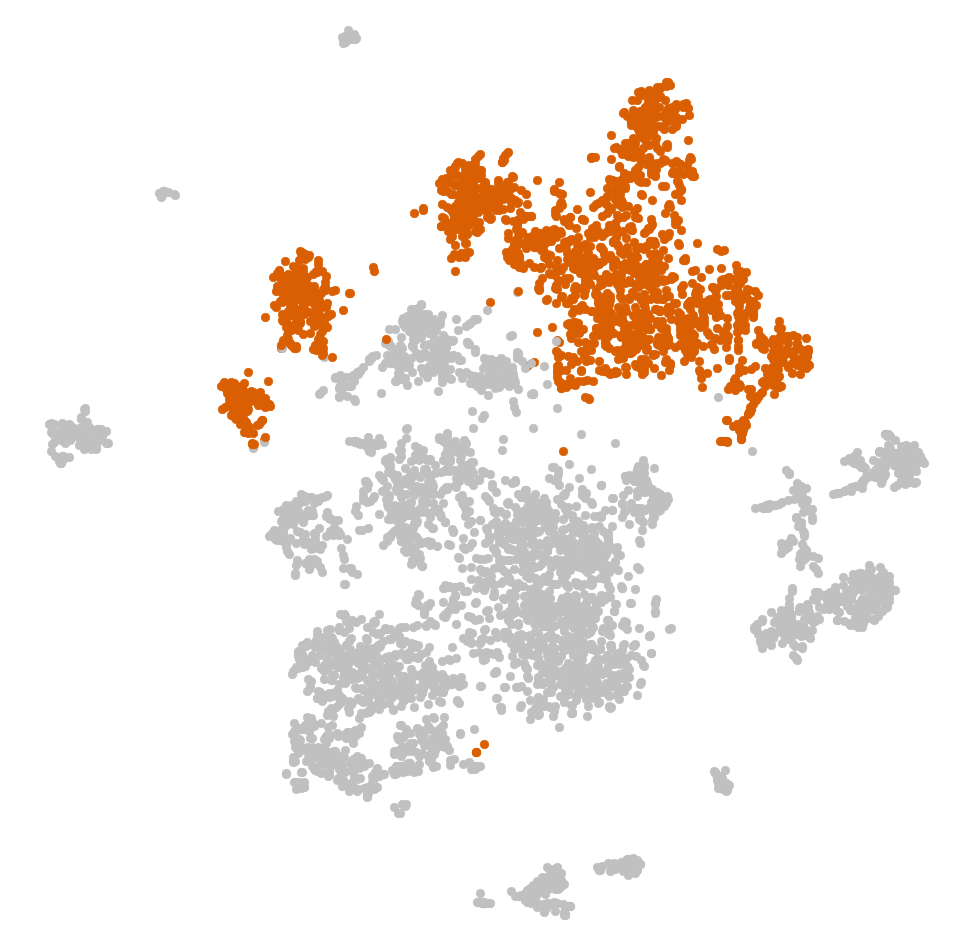

In [32]:
cells = cl_c_1st[cl_c_1st!='JUNK']
tsne = tsne_1st.loc[cells.index]
cmap = cmap_1st
time = cells_stage
markers = markers_time

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(tsne['x']), np.max(tsne['x'])
y_min, y_max = np.min(tsne['y']), np.max(tsne['y'])
x_diff, y_diff = x_max - x_min, y_max - y_min

pad = 2.0

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_min * (x_diff / y_diff) - pad, y_max * (x_diff / y_diff) + pad)

if x_diff < y_diff:
    xlim = (x_min * (y_diff/x_diff) - pad, x_max * (y_diff/x_diff) + pad)
    ylim = (y_min - pad, y_max + pad)

text_pad = 2
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

remove_ticks(ax1)

index = list(tsne.index)
np.random.shuffle(index)

for ix in index:
    
    if cells[ix] != 'ANA':
        ax1.scatter(tsne.loc[ix,'x'],
                    tsne.loc[ix,'y'], 
                    s = 75,
                    linewidth = 0.5,
                    c = 'silver',
                    edgecolor='silver', 
                    marker = markers[time[ix]])
        
    else:
        ax1.scatter(tsne.loc[ix,'x'],
                    tsne.loc[ix,'y'], 
                    s = 75,
                    linewidth = 0.5,
                    c = cmap_1st['ANA'],
                    edgecolor=cmap_1st['ANA'], 
                    marker = markers[time[ix]])

clean_axis(ax1)

figname = 'v1.5_Fig3_tSNE_ANA_sel.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

# UMAP - cell groups

In [33]:
cl_c_ANA_comp = pd.Series('Matrix', index = cl_c_ANA.index)

for c in cl_c_ANA[cl_c_ANA.isin(['ANA - 0','ANA - 1','ANA - 21'])].index: cl_c_ANA_comp[c] = 'uORS'
for c in cl_c_ANA[cl_c_ANA.isin(['ANA - 2','ANA - 3','ANA - 20'])].index: cl_c_ANA_comp[c] = 'lORS'

In [34]:
Counter(cl_c_ANA_comp)

Counter({'uORS': 115, 'lORS': 220, 'Matrix': 1639})

In [35]:
cmap_ANA_com = {'uORS':'#1b9e77','lORS':'#7570b3','Matrix':'#d95f02'}

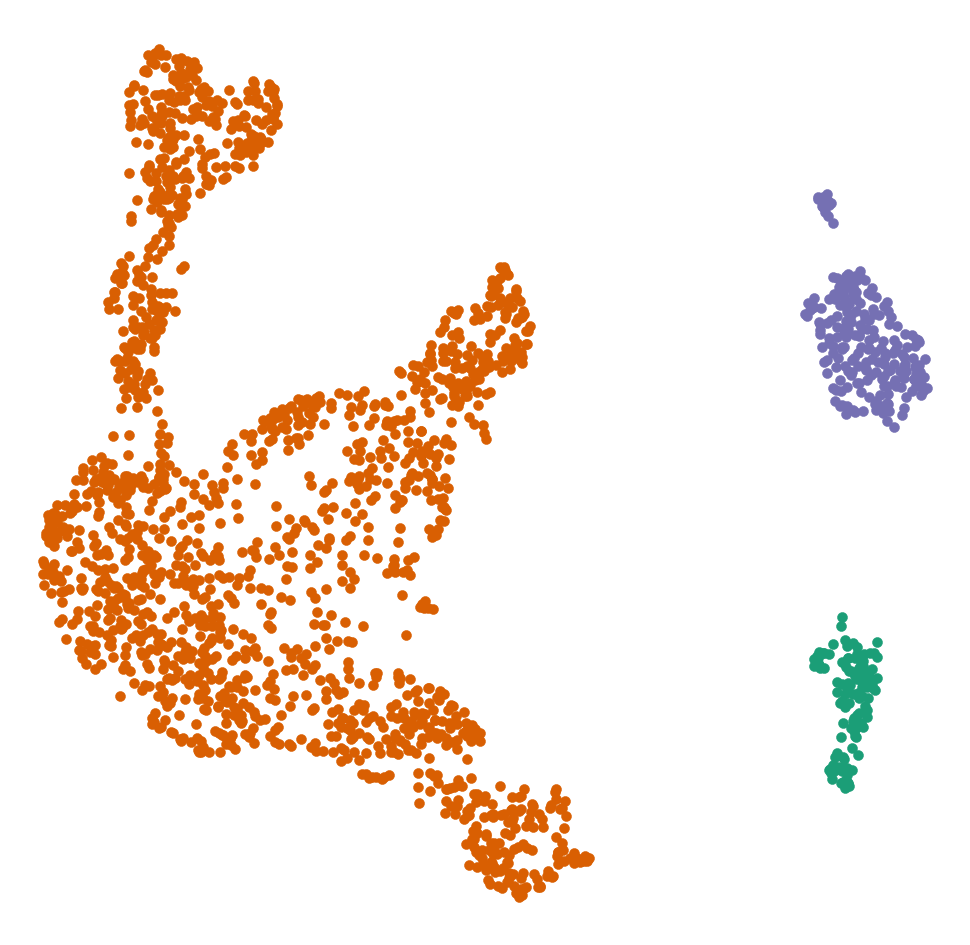

In [36]:
cells = cl_c_ANA_comp
tsne = umap_ANA.loc[cells.index]
cmap = cmap_ANA_com
time = cells_stage
markers = markers_time

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(tsne['x']), np.max(tsne['x'])
y_min, y_max = np.min(tsne['y']), np.max(tsne['y'])
x_diff, y_diff = x_max - x_min, y_max - y_min

pad = 2.0

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_min * (x_diff / y_diff) - pad, y_max * (x_diff / y_diff) + pad)

if x_diff < y_diff:
    xlim = (x_min * (y_diff/x_diff) - pad, x_max * (y_diff/x_diff) + pad)
    ylim = (y_min - pad, y_max + pad)

text_pad = 2
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

remove_ticks(ax1)

index = list(tsne.index)
np.random.shuffle(index)

for ix in index:

    ax1.scatter(tsne.loc[ix,'x'],
                tsne.loc[ix,'y'], 
                s = 100,
                linewidth = 0.5,
                c = cmap[cells[ix]],
                edgecolor=cmap[cells[ix]], 
                marker = markers[time[ix]])

clean_axis(ax1)

figname = 'v1.5_Fig3_tSNE_ANA_comp.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

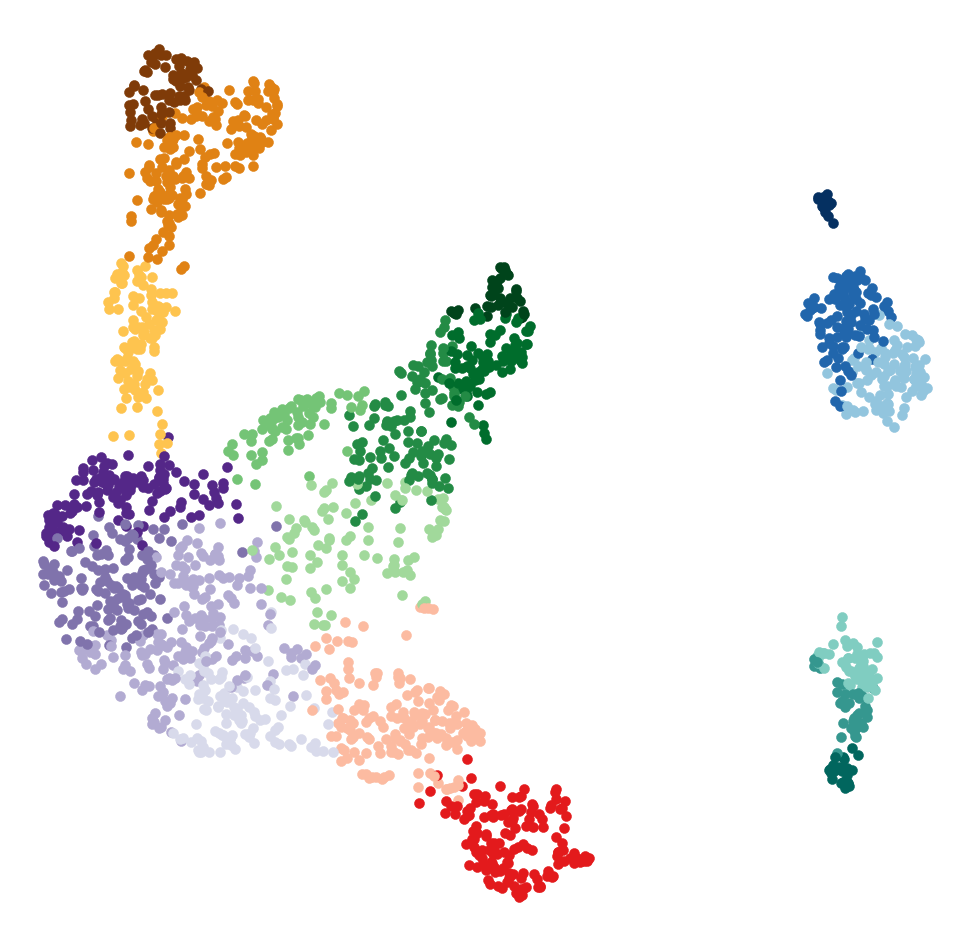

In [45]:
cells = cl_c_ANA
tsne = umap_ANA.loc[cells.index]
cmap = cmap_2nd
time = cells_stage
markers = markers_time

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(tsne['x']), np.max(tsne['x'])
y_min, y_max = np.min(tsne['y']), np.max(tsne['y'])
x_diff, y_diff = x_max - x_min, y_max - y_min

pad = 2.0

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_min * (x_diff / y_diff) - pad, y_max * (x_diff / y_diff) + pad)

if x_diff < y_diff:
    xlim = (x_min * (y_diff/x_diff) - pad, x_max * (y_diff/x_diff) + pad)
    ylim = (y_min - pad, y_max + pad)

text_pad = 2
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

remove_ticks(ax1)

index = list(tsne.index)
np.random.shuffle(index)

for ix in index:

    ax1.scatter(tsne.loc[ix,'x'],
                tsne.loc[ix,'y'], 
                s = 100,
                linewidth = 0.5,
                c = cmap[cells[ix]],
                edgecolor=cmap[cells[ix]], 
                marker = markers[time[ix]])

clean_axis(ax1)

figname = 'v1.5_Fig3_tSNE_ANA.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

# UMAP - Msx2 expression

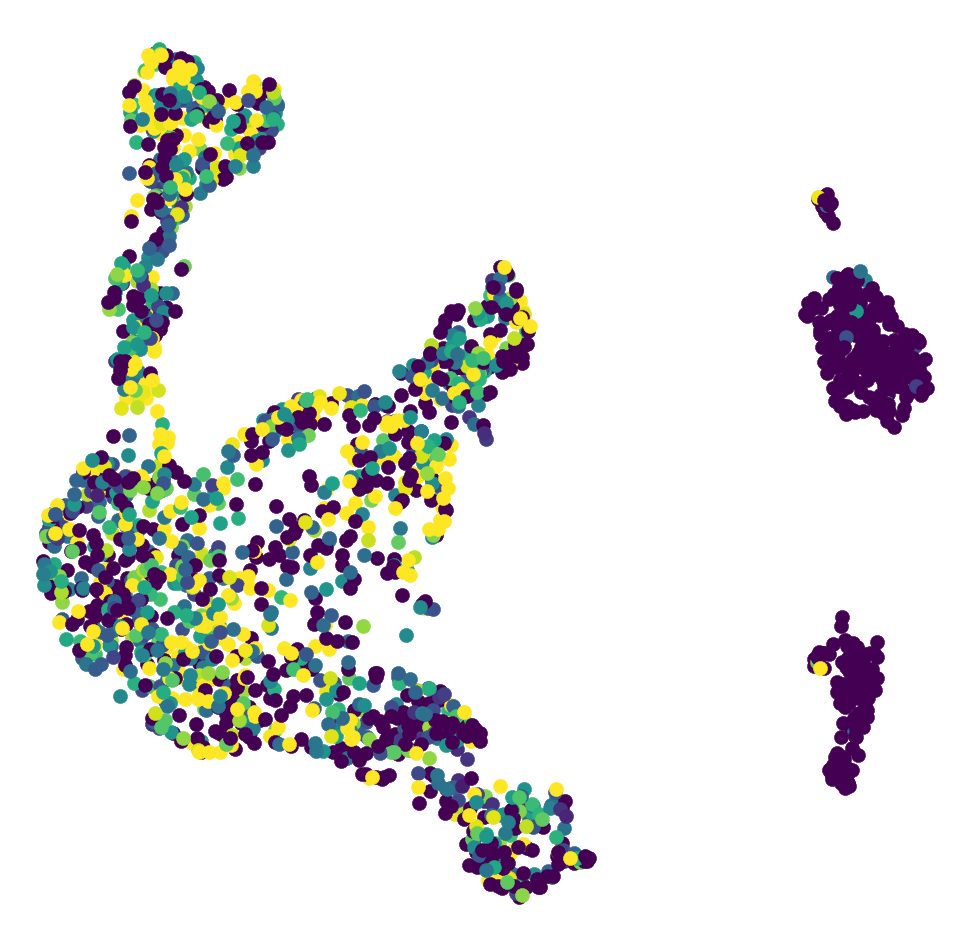

In [37]:
cells = cl_c_ANA
tsne = umap_ANA.loc[cells.index]
expr = seqN.loc['Msx2',cells.index]
vmin = 0
vmax = 2
expr = (expr - vmin) / (vmax - vmin)
cmap = plt.cm.viridis
time = cells_stage
markers = markers_time

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(tsne['x']), np.max(tsne['x'])
y_min, y_max = np.min(tsne['y']), np.max(tsne['y'])
x_diff, y_diff = x_max - x_min, y_max - y_min

pad = 2.0

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_min * (x_diff / y_diff) - pad, y_max * (x_diff / y_diff) + pad)

if x_diff < y_diff:
    xlim = (x_min * (y_diff/x_diff) - pad, x_max * (y_diff/x_diff) + pad)
    ylim = (y_min - pad, y_max + pad)

text_pad = 2
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

remove_ticks(ax1)

index = list(tsne.index)
np.random.shuffle(index)

for ix in index:

    ax1.scatter(tsne.loc[ix,'x'],
                tsne.loc[ix,'y'], 
                s = 200,
                linewidth = 0.5,
                c = cmap(expr[ix]),
                edgecolor=cmap(expr[ix]), 
                marker = markers[time[ix]])

clean_axis(ax1)

figname = 'v1.5_Fig3_tSNE_Msx2.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

# UMAP - Barx2 expression

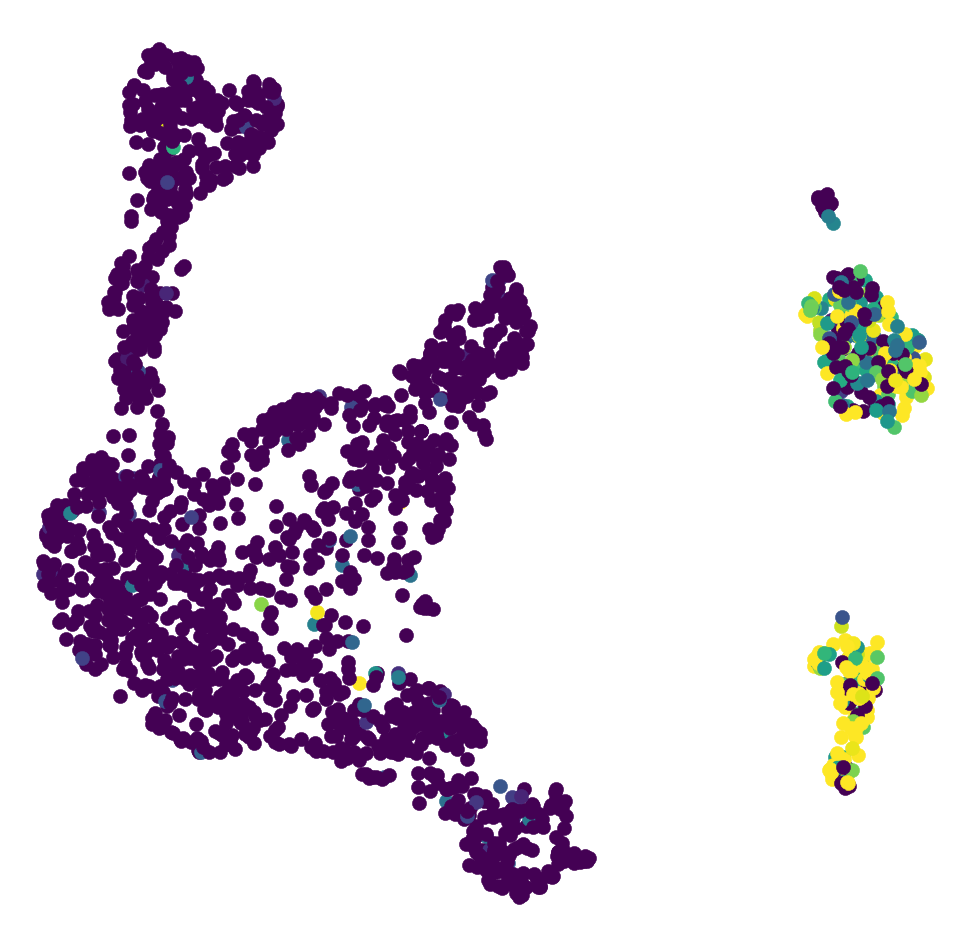

In [38]:
cells = cl_c_ANA
tsne = umap_ANA.loc[cells.index]
expr = seqN.loc['Barx2',cells.index]
vmin = 0
vmax = 3
expr = (expr - vmin) / (vmax - vmin)
cmap = plt.cm.viridis
time = cells_stage
markers = markers_time

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(tsne['x']), np.max(tsne['x'])
y_min, y_max = np.min(tsne['y']), np.max(tsne['y'])
x_diff, y_diff = x_max - x_min, y_max - y_min

pad = 2.0

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_min * (x_diff / y_diff) - pad, y_max * (x_diff / y_diff) + pad)

if x_diff < y_diff:
    xlim = (x_min * (y_diff/x_diff) - pad, x_max * (y_diff/x_diff) + pad)
    ylim = (y_min - pad, y_max + pad)

text_pad = 2
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

remove_ticks(ax1)

index = list(tsne.index)
np.random.shuffle(index)

for ix in index:

    ax1.scatter(tsne.loc[ix,'x'],
                tsne.loc[ix,'y'], 
                s = 200,
                linewidth = 0.5,
                c = cmap(expr[ix]),
                edgecolor=cmap(expr[ix]), 
                marker = markers[time[ix]])

clean_axis(ax1)

figname = 'v1.5_Fig3_tSNE_Barx2.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

# UMAP - Il11ra1 expression

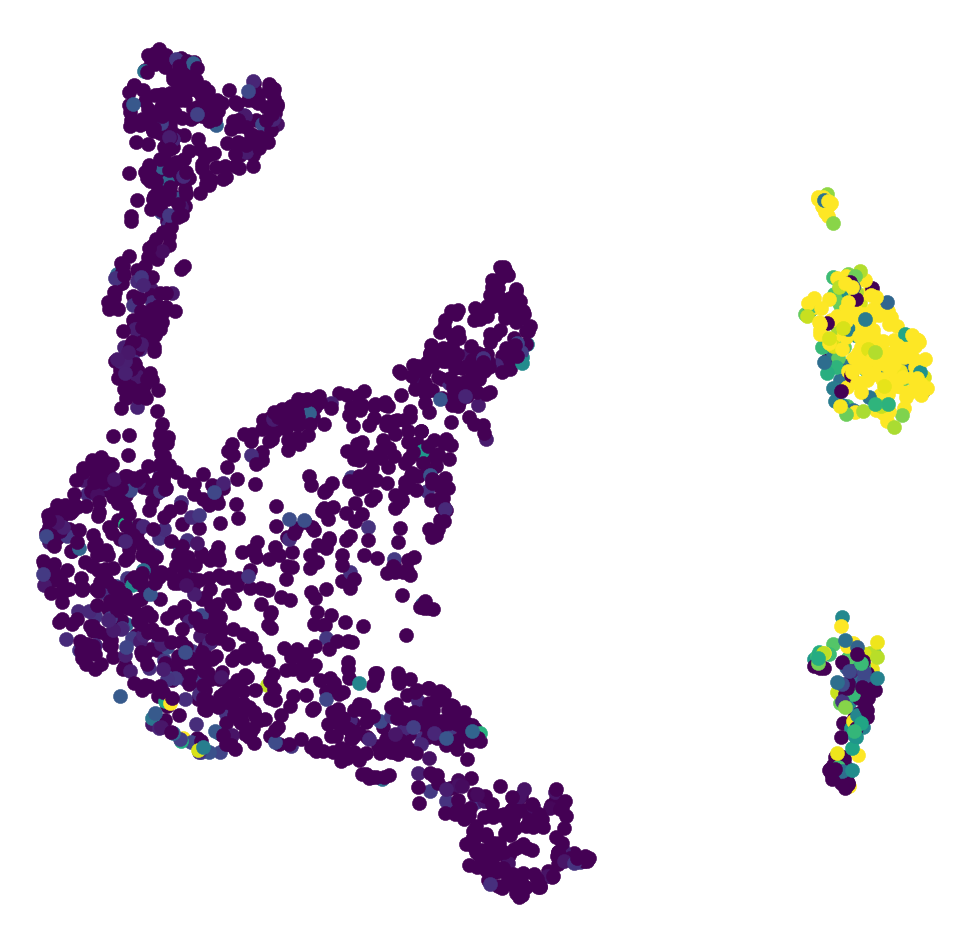

In [41]:
cells = cl_c_ANA
tsne = umap_ANA.loc[cells.index]
expr = seqN.loc['Il11ra1',cells.index]
vmin = 0
vmax = 5
expr = (expr - vmin) / (vmax - vmin)
cmap = plt.cm.viridis
time = cells_stage
markers = markers_time

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(tsne['x']), np.max(tsne['x'])
y_min, y_max = np.min(tsne['y']), np.max(tsne['y'])
x_diff, y_diff = x_max - x_min, y_max - y_min

pad = 2.0

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_min * (x_diff / y_diff) - pad, y_max * (x_diff / y_diff) + pad)

if x_diff < y_diff:
    xlim = (x_min * (y_diff/x_diff) - pad, x_max * (y_diff/x_diff) + pad)
    ylim = (y_min - pad, y_max + pad)

text_pad = 2
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

remove_ticks(ax1)

index = list(tsne.index)
np.random.shuffle(index)

for ix in index:

    ax1.scatter(tsne.loc[ix,'x'],
                tsne.loc[ix,'y'], 
                s = 200,
                linewidth = 0.5,
                c = cmap(expr[ix]),
                edgecolor=cmap(expr[ix]), 
                marker = markers[time[ix]])

clean_axis(ax1)

figname = 'v1.5_Fig3_tSNE_Il11ra1.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

# UMAP - ORS selection

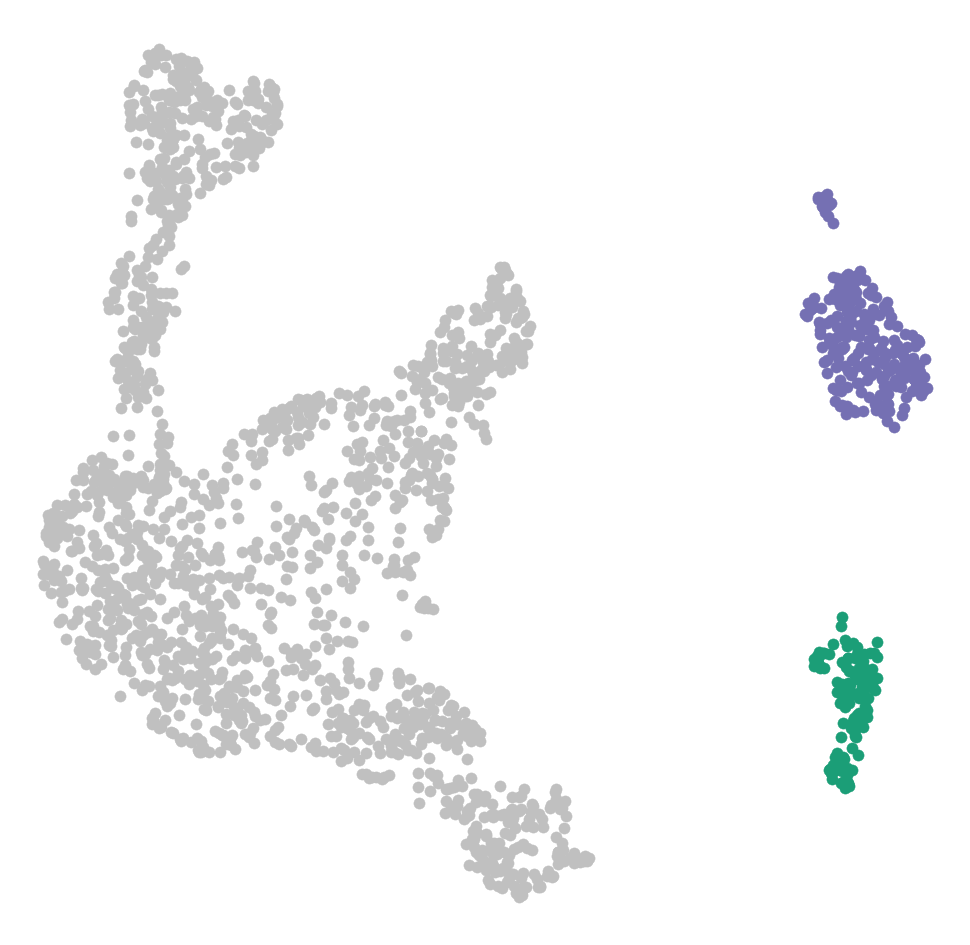

In [45]:
cells = cl_c_ANA_comp
tsne = umap_ANA.loc[cells.index]
cmap = cmap_ANA_com
time = cells_stage
markers = markers_time

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(tsne['x']), np.max(tsne['x'])
y_min, y_max = np.min(tsne['y']), np.max(tsne['y'])
x_diff, y_diff = x_max - x_min, y_max - y_min

pad = 2.0

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_min * (x_diff / y_diff) - pad, y_max * (x_diff / y_diff) + pad)

if x_diff < y_diff:
    xlim = (x_min * (y_diff/x_diff) - pad, x_max * (y_diff/x_diff) + pad)
    ylim = (y_min - pad, y_max + pad)

text_pad = 2
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

remove_ticks(ax1)

index = list(tsne.index)
np.random.shuffle(index)

for ix in index:
    
    if cells[ix] not in ['uORS','lORS']:
        ax1.scatter(tsne.loc[ix,'x'],
                    tsne.loc[ix,'y'], 
                    s = 125,
                    linewidth = 0.5,
                    c = 'silver',
                    edgecolor='silver', 
                    marker = markers[time[ix]])
        
    else:
        ax1.scatter(tsne.loc[ix,'x'],
                    tsne.loc[ix,'y'], 
                    s = 125,
                    linewidth = 0.5,
                    c = cmap[cells[ix]],
                    edgecolor=cmap[cells[ix]], 
                    marker = markers[time[ix]])

clean_axis(ax1)

figname = 'v1.5_Fig3_tSNE_ANA_ORS_sel.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

# UMAP - matrix selection

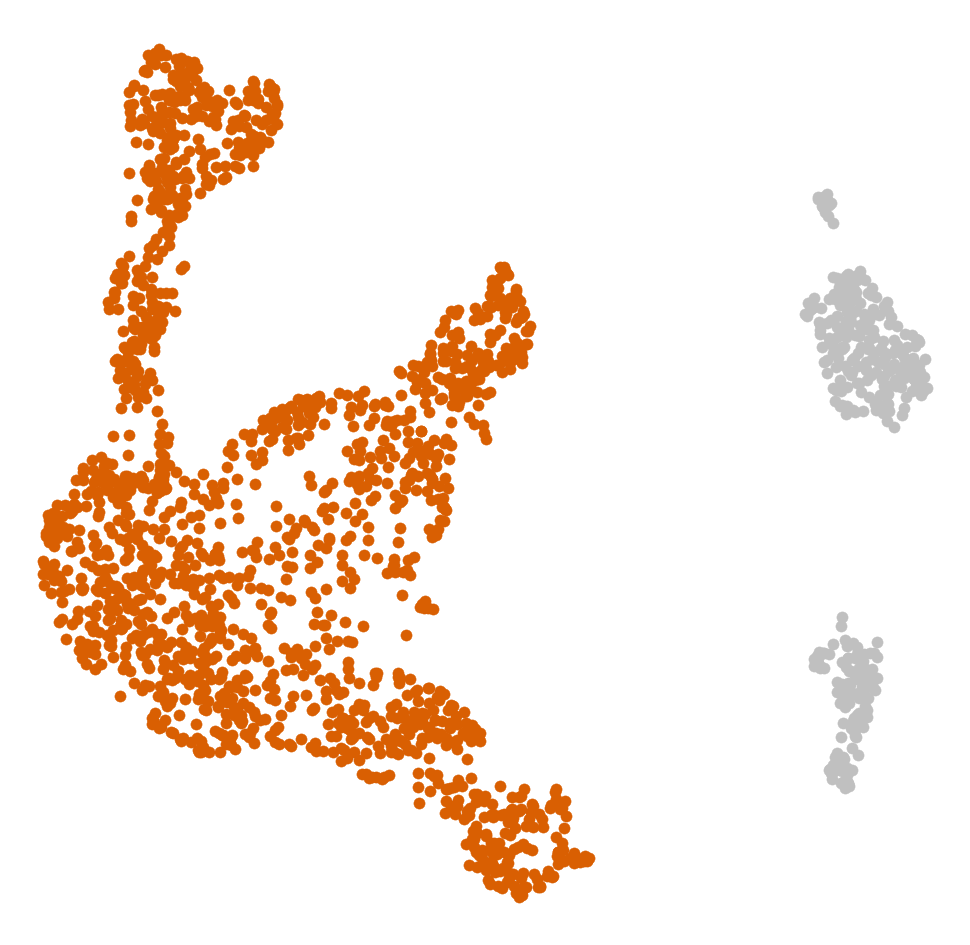

In [64]:
cells = cl_c_ANA_comp
tsne = umap_ANA.loc[cells.index]
cmap = cmap_ANA_com
time = cells_stage
markers = markers_time

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(tsne['x']), np.max(tsne['x'])
y_min, y_max = np.min(tsne['y']), np.max(tsne['y'])
x_diff, y_diff = x_max - x_min, y_max - y_min

pad = 2.0

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_min * (x_diff / y_diff) - pad, y_max * (x_diff / y_diff) + pad)

if x_diff < y_diff:
    xlim = (x_min * (y_diff/x_diff) - pad, x_max * (y_diff/x_diff) + pad)
    ylim = (y_min - pad, y_max + pad)

text_pad = 2
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

remove_ticks(ax1)

index = list(tsne.index)
np.random.shuffle(index)

for ix in index:
    
    if cells[ix] not in ['Matrix']:
        ax1.scatter(tsne.loc[ix,'x'],
                    tsne.loc[ix,'y'], 
                    s = 125,
                    linewidth = 0.5,
                    c = 'silver',
                    edgecolor='silver', 
                    marker = markers[time[ix]])
        
    else:
        ax1.scatter(tsne.loc[ix,'x'],
                    tsne.loc[ix,'y'], 
                    s = 125,
                    linewidth = 0.5,
                    c = cmap[cells[ix]],
                    edgecolor=cmap[cells[ix]], 
                    marker = markers[time[ix]])

clean_axis(ax1)

figname = 'v1.5_Fig3_tSNE_ANA_matrix_sel.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

# UMAP - ORS subclusters

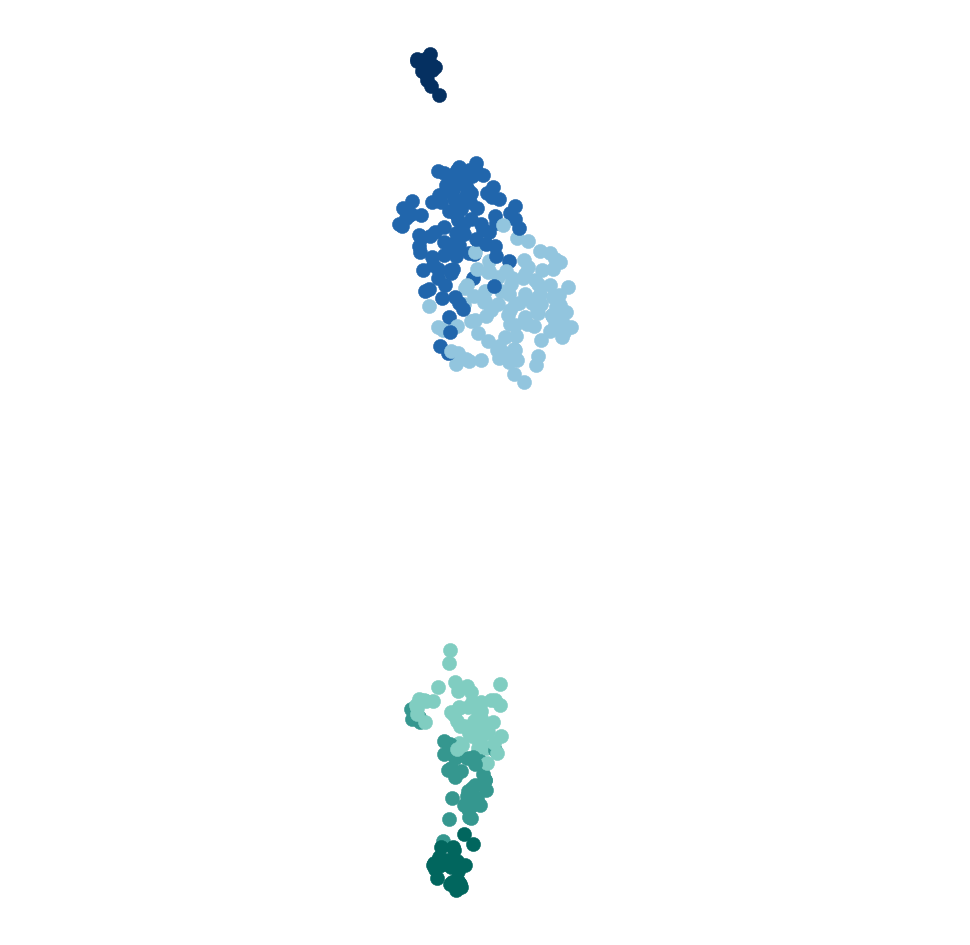

In [32]:
cells = cl_c_ANA[cl_c_ANA.isin(['ANA - 0','ANA - 1','ANA - 2','ANA - 3','ANA - 20','ANA - 21'])]
tsne = umap_ANA.loc[cells.index]
cmap = cmap_2nd
time = cells_stage
markers = markers_time

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(tsne['x']), np.max(tsne['x'])
y_min, y_max = np.min(tsne['y']), np.max(tsne['y'])
x_diff, y_diff = x_max - x_min, y_max - y_min
x_cent, y_cent = x_min + 0.5 * x_diff, y_min + 0.5 * y_diff,

pad = 2.0

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_cent - 0.5 * x_diff - pad, y_cent + 0.5 * x_diff + pad,)

if x_diff < y_diff:
    xlim = (x_cent - 0.5 * y_diff - pad, x_cent + 0.5 * y_diff + pad,)
    ylim = (y_min - pad, y_max + pad)

text_pad = 2
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

index = list(tsne.index)
np.random.shuffle(index)

for ix in index:

    ax1.scatter(tsne.loc[ix,'x'],
                tsne.loc[ix,'y'], 
                s = 200,
                linewidth = 0.5,
                c = cmap[cells[ix]],
                edgecolor=cmap[cells[ix]], 
                marker = markers[time[ix]])

clean_axis(ax1)

figname = 'v1.5_Fig3_tSNE_ANA_ORS.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

# upper ORS

In [34]:
def get_cluster_ticks(cl):

    ticks = []
    cnt = 0
    
    for i in return_unique(cl):
        l = Counter(cl)[i]
        ticks += [cnt + l / 2]
        cnt += l
        
    return ticks

In [53]:
genes = ['Barx2','Krt5','Krt14','Pthlh','Wfdc18','Krt6a','Apoe','Cst6','Krt79']

/Users/simjoo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:43: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/Users/simjoo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:79: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


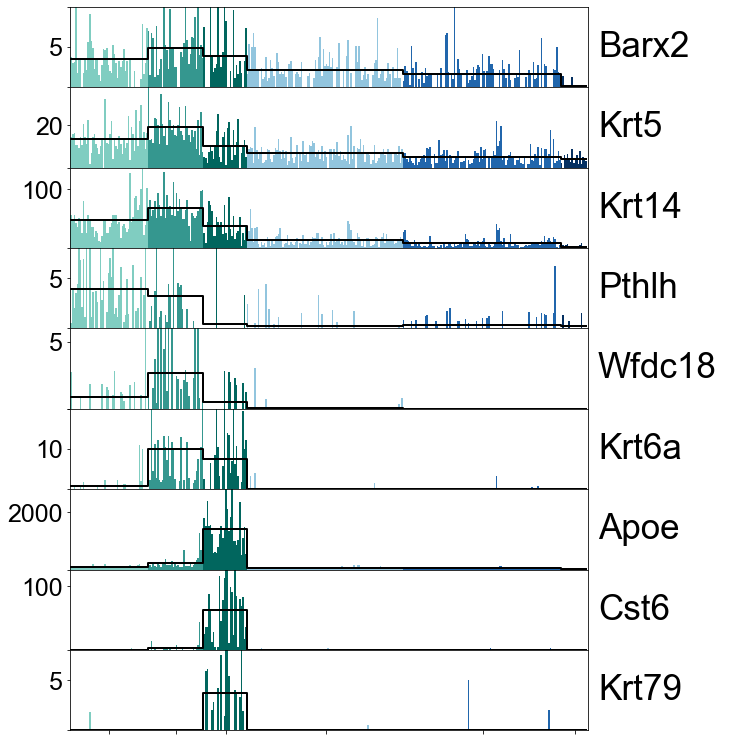

In [54]:
cells = cl_c_ANA
groups_sel = ['ANA - 0','ANA - 1', 'ANA - 21','ANA - 2','ANA - 3','ANA - 20']
cell_groups = cells[cells.isin(groups_sel)]
cell_ngroups = cells[~cells.isin(groups_sel)]
dataset = seqN[cell_groups.index]
#genes = ['Anxa2']
cmap = cmap_2nd

#create figure

bar_size = 0.5
bar_pad = 0.25
width = 10
height = len(genes) * 1.2

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#create GS for gene barplots

gs1 = plt.GridSpec(len(genes), 2, hspace = 0.00, wspace = 0.0, top = 1 - ((bar_pad + bar_size) / height), right = 1, 
                   left = (bar_pad + bar_size) / width, bottom = 0, width_ratios = [14,4])

#create GS for sample group bar

gs0 = plt.GridSpec(1,2, left = (bar_pad + bar_size) / width, right = 1, top = 1,
                       bottom = 1 - ((bar_size) / height), hspace = 0.0, wspace = 0.0, width_ratios = [14,4])

#colorlist bar

clistBAR = [cmap[val] for val in cell_groups]

#draw genes

for g in genes:
    
        #create group_specific mean expressions
    
        mean_tmp = pd.Series(index = set(cell_groups))
        
        for gr in set(cell_groups):
            
            ix_tmp = cell_groups[cell_groups == gr].index
            mean_tmp[gr] = dataset.ix[g, ix_tmp].mean()
            
        #create white space for gene names
        
        ax0 = plt.subplot(gs1[genes.index(g),1])
        clean_axis(ax0)
 
        #create axis
            
        ax0 = plt.subplot(gs1[genes.index(g),0])
        
        ax0.axvspan(0, len(dataset.columns), color = '#FFFFFF', zorder = 0)
        
        #define xaxis
        
        ax0.set_xlim(left = 0, right = (len(dataset.columns)))
        ax0.xaxis.set_ticks(get_cluster_ticks(cell_groups))
        ax0.xaxis.set_ticklabels([])
        
        #define yaxis
        
        ax0.set_ylim(bottom = 0, top = np.ceil(np.max(mean_tmp) * 2))
        ax0.set_ylabel(g, family = 'Arial', fontsize = 35, rotation = 'horizontal', va = 'center', ha = 'left')
        ax0.yaxis.set_label_coords(1.02, 0.5)
        
        ax0.locator_params(axis='y', nbins=2)
        
        for tick_pos, tick in enumerate(ax0.yaxis.get_major_ticks()):
            if tick_pos % 2 == 1:
                ax0.yaxis.get_major_ticks()[tick_pos].label.set_family('Arial')
                ax0.yaxis.get_major_ticks()[tick_pos].label.set_fontsize(25)
            else:
                ax0.yaxis.get_major_ticks()[tick_pos].label.set_visible(False)
                
        #draw expression data
        
        ax0.bar(np.arange(0, len(dataset.columns),1), dataset.ix[g], color = clistBAR, linewidth = 0, width = 1.0)
        
        #draw means
        
        ax0.step(range(len(cell_groups)), [mean_tmp[val] for val in cell_groups], where = 'mid', color = 'black', linewidth = 2)

figname = 'v1.5_Fig3_bar_ANA_uORS_v2.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

# lower ORS

In [55]:
genes = ['Il11ra1','Sfrp1','Scrg1','Gnmt','Edn2','Tagln','Lgr5','Fgf5','Porcn']

/Users/simjoo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:43: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/Users/simjoo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:79: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


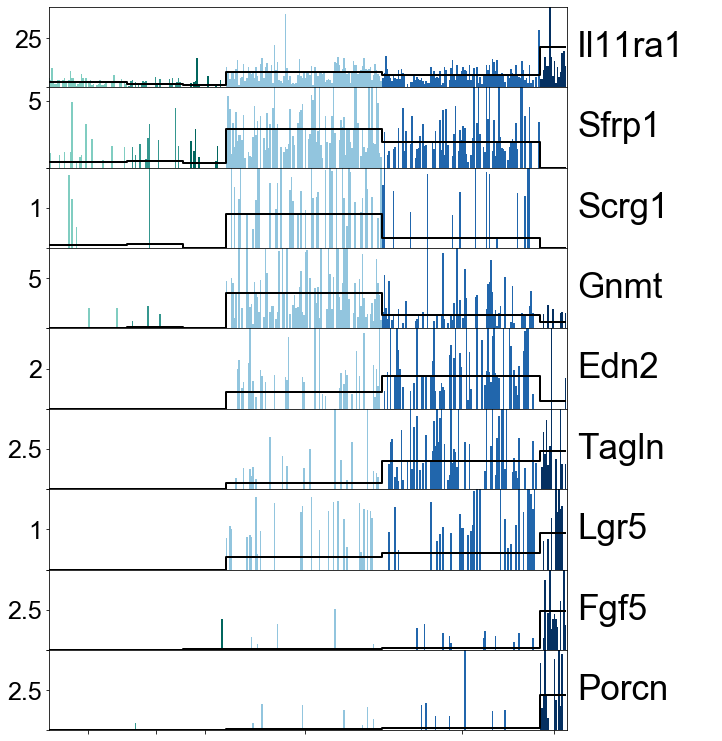

In [56]:
cells = cl_c_ANA
groups_sel = ['ANA - 0','ANA - 1', 'ANA - 21','ANA - 2','ANA - 3','ANA - 20']
cell_groups = cells[cells.isin(groups_sel)]
cell_ngroups = cells[~cells.isin(groups_sel)]
dataset = seqN[cell_groups.index]
#genes = ['Edn2']
cmap = cmap_2nd

#create figure

bar_size = 0.5
bar_pad = 0.25
width = 10
height = len(genes) * 1.2

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#create GS for gene barplots

gs1 = plt.GridSpec(len(genes), 2, hspace = 0.00, wspace = 0.0, top = 1 - ((bar_pad + bar_size) / height), right = 1, 
                   left = (bar_pad + bar_size) / width, bottom = 0, width_ratios = [14,4])

#create GS for sample group bar

gs0 = plt.GridSpec(1,2, left = (bar_pad + bar_size) / width, right = 1, top = 1,
                       bottom = 1 - ((bar_size) / height), hspace = 0.0, wspace = 0.0, width_ratios = [14,4])

#colorlist bar

clistBAR = [cmap[val] for val in cell_groups]

#draw genes

for g in genes:
    
        #create group_specific mean expressions
    
        mean_tmp = pd.Series(index = set(cell_groups))
        
        for gr in set(cell_groups):
            
            ix_tmp = cell_groups[cell_groups == gr].index
            mean_tmp[gr] = dataset.ix[g, ix_tmp].mean()
            
        #create white space for gene names
        
        ax0 = plt.subplot(gs1[genes.index(g),1])
        clean_axis(ax0)
 
        #create axis
            
        ax0 = plt.subplot(gs1[genes.index(g),0])
        
        ax0.axvspan(0, len(dataset.columns), color = '#FFFFFF', zorder = 0)
        
        #define xaxis
        
        ax0.set_xlim(left = 0, right = (len(dataset.columns)))
        ax0.xaxis.set_ticks(get_cluster_ticks(cell_groups))
        ax0.xaxis.set_ticklabels([])
        
        #define yaxis
        
        ax0.set_ylim(bottom = 0, top = np.ceil(np.max(mean_tmp) * 2))
        ax0.set_ylabel(g, family = 'Arial', fontsize = 35, rotation = 'horizontal', va = 'center', ha = 'left')
        ax0.yaxis.set_label_coords(1.02, 0.5)
        
        ax0.locator_params(axis='y', nbins=2)
        
        for tick_pos, tick in enumerate(ax0.yaxis.get_major_ticks()):
            if tick_pos % 2 == 1:
                ax0.yaxis.get_major_ticks()[tick_pos].label.set_family('Arial')
                ax0.yaxis.get_major_ticks()[tick_pos].label.set_fontsize(25)
            else:
                ax0.yaxis.get_major_ticks()[tick_pos].label.set_visible(False)
                
        #draw expression data
        
        ax0.bar(np.arange(0, len(dataset.columns),1), dataset.ix[g], color = clistBAR, linewidth = 0, width = 1.0)
        
        #draw means
        
        ax0.step(range(len(cell_groups)), [mean_tmp[val] for val in cell_groups], where = 'mid', color = 'black', linewidth = 2)


figname = 'v1.5_Fig3_bar_ANA_lORS_v2.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

# RNA velocity: model 1

In [32]:
import velocyto as vcy

In [33]:
print(vcy.__version__)

0.17.8


In [34]:
path_input_vcy = '/Users/simjoo/Projects/10X_Skin/velocyto/data_input/v1.5/'
path_output_vcy = '/Users/simjoo/Projects/10X_Skin/velocyto/data_output/v1.5/'

In [35]:
vlm_ana1 = vcy.load_velocyto_hdf5(path_output_vcy + exp_id + '_vlm_ana1.hdf5')

## Plot individual vectors

In [36]:
c_sel = ['%s-%s' % (c.split(':')[1][:-1], c.split(':')[0][:2]) for c in vlm_ana1.ca['CellID']]
delta_embedding_model1 = pd.DataFrame(vlm_ana1.delta_embedding, index = c_sel, columns = ['x','y'])
delta_embedding_random_model1 = pd.DataFrame(vlm_ana1.delta_embedding_random, index = c_sel, columns = ['x','y'])

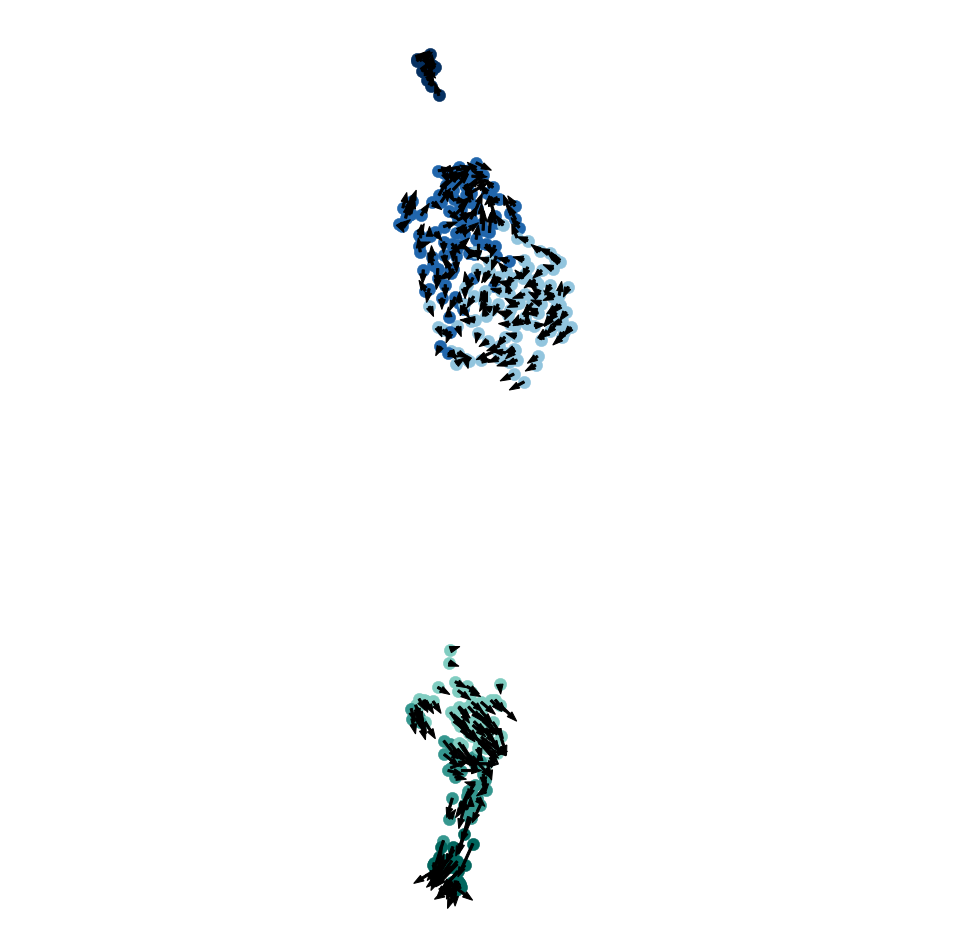

In [37]:
cells = cl_c_ANA[c_sel]
tsne = umap_ANA.loc[cells.index]
delta = delta_embedding_model1
cmap = cmap_2nd
time = cells_stage
markers = markers_time

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(tsne['x']), np.max(tsne['x'])
y_min, y_max = np.min(tsne['y']), np.max(tsne['y'])
x_diff, y_diff = x_max - x_min, y_max - y_min
x_cent, y_cent = x_min + 0.5 * x_diff, y_min + 0.5 * y_diff,

pad = 2.0

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_cent - 0.5 * x_diff - pad, y_cent + 0.5 * x_diff + pad,)

if x_diff < y_diff:
    xlim = (x_cent - 0.5 * y_diff - pad, x_cent + 0.5 * y_diff + pad,)
    ylim = (y_min - pad, y_max + pad)

text_pad = 2

#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

index = list(tsne.index)
np.random.shuffle(index)

for ix in index:

    ax1.scatter(tsne.loc[ix,'x'],
                tsne.loc[ix,'y'], 
                s = 150,
                linewidth = 0.5,
                c = cmap[cells[ix]],
                edgecolor=cmap[cells[ix]], 
                marker = markers[time[ix]])
    
    ax1.arrow(x = tsne.loc[ix,'x'], 
              y = tsne.loc[ix,'y'], 
              dx = delta.loc[ix,'x'], 
              dy = delta.loc[ix,'y'],
              width = 0.1, color = 'black')

clean_axis(ax1)

figname = 'v1.5_FigS4_tsne_vlm_ORS.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

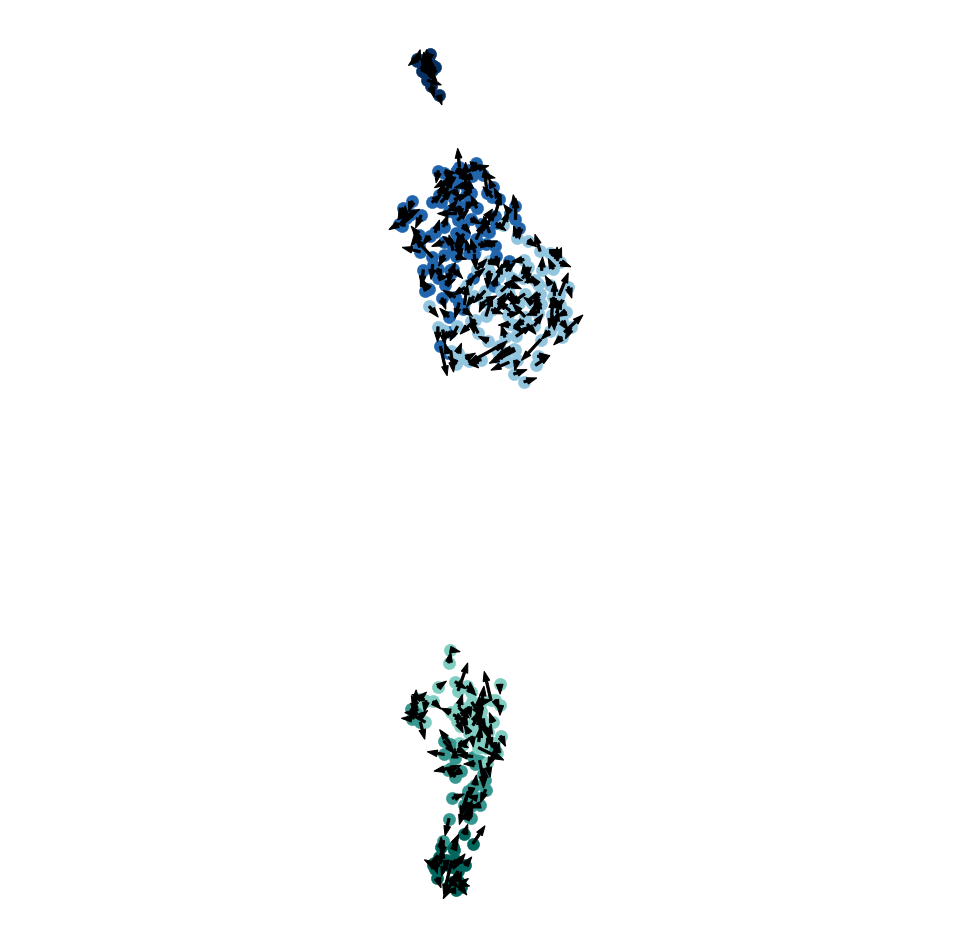

In [38]:
cells = cl_c_ANA[c_sel]
tsne = umap_ANA.loc[cells.index]
delta = delta_embedding_random_model1
cmap = cmap_2nd
time = cells_stage
markers = markers_time

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(tsne['x']), np.max(tsne['x'])
y_min, y_max = np.min(tsne['y']), np.max(tsne['y'])
x_diff, y_diff = x_max - x_min, y_max - y_min
x_cent, y_cent = x_min + 0.5 * x_diff, y_min + 0.5 * y_diff,

pad = 2.0

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_cent - 0.5 * x_diff - pad, y_cent + 0.5 * x_diff + pad,)

if x_diff < y_diff:
    xlim = (x_cent - 0.5 * y_diff - pad, x_cent + 0.5 * y_diff + pad,)
    ylim = (y_min - pad, y_max + pad)

text_pad = 2

#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

index = list(tsne.index)
np.random.shuffle(index)

for ix in index:

    ax1.scatter(tsne.loc[ix,'x'],
                tsne.loc[ix,'y'], 
                s = 150,
                linewidth = 0.5,
                c = cmap[cells[ix]],
                edgecolor=cmap[cells[ix]], 
                marker = markers[time[ix]])
    
    ax1.arrow(x = tsne.loc[ix,'x'], 
              y = tsne.loc[ix,'y'], 
              dx = delta.loc[ix,'x'], 
              dy = delta.loc[ix,'y'],
              width = 0.1, color = 'black')

clean_axis(ax1)

figname = 'v1.5_FigS4_tsne_vlm_ORS_random.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

## Plot vector field

In [39]:
vlm_ana1.colorandum = [cmap_2nd[cl_c_ANA['%s-%s' % (c.split(':')[1][:-1], c.split(':')[0][:2])]] for c in vlm_ana1.ca['CellID']]

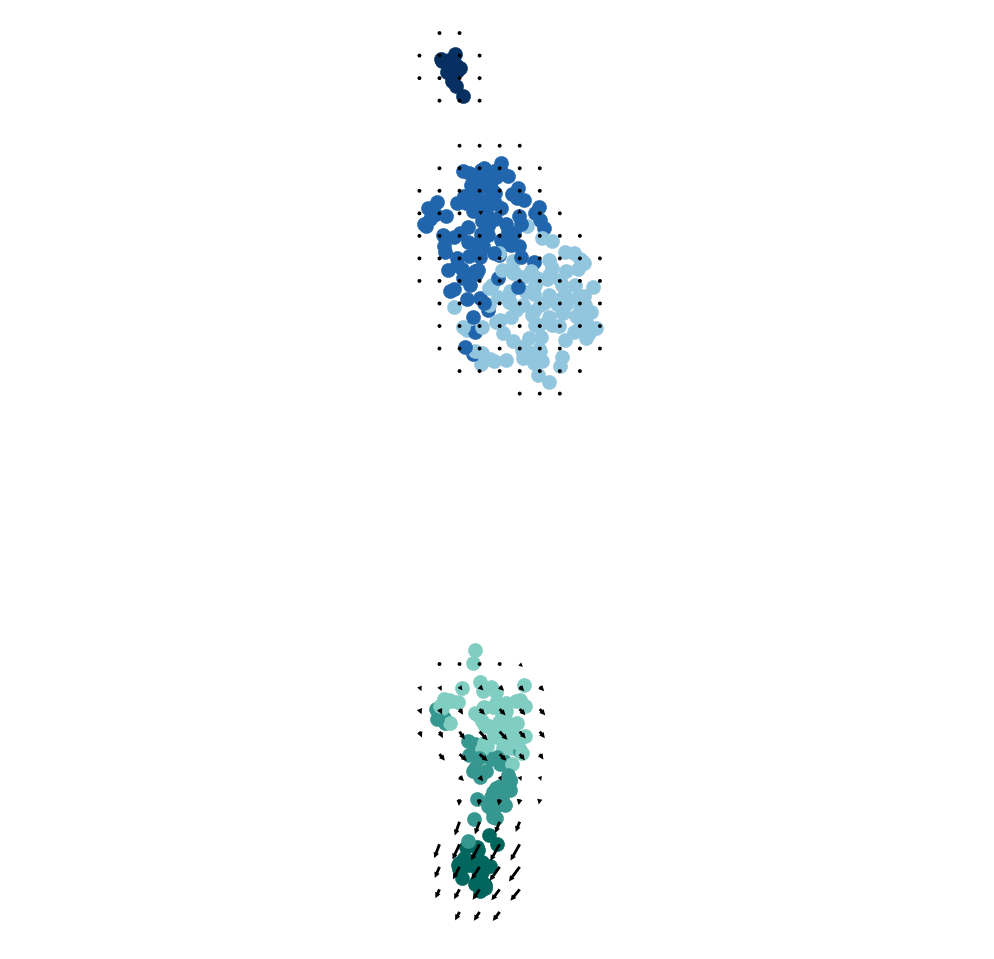

In [53]:
cells = cl_c_ANA[cl_c_ANA.isin(['ANA - 0','ANA - 1','ANA - 2','ANA - 3','ANA - 20','ANA - 21'])]
tsne = umap_ANA.loc[cells.index]
cmap = cmap_2nd
time = cells_stage
markers = markers_time

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(tsne['x']), np.max(tsne['x'])
y_min, y_max = np.min(tsne['y']), np.max(tsne['y'])
x_diff, y_diff = x_max - x_min, y_max - y_min
x_cent, y_cent = x_min + 0.5 * x_diff, y_min + 0.5 * y_diff,

pad = 2.0

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_cent - 0.5 * x_diff - pad, y_cent + 0.5 * x_diff + pad,)

if x_diff < y_diff:
    xlim = (x_cent - 0.5 * y_diff - pad, x_cent + 0.5 * y_diff + pad,)
    ylim = (y_min - pad, y_max + pad)

text_pad = 2
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

index = list(tsne.index)
np.random.shuffle(index)

for ix in index:

    ax1.scatter(tsne.loc[ix,'x'],
                tsne.loc[ix,'y'], 
                s = 200,
                linewidth = 0.5,
                c = cmap[cells[ix]],
                edgecolor=cmap[cells[ix]], 
                marker = markers[time[ix]])
    
vlm_ana1.calculate_grid_arrows(smooth=1.0, steps=(10, 40), n_neighbors=25)
vlm_ana1.plot_grid_arrows(scatter_kwargs_dict={"alpha":0, "lw":0.0, "edgecolor":"0", "s":100, "rasterized":True}, 
                     min_mass=1, angles='xy', scale_units='xy', plot_random = False,
                     headaxislength=2, headlength=2, headwidth=2, quiver_scale=0.75, width = 0.003)

figname = 'v1.5_Fig3_tsne_vlm_ORS_field.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

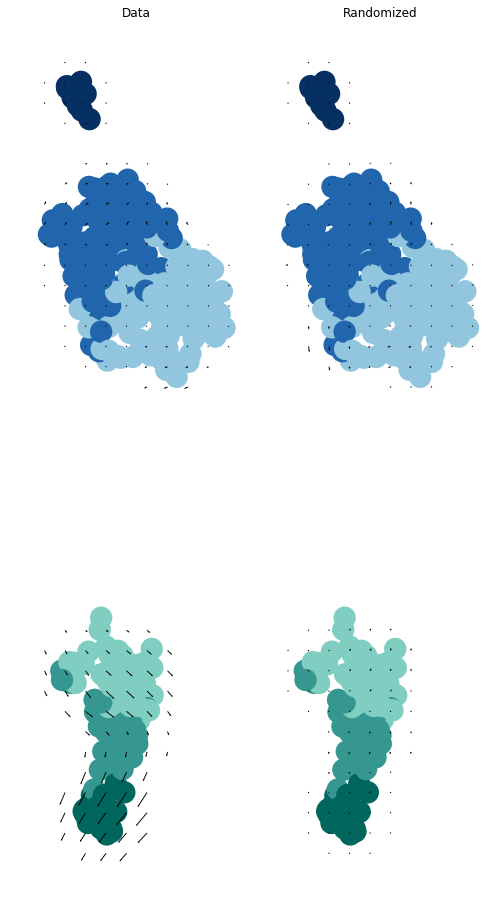

In [54]:
height = 16
width = 8

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(tsne['x']), np.max(tsne['x'])
y_min, y_max = np.min(tsne['y']), np.max(tsne['y'])
x_diff, y_diff = x_max - x_min, y_max - y_min
x_cent, y_cent = x_min + 0.5 * x_diff, y_min + 0.5 * y_diff,

pad = 2.0

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_cent - 0.5 * x_diff - pad, y_cent + 0.5 * x_diff + pad,)

if x_diff < y_diff:
    xlim = (x_cent - 0.5 * y_diff - pad, x_cent + 0.5 * y_diff + pad,)
    ylim = (y_min - pad, y_max + pad)

text_pad = 2

#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

vlm_ana1.plot_grid_arrows(scatter_kwargs_dict={"alpha":1, "lw":0.0, "edgecolor":"0", "s":500, "rasterized":True}, 
                     min_mass=1, angles='xy', scale_units='xy', plot_random = True,
                     headaxislength=2, headlength=2, headwidth=2, quiver_scale=0.75)

figname = 'v1.5_Fig4_tsne_vlm_ORS_field_vs_random.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

# RNA velocity: model 1 (intermediate)

In [55]:
vlm_ana1 = vcy.load_velocyto_hdf5(path_output_vcy + exp_id + '_vlm_ana1_interm.hdf5')

## Phase diagrams

In [56]:
S_model1 = pd.DataFrame(vlm_ana1.Sx, index = vlm_ana1.ra['Gene'], columns = vlm_ana1.ca['CellID']).astype(float)
S_model1.columns = ['%s-%s' % (c.split(':')[1][:-1], c.split(':')[0][:2]) for c in vlm_ana1.ca['CellID']]

U_model1 = pd.DataFrame(vlm_ana1.Ux, index = vlm_ana1.ra['Gene'], columns = vlm_ana1.ca['CellID']).astype(float)
U_model1.columns = ['%s-%s' % (c.split(':')[1][:-1], c.split(':')[0][:2]) for c in vlm_ana1.ca['CellID']]

gammas_model1 = pd.Series(vlm_ana1.gammas, index = vlm_ana1.ra['Gene'])
q_model1 = pd.Series(vlm_ana1.q, index = vlm_ana1.ra['Gene'])

In [95]:
"""
for gene in ['Krt14','Pthlh','Wfdc18','Sbsn','Flnb','Cpe','Barx2','S100a6','Gnmt','Fndc1']:
    
    data_S = S_model1.loc[gene]
    data_U = U_model1.loc[gene]
    gamma = gammas_model1[gene]
    q = q_model1[gene]
    groups = cl_c_ANA
    cmap = cmap_2nd

    #initialize figure

    height = 10
    width = 10

    fig = plt.figure(facecolor = 'w', figsize = (width, height))

    ax = plt.subplot(111)

    #set axes

    ax.set_xlim(0, np.max(data_S) * 1.1)
    ax.set_xlabel('Spliced', family = 'Arial', fontsize = 40)
    for ix, t in enumerate(ax.xaxis.get_ticklabels()):
        t.set_family('Arial')
        t.set_fontsize(25)

    ax.set_ylim(0, np.max(data_U) * 1.1)
    ax.set_ylabel('Unspliced', family = 'Arial', fontsize = 40)
    for ix, t in enumerate(ax.yaxis.get_ticklabels()):
        t.set_family('Arial')
        t.set_fontsize(25)

    #plot data

    ax.scatter(data_S, data_U, c = [cmap[groups[c]] for c in data_S.index], s = 100)
    xnew = np.linspace(0, ax.get_xlim()[1])
    ax.plot(xnew, gamma * xnew + q, c='k', lw = 2)
    ax.axvspan(ax.get_xlim()[0], ax.get_xlim()[1], color = 'white', zorder=0)
    
    figname = 'v1.5_Fig4_phase_vlm_model1_%s.pdf' % gene
    plt.savefig('%s/%s' % (path_figures, figname), 
                format = 'pdf', 
                transparent = True, 
                bbox_inches = 'tight', 
                pad_inches = 0, 
                rasterized = True)
"""

"\nfor gene in ['Krt14','Pthlh','Wfdc18','Sbsn','Flnb','Cpe','Barx2','S100a6','Gnmt','Fndc1']:\n    \n    data_S = S_model1.loc[gene]\n    data_U = U_model1.loc[gene]\n    gamma = gammas_model1[gene]\n    q = q_model1[gene]\n    groups = cl_c_ANA\n    cmap = cmap_2nd\n\n    #initialize figure\n\n    height = 10\n    width = 10\n\n    fig = plt.figure(facecolor = 'w', figsize = (width, height))\n\n    ax = plt.subplot(111)\n\n    #set axes\n\n    ax.set_xlim(0, np.max(data_S) * 1.1)\n    ax.set_xlabel('Spliced', family = 'Arial', fontsize = 40)\n    for ix, t in enumerate(ax.xaxis.get_ticklabels()):\n        t.set_family('Arial')\n        t.set_fontsize(25)\n\n    ax.set_ylim(0, np.max(data_U) * 1.1)\n    ax.set_ylabel('Unspliced', family = 'Arial', fontsize = 40)\n    for ix, t in enumerate(ax.yaxis.get_ticklabels()):\n        t.set_family('Arial')\n        t.set_fontsize(25)\n\n    #plot data\n\n    ax.scatter(data_S, data_U, c = [cmap[groups[c]] for c in data_S.index], s = 100)\n    

## Plot expression as color

In [96]:
"""
for g in ['Krt14','Pthlh','Wfdc18','Sbsn','Flnb','Cpe','Barx2','S100a6','Gnmt','Fndc1']:
    
    data_full = S_model1.loc[g].fillna(0)
    c_sel = cl_c_ANA[cl_c_ANA.isin(['ANA - 0','ANA - 1','ANA - 21','ANA - 2','ANA - 3','ANA - 20'])].index
    data = S_model1.loc[g, c_sel].fillna(0)
    tsne = umap_ANA.loc[data.index]
    cmap = plt.cm.viridis
    time = cells_stage
    markers = markers_time
    vmin = 0
    vmax = np.percentile(data_full, 99)

    #initialize figure

    height = 17
    width = 17

    fig = plt.figure(facecolor = 'w', figsize = (width, height))

    #define x- and y-limits

    x_min, x_max = np.min(tsne['x']), np.max(tsne['x'])
    y_min, y_max = np.min(tsne['y']), np.max(tsne['y'])
    x_diff, y_diff = x_max - x_min, y_max - y_min
    x_cent, y_cent = x_min + 0.5 * x_diff, y_min + 0.5 * y_diff,

    pad = 2.0

    if x_diff > y_diff:
        xlim = (x_min - pad, x_max + pad)
        ylim = (y_cent - 0.5 * x_diff - pad, y_cent + 0.5 * x_diff + pad,)

    if x_diff < y_diff:
        xlim = (x_cent - 0.5 * y_diff - pad, x_cent + 0.5 * y_diff + pad,)
        ylim = (y_min - pad, y_max + pad)

    text_pad = 2

    #draw groups

    ax1 = plt.subplot()

    ax1.set_xlim(xlim[0], xlim[1])
    ax1.set_ylim(ylim[0], ylim[1])

    for ix in tsne.index:

        ax1.scatter(tsne.ix[ix,'x'],
                    tsne.ix[ix,'y'], 
                    s = 250,
                    linewidth = 0.5,
                    c = cmap((data[ix] - vmin) / (vmax - vmin)),
                    edgecolor=cmap((data[ix] - vmin) / (vmax - vmin)), 
                    marker = markers[time[ix]])

    clean_axis(ax1)
    
    figname = 'v1.5_FigS4_vel_expr_model1_%s.pdf' % g
    plt.savefig('%s/%s' % (path_figures, figname), 
                format = 'pdf', 
                transparent = True, 
                bbox_inches = 'tight', 
                pad_inches = 0, 
                rasterized = True)
"""

"\nfor g in ['Krt14','Pthlh','Wfdc18','Sbsn','Flnb','Cpe','Barx2','S100a6','Gnmt','Fndc1']:\n    \n    data_full = S_model1.loc[g].fillna(0)\n    c_sel = cl_c_ANA[cl_c_ANA.isin(['ANA - 0','ANA - 1','ANA - 21','ANA - 2','ANA - 3','ANA - 20'])].index\n    data = S_model1.loc[g, c_sel].fillna(0)\n    tsne = umap_ANA.loc[data.index]\n    cmap = plt.cm.viridis\n    time = cells_stage\n    markers = markers_time\n    vmin = 0\n    vmax = np.percentile(data_full, 99)\n\n    #initialize figure\n\n    height = 17\n    width = 17\n\n    fig = plt.figure(facecolor = 'w', figsize = (width, height))\n\n    #define x- and y-limits\n\n    x_min, x_max = np.min(tsne['x']), np.max(tsne['x'])\n    y_min, y_max = np.min(tsne['y']), np.max(tsne['y'])\n    x_diff, y_diff = x_max - x_min, y_max - y_min\n    x_cent, y_cent = x_min + 0.5 * x_diff, y_min + 0.5 * y_diff,\n\n    pad = 2.0\n\n    if x_diff > y_diff:\n        xlim = (x_min - pad, x_max + pad)\n        ylim = (y_cent - 0.5 * x_diff - pad, y_cent + 

## Plot velocity as color

In [97]:
vlm_ana1.predict_U(which_S='Sx')
vlm_ana1.calculate_velocity()
vlm_ana1.calculate_shift(assumption="constant_velocity")
vlm_ana1.extrapolate_cell_at_t(delta_t=1)

In [98]:
vel1 = pd.DataFrame(vlm_ana1.Sx_t - vlm_ana1.Sx, index = vlm_ana1.ra['Gene'], columns = vlm_ana1.ca['CellID'])
vel1.columns = ['%s-%s' % (c.split(':')[1][:-1], c.split(':')[0][:2]) for c in vlm_ana1.ca['CellID']]

In [101]:
"""
for g in ['Krt14','Pthlh','Wfdc18','Sbsn','Flnb','Cpe','Barx2','S100a6','Gnmt','Fndc1']:
    
    data_full = vel1.loc[g]
    c_sel = cl_c_ANA[cl_c_ANA.isin(['ANA - 0','ANA - 1','ANA - 21','ANA - 2','ANA - 3','ANA - 20'])].index
    data = vel1.loc[g,c_sel]
    tsne = umap_ANA.ix[data.index]
    cmap = plt.cm.RdBu_r
    time = cells_stage
    markers = markers_time
    vmin = -np.max(np.abs(np.percentile(data_full, [1, 99])))
    vmax = np.max(np.abs(np.percentile(data_full, [1, 99])))

    #initialize figure

    height = 17
    width = 17

    fig = plt.figure(facecolor = 'w', figsize = (width, height))

    #define x- and y-limits

    x_min, x_max = np.min(tsne['x']), np.max(tsne['x'])
    y_min, y_max = np.min(tsne['y']), np.max(tsne['y'])
    x_diff, y_diff = x_max - x_min, y_max - y_min
    x_cent, y_cent = x_min + 0.5 * x_diff, y_min + 0.5 * y_diff,

    pad = 2.0

    if x_diff > y_diff:
        xlim = (x_min - pad, x_max + pad)
        ylim = (y_cent - 0.5 * x_diff - pad, y_cent + 0.5 * x_diff + pad,)

    if x_diff < y_diff:
        xlim = (x_cent - 0.5 * y_diff - pad, x_cent + 0.5 * y_diff + pad,)
        ylim = (y_min - pad, y_max + pad)

    text_pad = 2

    #draw groups

    ax1 = plt.subplot()

    ax1.set_xlim(xlim[0], xlim[1])
    ax1.set_ylim(ylim[0], ylim[1])

    remove_ticks(ax1)

    for ix in tsne.index:

        ax1.scatter(tsne.ix[ix,'x'],
                    tsne.ix[ix,'y'], 
                    s = 250,
                    linewidth = 0.5,
                    c = cmap((data[ix] - vmin) / (vmax - vmin)),
                    edgecolor=cmap((data[ix] - vmin) / (vmax - vmin)), 
                    marker = markers[time[ix]])

    clean_axis(ax1)
    
    figname = 'v1.5_Fig4_vel_vlm_model1_%s.pdf' % g
    plt.savefig('%s/%s' % (path_figures, figname), 
                format = 'pdf', 
                transparent = True, 
                bbox_inches = 'tight', 
                pad_inches = 0, 
                rasterized = True)
"""

"\nfor g in ['Krt14','Pthlh','Wfdc18','Sbsn','Flnb','Cpe','Barx2','S100a6','Gnmt','Fndc1']:\n    \n    data_full = vel1.loc[g]\n    c_sel = cl_c_ANA[cl_c_ANA.isin(['ANA - 0','ANA - 1','ANA - 21','ANA - 2','ANA - 3','ANA - 20'])].index\n    data = vel1.loc[g,c_sel]\n    tsne = umap_ANA.ix[data.index]\n    cmap = plt.cm.RdBu_r\n    time = cells_stage\n    markers = markers_time\n    vmin = -np.max(np.abs(np.percentile(data_full, [1, 99])))\n    vmax = np.max(np.abs(np.percentile(data_full, [1, 99])))\n\n    #initialize figure\n\n    height = 17\n    width = 17\n\n    fig = plt.figure(facecolor = 'w', figsize = (width, height))\n\n    #define x- and y-limits\n\n    x_min, x_max = np.min(tsne['x']), np.max(tsne['x'])\n    y_min, y_max = np.min(tsne['y']), np.max(tsne['y'])\n    x_diff, y_diff = x_max - x_min, y_max - y_min\n    x_cent, y_cent = x_min + 0.5 * x_diff, y_min + 0.5 * y_diff,\n\n    pad = 2.0\n\n    if x_diff > y_diff:\n        xlim = (x_min - pad, x_max + pad)\n        ylim = 

# t-SNE - time points

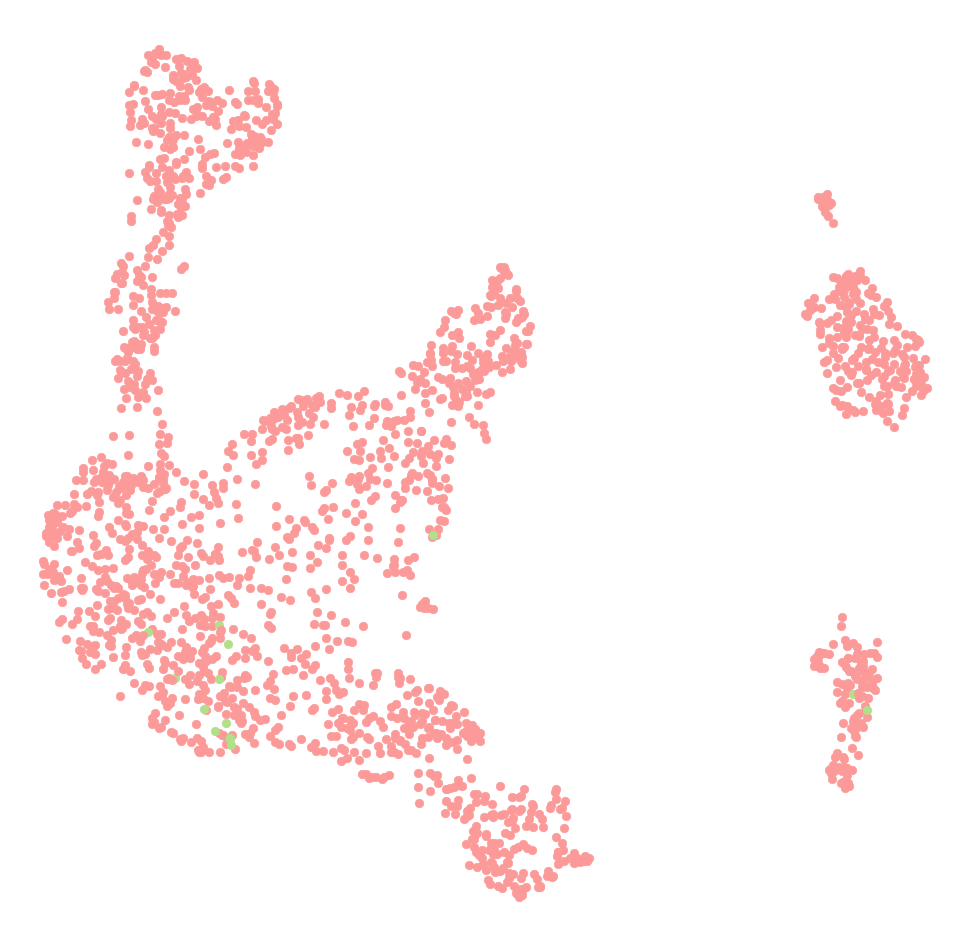

In [240]:
cells = cl_c_ANA
tsne = umap_ANA.ix[cells.index]
cmap = cmap_time
time = cells_stage
markers = markers_time

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(tsne['x']), np.max(tsne['x'])
y_min, y_max = np.min(tsne['y']), np.max(tsne['y'])
x_diff, y_diff = x_max - x_min, y_max - y_min

pad = 2.0

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_min * (x_diff / y_diff) - pad, y_max * (x_diff / y_diff) + pad)

if x_diff < y_diff:
    xlim = (x_min * (y_diff/x_diff) - pad, x_max * (y_diff/x_diff) + pad)
    ylim = (y_min - pad, y_max + pad)

text_pad = 2
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

remove_ticks(ax1)

index = list(tsne.index)
np.random.shuffle(index)

for ix in tsne.index:

    ax1.scatter(tsne.loc[ix,'x'],
                tsne.loc[ix,'y'], 
                s = 75,
                linewidth = 0.5,
                c = cmap[time[ix]],
                edgecolor=cmap[time[ix]], 
                marker = markers[time[ix]])

clean_axis(ax1)

# t-SNE - replicates

In [32]:
Counter(cells_replicate[cl_c_ANA.index])

Counter({'5wk1': 909,
         '5wk2': 646,
         '5wk3': 391,
         '5w unassigned': 13,
         '9wk2': 14,
         '9w unassigned': 1})

In [33]:
cmap_replicate = {'9wk1':'#238b45',
                  '9wk2':'#74c476',
                  '9w unassigned':'#bae4b3',
                  '5wk1':'#cb181d',
                  '5wk2':'#fb6a4a',
                  '5wk3':'#fcae91',
                  '5w unassigned':'#fee5d9'}

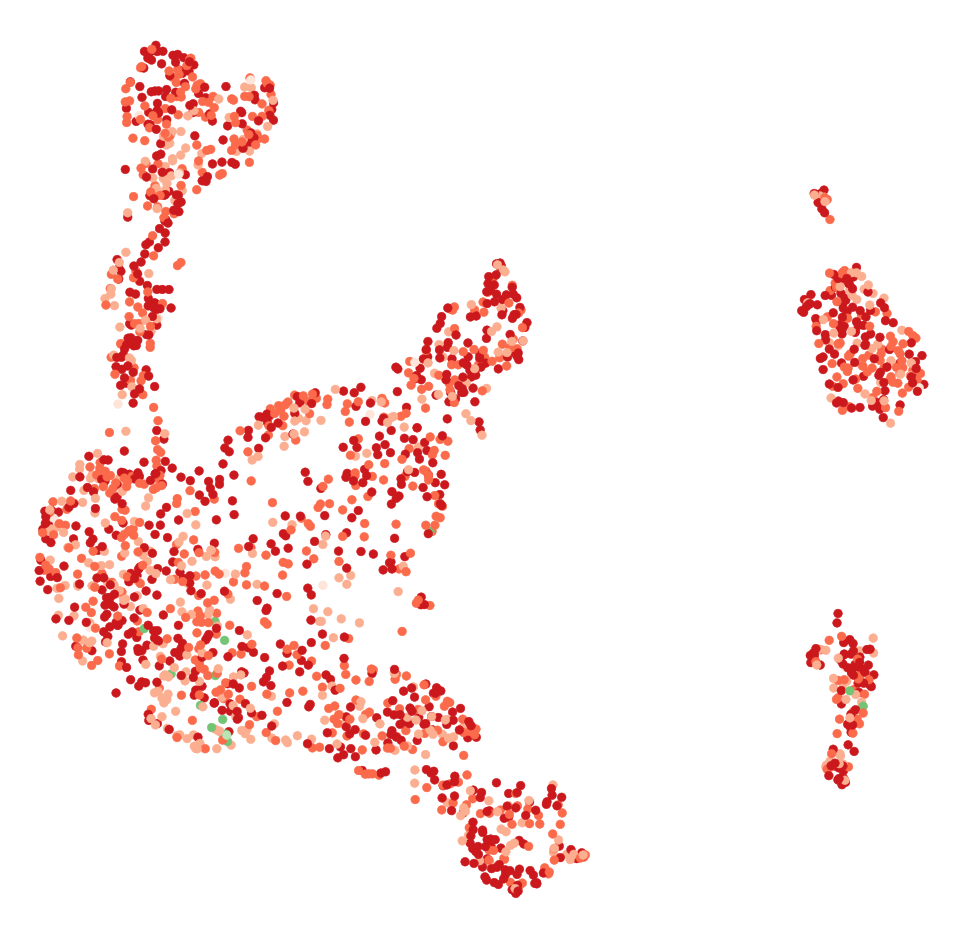

In [34]:
cells = cl_c_ANA
tsne = umap_ANA.loc[cells.index]
cmap = cmap_replicate
time = cells_replicate

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(tsne['x']), np.max(tsne['x'])
y_min, y_max = np.min(tsne['y']), np.max(tsne['y'])
x_diff, y_diff = x_max - x_min, y_max - y_min

pad = 2.0

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_min * (x_diff / y_diff) - pad, y_max * (x_diff / y_diff) + pad)

if x_diff < y_diff:
    xlim = (x_min * (y_diff/x_diff) - pad, x_max * (y_diff/x_diff) + pad)
    ylim = (y_min - pad, y_max + pad)

text_pad = 2
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

remove_ticks(ax1)

index = list(tsne.index)
np.random.shuffle(index)

clist = [cmap[time[i]] for i in index]

ax1.scatter(tsne.loc[index,'x'],
            tsne.loc[index,'y'], 
            s = 75,
            linewidth = 0.5,
            c = clist,
            edgecolor=clist)

clean_axis(ax1)

figname = 'v1.5_Fig2_tSNE_ANA_replicate.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

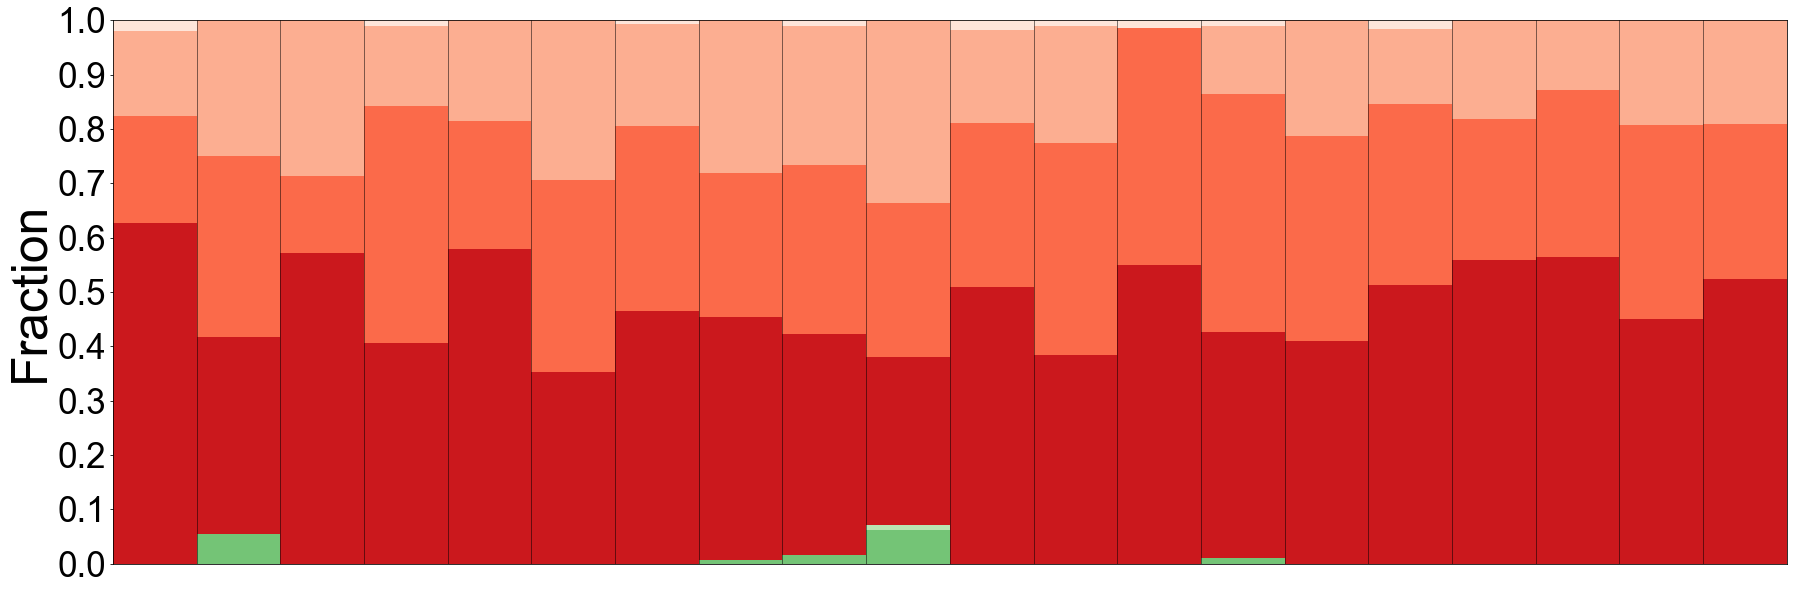

In [35]:
groups = cl_c_ANA
replicates = cells_replicate
cmap = cmap_replicate

#initialize figure

height = 10
width = len(return_unique(groups)) * 1.5

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#set axes

ax = plt.subplot(111)

ax.set_xlim(-0.5, len(return_unique(groups))-0.5)
ax.set_xticks([])

ax.set_ylim(0,1)
ax.set_yticks([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
ax.set_yticklabels([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0], family = 'Arial', fontsize = 35)
ax.set_ylabel('Fraction', fontsize = 50, family = 'Arial')

#get data

for pos, gr in enumerate(return_unique(groups)):
    c_tmp = groups[groups==gr].index
    l = len(c_tmp)
    rep_tmp = Counter(replicates[c_tmp])
    y = 0
    for r in ['9wk1','9wk2','9w unassigned','5wk1','5wk2','5wk3','5w unassigned']:
        y_new = y + rep_tmp[r]/l
        ax.bar(x = pos, bottom=y, height=y_new, width=1, color = cmap[r])
        y = y_new
    ax.axvline(pos+0.5, color = 'k', linewidth = 0.5)
    
figname = 'v1.5_Fig2_bar_ANA_replicate.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

# Expression of apriori markers (based on Langbein et al.)

## Scored according to negative binominal model

In [241]:
def OD_apriori_markers(data, cells, genes, log2_var_z, neg_log = False, pval_min = 1e-16):
    
    #crop data
    
    data = data.ix[genes,cells]
    
    #define output
    
    output = pd.DataFrame(index = genes, columns = cells)
    
    #iterate over genes
    
    for g in genes:
    
        #get gene stats
    
        mean = data.ix[g].mean()
        log2_mean = np.log2(mean + 1)
        log2_var = log2_var_z[0] * (log2_mean**2) + log2_var_z[1] * log2_mean + log2_var_z[2]
        var = np.exp2(log2_var) - 1
          
        #get n and p for neg binom
    
        n, p = OD_get_neg_binom_n_p(mean,var)
        
        #fit neg binom and score
        
        for c in cells:
            x = data.ix[g,c]
            output.ix[g,c] = 1  - scipy.stats.nbinom.cdf(x - 1, n, p) #prob for value less than x
            
    output[output == 0] = pval_min
            
    if neg_log == True:
        return -np.log10(output.astype(float))
      
    return output

In [242]:
def OD_get_neg_binom_n_p(mean,var):
        
        
    #exception when no expression
        
    if mean == 0.0:
        return 0.9999, 0.9999
        
    #exception when mean >= variance
        
    if mean >= var:
        mean = var - 0.0001
            
    #normal case
    
    p = mean/var
    n = - ((mean**2) / (mean - var))

    return n, p


Dropping unexpressed genes from dataset

After mean expression cutoff of 0.005, 10970 genes remain

After high variance feature selection, 2500 genes remain


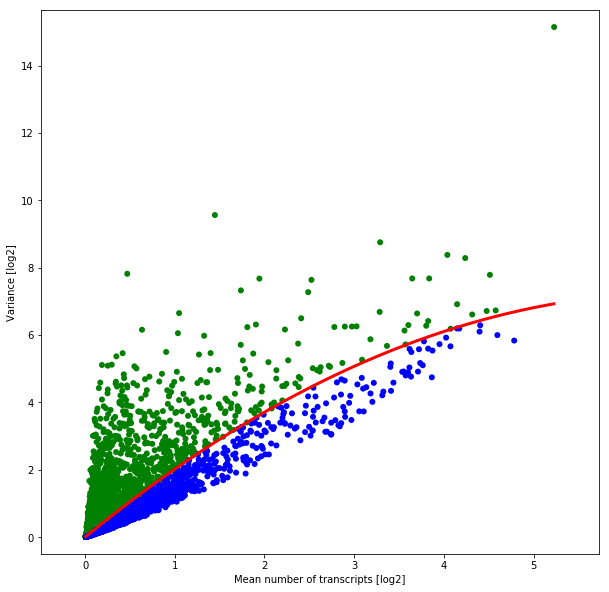

In [243]:
log2_var_z_ana = select_features_log2_var_polyfit_v2(seqN[cl_c_ANA.index], 0.005, 2500, return_all=True)[1]

In [245]:
Langbein_Krts = pd.read_table('%s/Langbein_Krts_v2.txt' % path_input, sep = '\t', header = 0, index_col = 0)

In [246]:
AP_Krts = OD_apriori_markers(seqN, cl_c_ANA.index, Langbein_Krts.index, log2_var_z_ana, neg_log = True)

/Users/simjoo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """
/Users/simjoo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/Users/simjoo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:30: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [247]:
AP_Krts[np.isnan(AP_Krts)] = 0

In [248]:
def OD_score_AP_markers(pvals, expr):
    
    expr[expr==0] = -1
    
    output = pd.DataFrame(index = expr.columns, columns = pvals.columns)
    
    for gr in expr.columns:
        sign = expr[gr]
        output.loc[gr] = pvals.mul(sign, axis = 0).sum(axis=0)
    
    return output

In [249]:
AP_Krts_score = OD_score_AP_markers(AP_Krts, Langbein_Krts)

### ORS

/Users/simjoo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


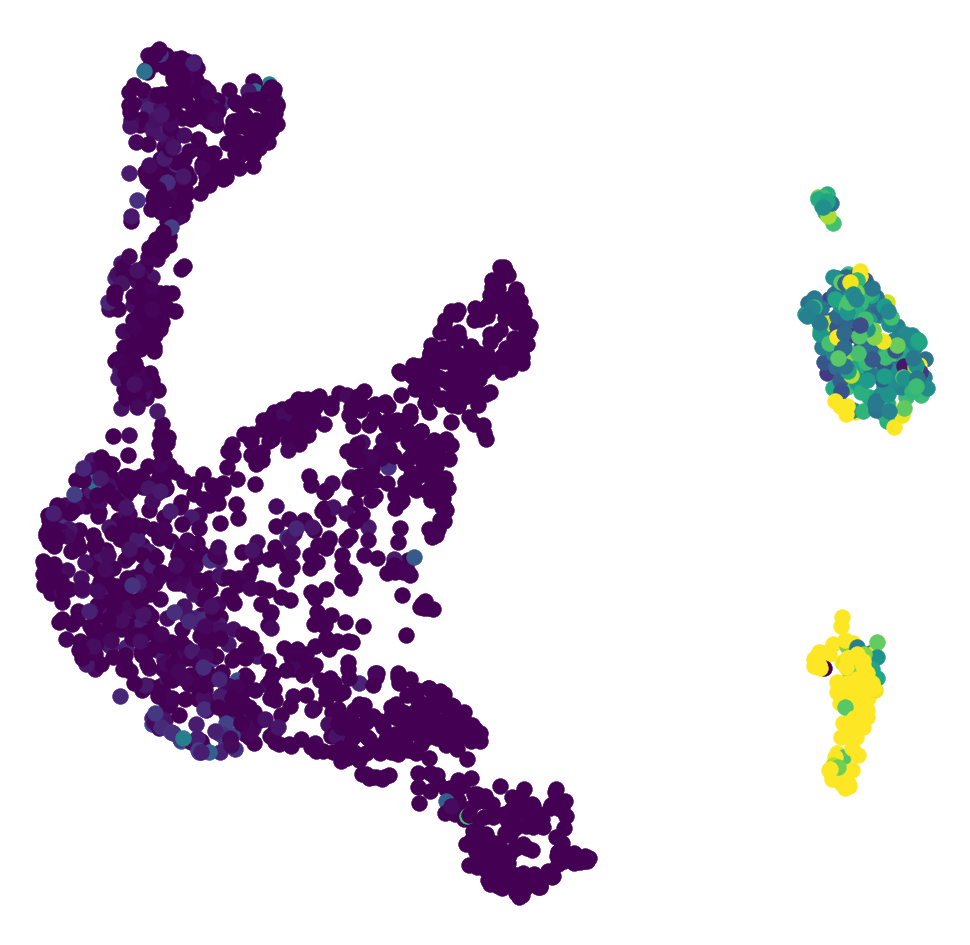

In [250]:
data = AP_Krts_score.loc['ORS']
cells = cl_c_ANA
tsne = umap_ANA.ix[cells.index]
cmap = plt.cm.viridis
time = cells_stage
markers = markers_time
vmin = 0#np.percentile(data, 5)
vmax = np.percentile(data, 95)

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(tsne['x']), np.max(tsne['x'])
y_min, y_max = np.min(tsne['y']), np.max(tsne['y'])
x_diff, y_diff = x_max - x_min, y_max - y_min

pad = 2.0

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_min * (x_diff / y_diff) - pad, y_max * (x_diff / y_diff) + pad)

if x_diff < y_diff:
    xlim = (x_min * (y_diff/x_diff) - pad, x_max * (y_diff/x_diff) + pad)
    ylim = (y_min - pad, y_max + pad)

text_pad = 2
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

remove_ticks(ax1)

for ix in tsne.index:

    ax1.scatter(tsne.ix[ix,'x'],
                tsne.ix[ix,'y'], 
                s = 250,
                linewidth = 0.5,
                c = cmap((data[ix] - vmin) / (vmax - vmin)),
                edgecolor=cmap((data[ix] - vmin) / (vmax - vmin)), 
                marker = markers[time[ix]])

clean_axis(ax1)

figname = 'v1.5_Fig3_AP_ANA_ORS_nb.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

/Users/simjoo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/simjoo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


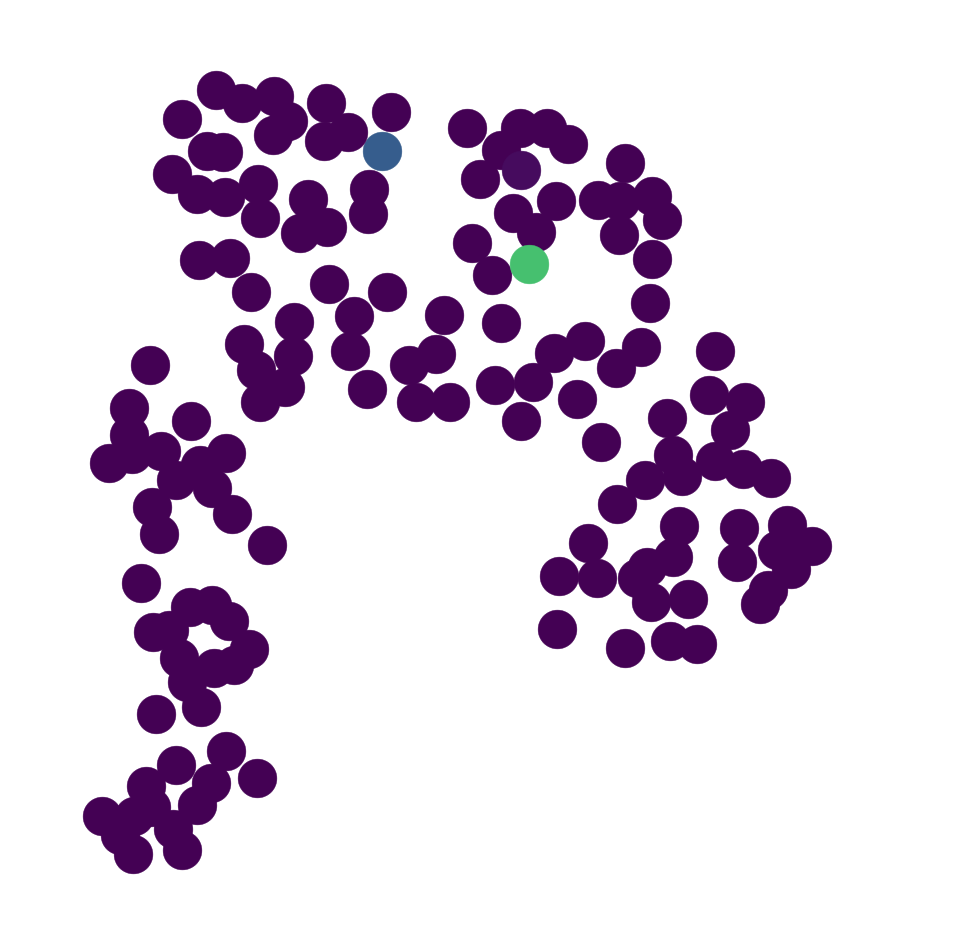

In [251]:
data = AP_Krts_score.loc['ORS']
cells = cl_c_ANA
tsne = umap_ANA_IRS.ix[cells.index]
cmap = plt.cm.viridis
time = cells_stage
markers = markers_time
vmin = 0#np.percentile(data, 5)
vmax = np.percentile(data, 95)

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(tsne['x']), np.max(tsne['x'])
y_min, y_max = np.min(tsne['y']), np.max(tsne['y'])
x_diff, y_diff = x_max - x_min, y_max - y_min

pad = 2.0

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_min * (x_diff / y_diff) - pad, y_max * (x_diff / y_diff) + pad)

if x_diff < y_diff:
    xlim = (x_min * (y_diff/x_diff) - pad, x_max * (y_diff/x_diff) + pad)
    ylim = (y_min - pad, y_max + pad)

text_pad = 2
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

remove_ticks(ax1)

for ix in tsne.index:

    ax1.scatter(tsne.ix[ix,'x'],
                tsne.ix[ix,'y'], 
                s = 1500,
                linewidth = 0.5,
                c = cmap((data[ix] - vmin) / (vmax - vmin)),
                edgecolor=cmap((data[ix] - vmin) / (vmax - vmin)), 
                marker = markers[time[ix]])

clean_axis(ax1)

figname = 'v1.5_Fig3_AP_ANA_IRS_ORS_nb.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

## Companion layer

/Users/simjoo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


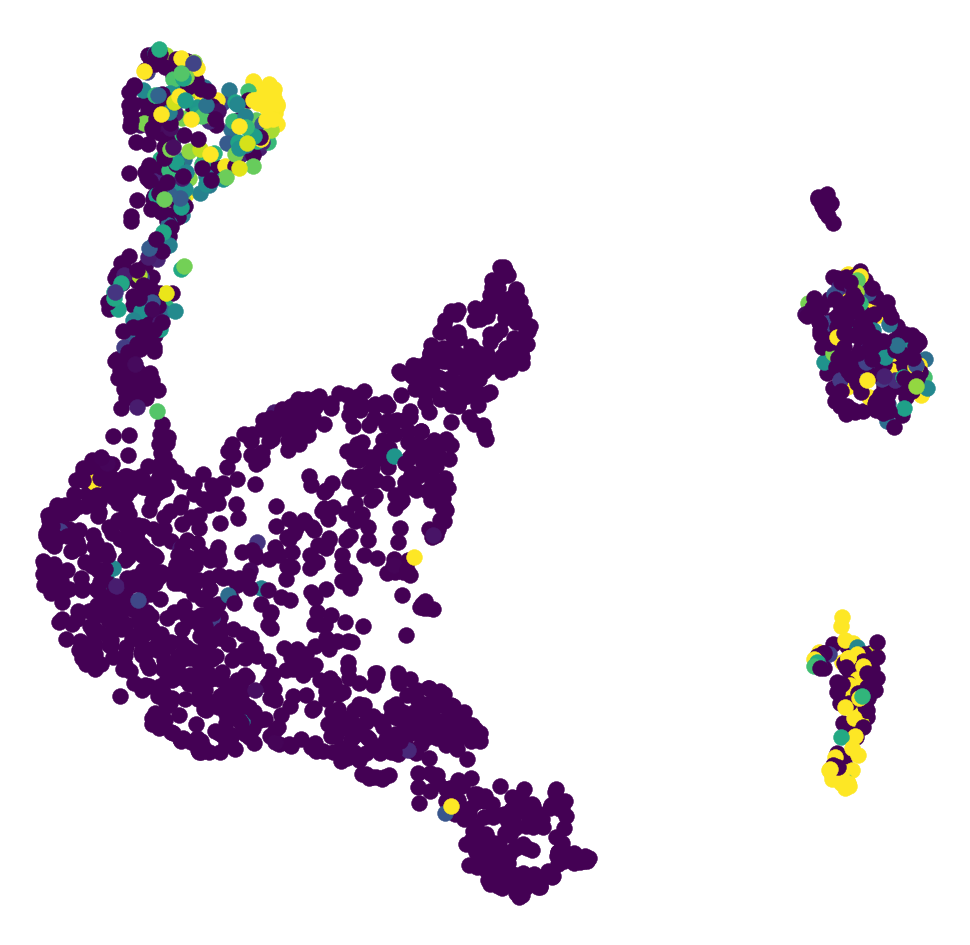

In [252]:
data = AP_Krts_score.loc['cl']
cells = cl_c_ANA
tsne = umap_ANA.ix[cells.index]
cmap = plt.cm.viridis
time = cells_stage
markers = markers_time
vmin = 0#np.percentile(data, 5)
vmax = np.percentile(data, 95)

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(tsne['x']), np.max(tsne['x'])
y_min, y_max = np.min(tsne['y']), np.max(tsne['y'])
x_diff, y_diff = x_max - x_min, y_max - y_min

pad = 2.0

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_min * (x_diff / y_diff) - pad, y_max * (x_diff / y_diff) + pad)

if x_diff < y_diff:
    xlim = (x_min * (y_diff/x_diff) - pad, x_max * (y_diff/x_diff) + pad)
    ylim = (y_min - pad, y_max + pad)

text_pad = 2
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

remove_ticks(ax1)

for ix in tsne.index:

    ax1.scatter(tsne.ix[ix,'x'],
                tsne.ix[ix,'y'], 
                s = 250,
                linewidth = 0.5,
                c = cmap((data[ix] - vmin) / (vmax - vmin)),
                edgecolor=cmap((data[ix] - vmin) / (vmax - vmin)), 
                marker = markers[time[ix]])

clean_axis(ax1)

figname = 'v1.5_Fig3_AP_ANA_CL_nb.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

/Users/simjoo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


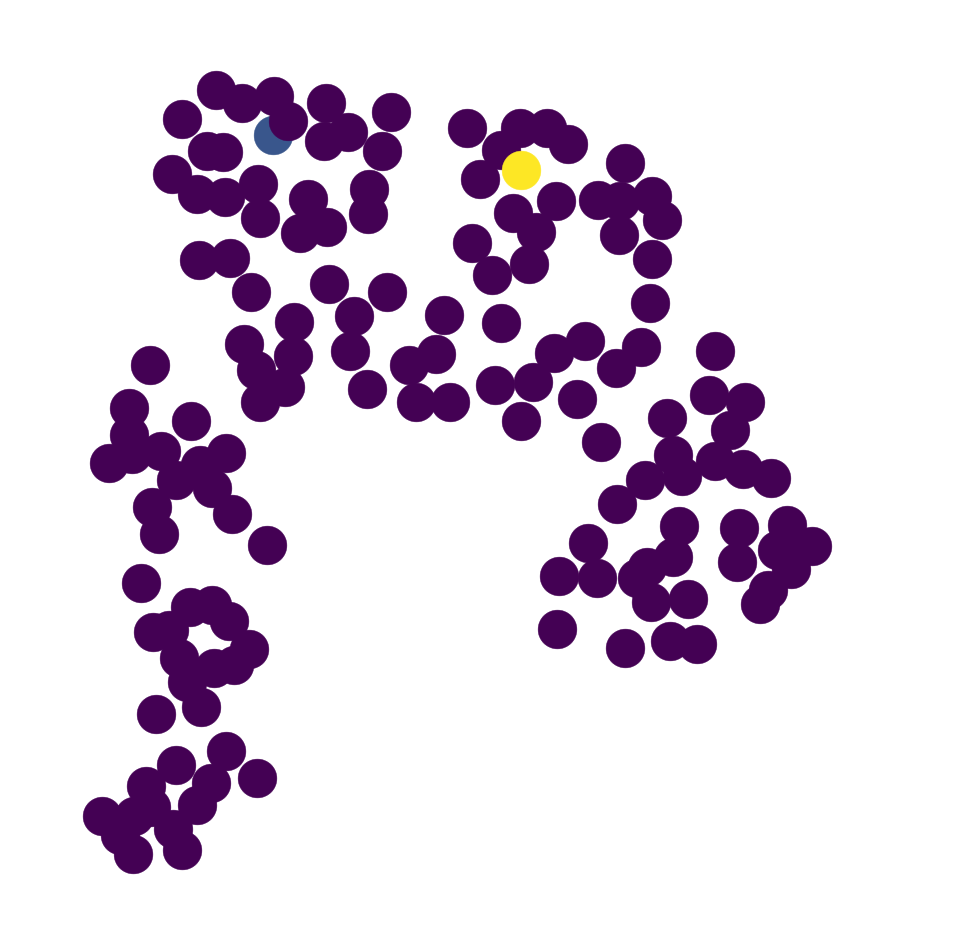

In [253]:
data = AP_Krts_score.loc['cl']
cells = cl_c_ANA
tsne = umap_ANA_IRS.ix[cells.index]
cmap = plt.cm.viridis
time = cells_stage
markers = markers_time
vmin = 0#np.percentile(data, 5)
vmax = np.percentile(data, 95)

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(tsne['x']), np.max(tsne['x'])
y_min, y_max = np.min(tsne['y']), np.max(tsne['y'])
x_diff, y_diff = x_max - x_min, y_max - y_min

pad = 2.0

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_min * (x_diff / y_diff) - pad, y_max * (x_diff / y_diff) + pad)

if x_diff < y_diff:
    xlim = (x_min * (y_diff/x_diff) - pad, x_max * (y_diff/x_diff) + pad)
    ylim = (y_min - pad, y_max + pad)

text_pad = 2
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

remove_ticks(ax1)

for ix in tsne.index:

    ax1.scatter(tsne.ix[ix,'x'],
                tsne.ix[ix,'y'], 
                s = 1500,
                linewidth = 0.5,
                c = cmap((data[ix] - vmin) / (vmax - vmin)),
                edgecolor=cmap((data[ix] - vmin) / (vmax - vmin)), 
                marker = markers[time[ix]])

clean_axis(ax1)

figname = 'v1.5_Fig3_AP_ANA_IRS_cl_nb.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

## IRS (Henle)

/Users/simjoo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


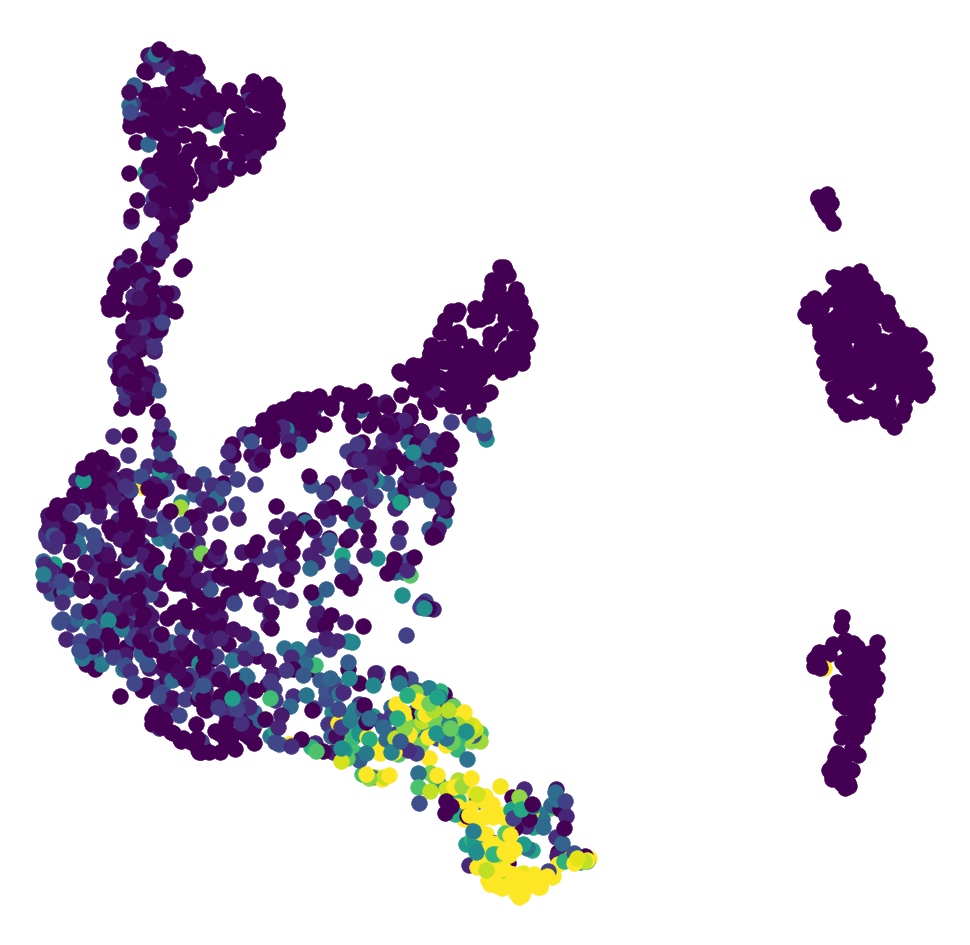

In [254]:
data = AP_Krts_score.loc['He']
cells = cl_c_ANA
tsne = umap_ANA.ix[cells.index]
cmap = plt.cm.viridis
time = cells_stage
markers = markers_time
vmin = 0#np.percentile(data, 5)
vmax = np.percentile(data, 95)

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(tsne['x']), np.max(tsne['x'])
y_min, y_max = np.min(tsne['y']), np.max(tsne['y'])
x_diff, y_diff = x_max - x_min, y_max - y_min

pad = 2.0

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_min * (x_diff / y_diff) - pad, y_max * (x_diff / y_diff) + pad)

if x_diff < y_diff:
    xlim = (x_min * (y_diff/x_diff) - pad, x_max * (y_diff/x_diff) + pad)
    ylim = (y_min - pad, y_max + pad)

text_pad = 2
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

remove_ticks(ax1)

for ix in tsne.index:

    ax1.scatter(tsne.ix[ix,'x'],
                tsne.ix[ix,'y'], 
                s = 250,
                linewidth = 0.5,
                c = cmap((data[ix] - vmin) / (vmax - vmin)),
                edgecolor=cmap((data[ix] - vmin) / (vmax - vmin)), 
                marker = markers[time[ix]])

clean_axis(ax1)

figname = 'v1.5_Fig3_AP_ANA_He_nb.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

/Users/simjoo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


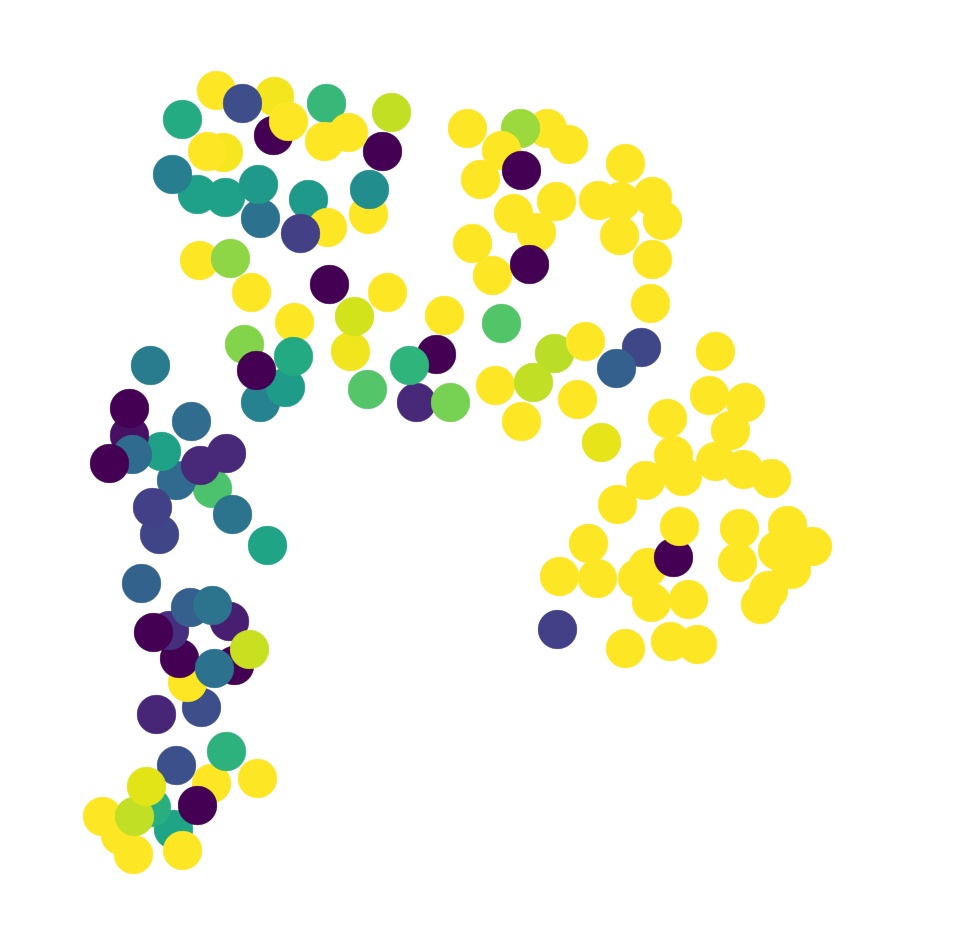

In [255]:
data = AP_Krts_score.loc['He']
cells = cl_c_ANA
tsne = umap_ANA_IRS.ix[cells.index]
cmap = plt.cm.viridis
time = cells_stage
markers = markers_time
vmin = 0#np.percentile(data, 5)
vmax = np.percentile(data, 95)

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(tsne['x']), np.max(tsne['x'])
y_min, y_max = np.min(tsne['y']), np.max(tsne['y'])
x_diff, y_diff = x_max - x_min, y_max - y_min

pad = 2.0

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_min * (x_diff / y_diff) - pad, y_max * (x_diff / y_diff) + pad)

if x_diff < y_diff:
    xlim = (x_min * (y_diff/x_diff) - pad, x_max * (y_diff/x_diff) + pad)
    ylim = (y_min - pad, y_max + pad)

text_pad = 2
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

remove_ticks(ax1)

for ix in tsne.index:

    ax1.scatter(tsne.ix[ix,'x'],
                tsne.ix[ix,'y'], 
                s = 1500,
                linewidth = 0.5,
                c = cmap((data[ix] - vmin) / (vmax - vmin)),
                edgecolor=cmap((data[ix] - vmin) / (vmax - vmin)), 
                marker = markers[time[ix]])

clean_axis(ax1)

figname = 'v1.5_Fig3_AP_ANA_IRS_He_nb.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

### IRS Huxley

/Users/simjoo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


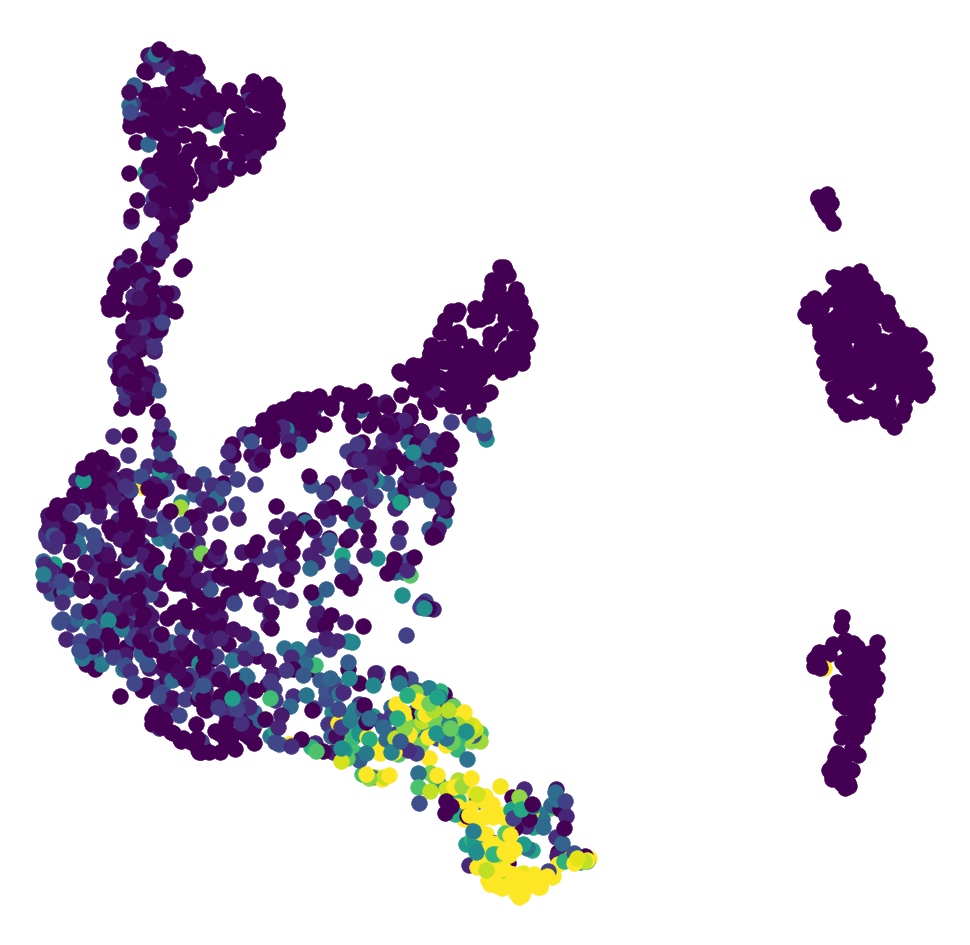

In [256]:
data = AP_Krts_score.loc['Hu']
cells = cl_c_ANA
tsne = umap_ANA.ix[cells.index]
cmap = plt.cm.viridis
time = cells_stage
markers = markers_time
vmin = 0#np.percentile(data, 5)
vmax = np.percentile(data, 95)

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(tsne['x']), np.max(tsne['x'])
y_min, y_max = np.min(tsne['y']), np.max(tsne['y'])
x_diff, y_diff = x_max - x_min, y_max - y_min

pad = 2.0

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_min * (x_diff / y_diff) - pad, y_max * (x_diff / y_diff) + pad)

if x_diff < y_diff:
    xlim = (x_min * (y_diff/x_diff) - pad, x_max * (y_diff/x_diff) + pad)
    ylim = (y_min - pad, y_max + pad)

text_pad = 2
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

remove_ticks(ax1)

for ix in tsne.index:

    ax1.scatter(tsne.ix[ix,'x'],
                tsne.ix[ix,'y'], 
                s = 250,
                linewidth = 0.5,
                c = cmap((data[ix] - vmin) / (vmax - vmin)),
                edgecolor=cmap((data[ix] - vmin) / (vmax - vmin)), 
                marker = markers[time[ix]])

clean_axis(ax1)

figname = 'v1.5_Fig3_AP_ANA_Hu_nb.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

/Users/simjoo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


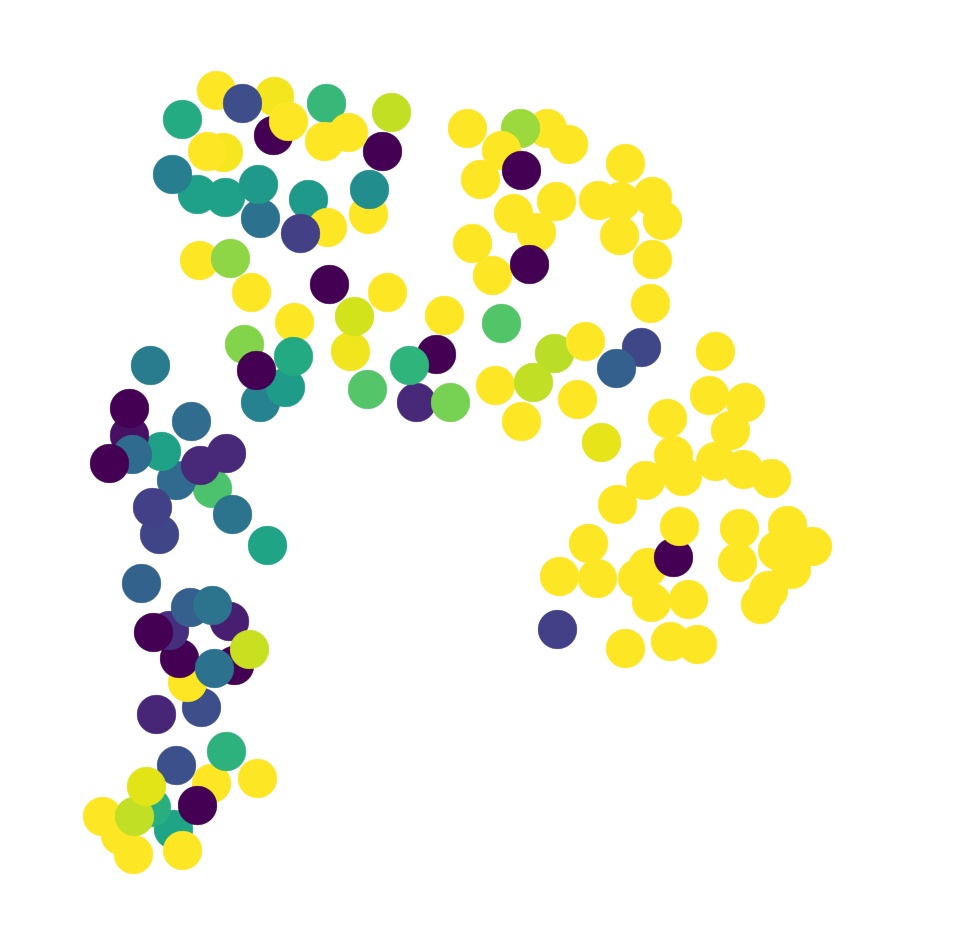

In [257]:
data = AP_Krts_score.loc['Hu']
cells = cl_c_ANA
tsne = umap_ANA_IRS.ix[cells.index]
cmap = plt.cm.viridis
time = cells_stage
markers = markers_time
vmin = 0#np.percentile(data, 5)
vmax = np.percentile(data, 95)

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(tsne['x']), np.max(tsne['x'])
y_min, y_max = np.min(tsne['y']), np.max(tsne['y'])
x_diff, y_diff = x_max - x_min, y_max - y_min

pad = 2.0

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_min * (x_diff / y_diff) - pad, y_max * (x_diff / y_diff) + pad)

if x_diff < y_diff:
    xlim = (x_min * (y_diff/x_diff) - pad, x_max * (y_diff/x_diff) + pad)
    ylim = (y_min - pad, y_max + pad)

text_pad = 2
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

remove_ticks(ax1)

for ix in tsne.index:

    ax1.scatter(tsne.ix[ix,'x'],
                tsne.ix[ix,'y'], 
                s = 1500,
                linewidth = 0.5,
                c = cmap((data[ix] - vmin) / (vmax - vmin)),
                edgecolor=cmap((data[ix] - vmin) / (vmax - vmin)), 
                marker = markers[time[ix]])

clean_axis(ax1)

figname = 'v1.5_Fig3_AP_ANA_IRS_Hu_nb.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

### IRS cuticle

/Users/simjoo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


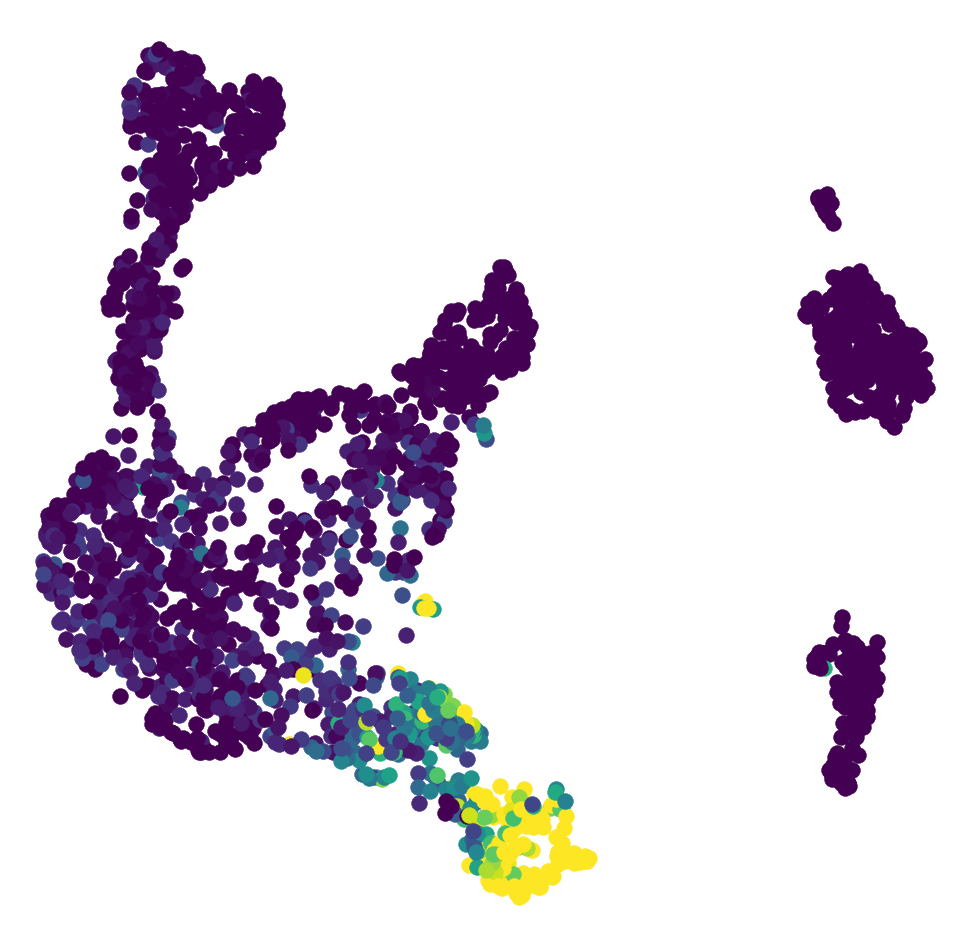

In [258]:
data = AP_Krts_score.loc['icu']
cells = cl_c_ANA
tsne = umap_ANA.ix[cells.index]
cmap = plt.cm.viridis
time = cells_stage
markers = markers_time
vmin = 0#np.percentile(data, 5)
vmax = np.percentile(data, 95)

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(tsne['x']), np.max(tsne['x'])
y_min, y_max = np.min(tsne['y']), np.max(tsne['y'])
x_diff, y_diff = x_max - x_min, y_max - y_min

pad = 2.0

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_min * (x_diff / y_diff) - pad, y_max * (x_diff / y_diff) + pad)

if x_diff < y_diff:
    xlim = (x_min * (y_diff/x_diff) - pad, x_max * (y_diff/x_diff) + pad)
    ylim = (y_min - pad, y_max + pad)

text_pad = 2
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

remove_ticks(ax1)

for ix in tsne.index:

    ax1.scatter(tsne.ix[ix,'x'],
                tsne.ix[ix,'y'], 
                s = 250,
                linewidth = 0.5,
                c = cmap((data[ix] - vmin) / (vmax - vmin)),
                edgecolor=cmap((data[ix] - vmin) / (vmax - vmin)), 
                marker = markers[time[ix]])

clean_axis(ax1)

figname = 'v1.5_Fig3_AP_ANA_icu_nb.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

/Users/simjoo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


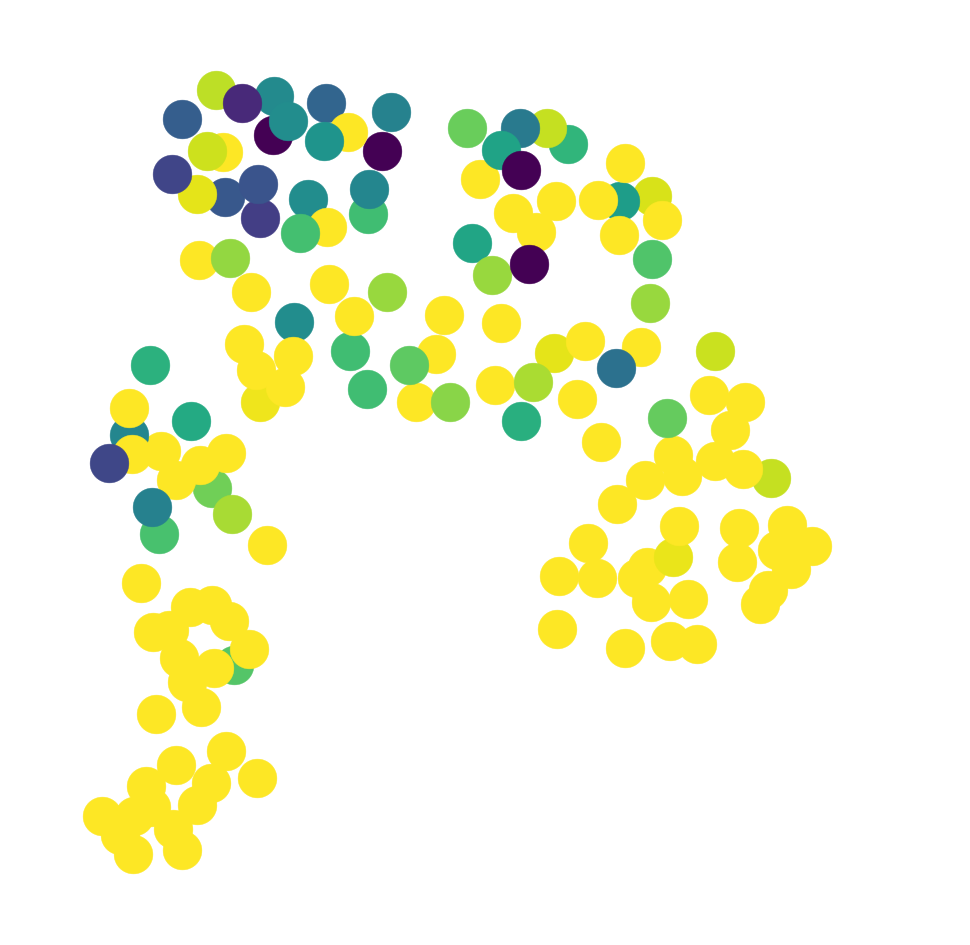

In [259]:
data = AP_Krts_score.loc['icu']
cells = cl_c_ANA
tsne = umap_ANA_IRS.ix[cells.index]
cmap = plt.cm.viridis
time = cells_stage
markers = markers_time
vmin = 0#np.percentile(data, 5)
vmax = np.percentile(data, 95)

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(tsne['x']), np.max(tsne['x'])
y_min, y_max = np.min(tsne['y']), np.max(tsne['y'])
x_diff, y_diff = x_max - x_min, y_max - y_min

pad = 2.0

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_min * (x_diff / y_diff) - pad, y_max * (x_diff / y_diff) + pad)

if x_diff < y_diff:
    xlim = (x_min * (y_diff/x_diff) - pad, x_max * (y_diff/x_diff) + pad)
    ylim = (y_min - pad, y_max + pad)

text_pad = 2
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

remove_ticks(ax1)

for ix in tsne.index:

    ax1.scatter(tsne.ix[ix,'x'],
                tsne.ix[ix,'y'], 
                s = 1500,
                linewidth = 0.5,
                c = cmap((data[ix] - vmin) / (vmax - vmin)),
                edgecolor=cmap((data[ix] - vmin) / (vmax - vmin)), 
                marker = markers[time[ix]])

clean_axis(ax1)

figname = 'v1.5_Fig3_AP_ANA_IRS_icu_nb.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

### Cuticle

/Users/simjoo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


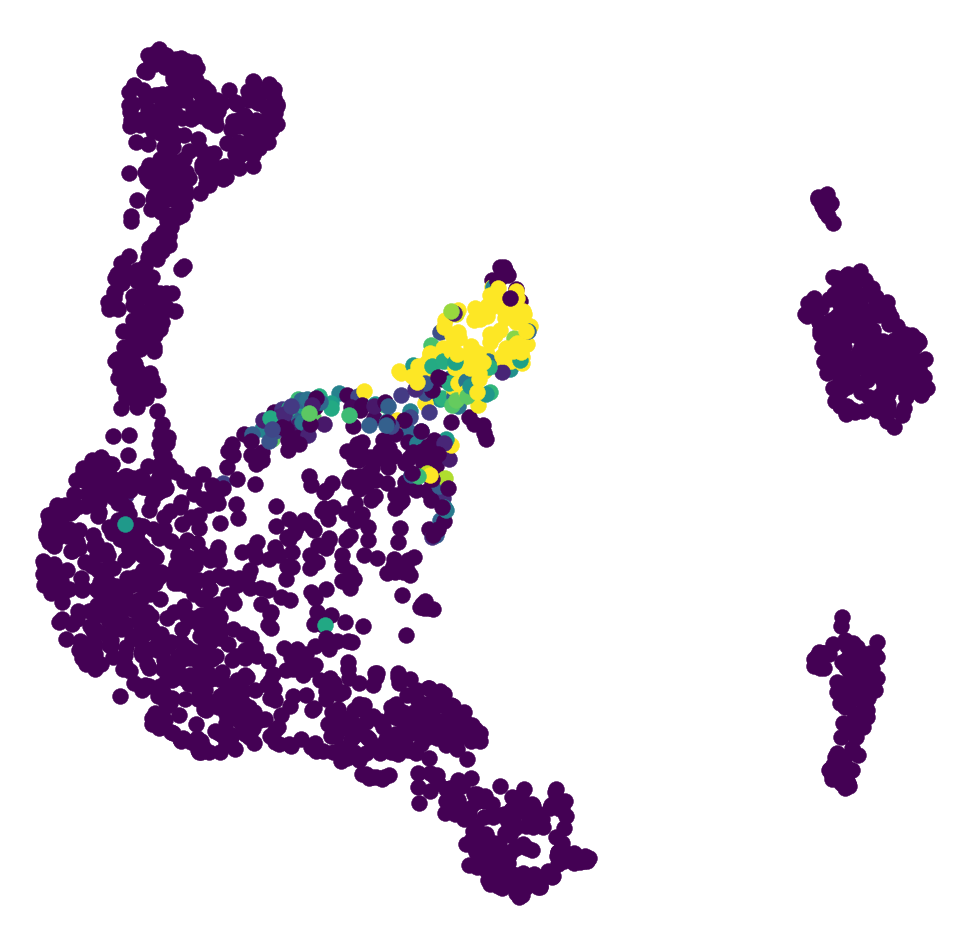

In [260]:
data = AP_Krts_score.loc['cu']
cells = cl_c_ANA
tsne = umap_ANA.ix[cells.index]
cmap = plt.cm.viridis
time = cells_stage
markers = markers_time
vmin = 0#np.percentile(data, 5)
vmax = np.percentile(data, 95)

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(tsne['x']), np.max(tsne['x'])
y_min, y_max = np.min(tsne['y']), np.max(tsne['y'])
x_diff, y_diff = x_max - x_min, y_max - y_min

pad = 2.0

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_min * (x_diff / y_diff) - pad, y_max * (x_diff / y_diff) + pad)

if x_diff < y_diff:
    xlim = (x_min * (y_diff/x_diff) - pad, x_max * (y_diff/x_diff) + pad)
    ylim = (y_min - pad, y_max + pad)

text_pad = 2
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

remove_ticks(ax1)

for ix in tsne.index:

    ax1.scatter(tsne.ix[ix,'x'],
                tsne.ix[ix,'y'], 
                s = 250,
                linewidth = 0.5,
                c = cmap((data[ix] - vmin) / (vmax - vmin)),
                edgecolor=cmap((data[ix] - vmin) / (vmax - vmin)), 
                marker = markers[time[ix]])

clean_axis(ax1)

figname = 'v1.5_Fig3_AP_ANA_cu_nb.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

/Users/simjoo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


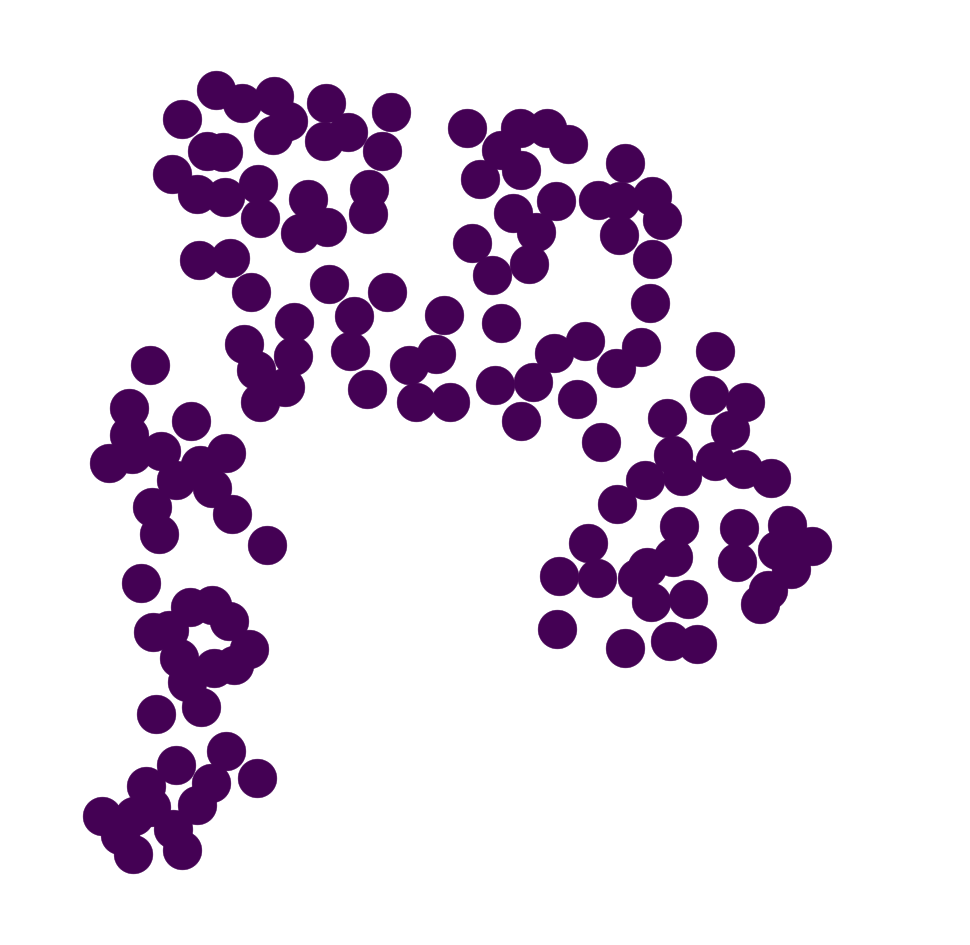

In [261]:
data = AP_Krts_score.loc['cu']
cells = cl_c_ANA
tsne = umap_ANA_IRS.ix[cells.index]
cmap = plt.cm.viridis
time = cells_stage
markers = markers_time
vmin = 0#np.percentile(data, 5)
vmax = np.percentile(data, 95)

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(tsne['x']), np.max(tsne['x'])
y_min, y_max = np.min(tsne['y']), np.max(tsne['y'])
x_diff, y_diff = x_max - x_min, y_max - y_min

pad = 2.0

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_min * (x_diff / y_diff) - pad, y_max * (x_diff / y_diff) + pad)

if x_diff < y_diff:
    xlim = (x_min * (y_diff/x_diff) - pad, x_max * (y_diff/x_diff) + pad)
    ylim = (y_min - pad, y_max + pad)

text_pad = 2
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

remove_ticks(ax1)

for ix in tsne.index:

    ax1.scatter(tsne.ix[ix,'x'],
                tsne.ix[ix,'y'], 
                s = 1500,
                linewidth = 0.5,
                c = cmap((data[ix] - vmin) / (vmax - vmin)),
                edgecolor=cmap((data[ix] - vmin) / (vmax - vmin)), 
                marker = markers[time[ix]])

clean_axis(ax1)

figname = 'v1.5_Fig3_AP_ANA_IRS_cu_nb.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

### Cortex

/Users/simjoo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


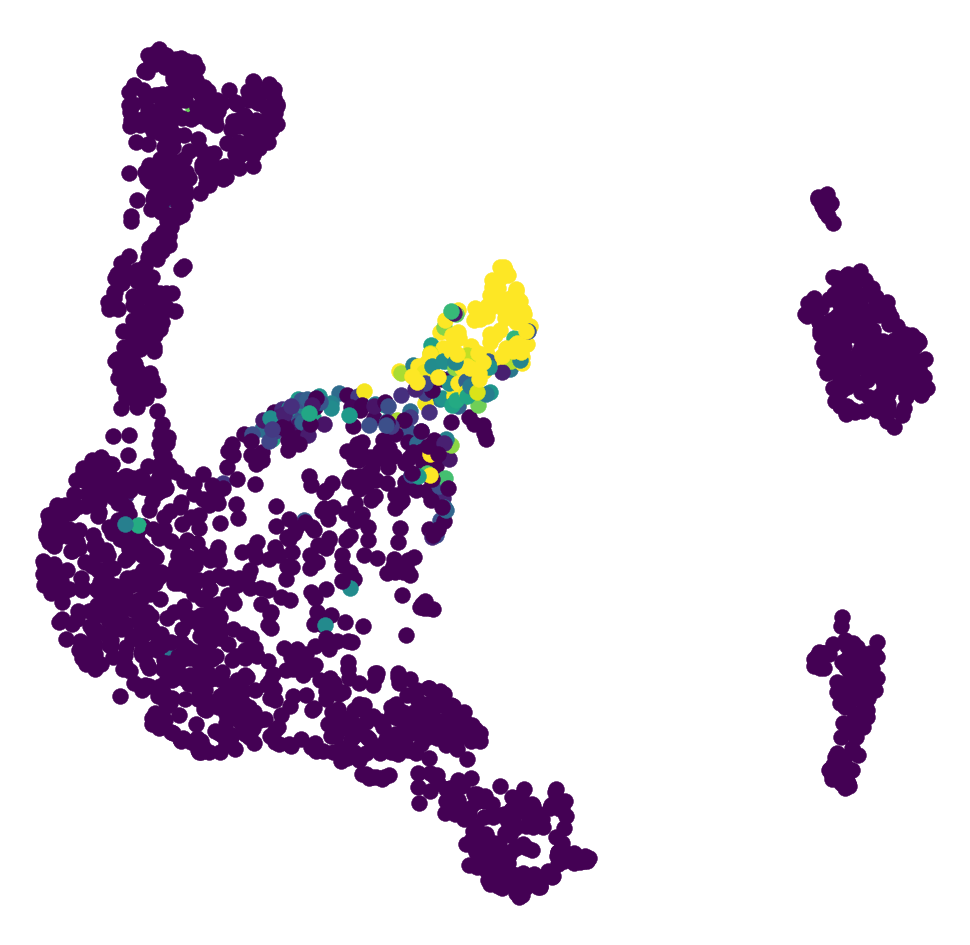

In [262]:
data = AP_Krts_score.loc['co']
cells = cl_c_ANA
tsne = umap_ANA.ix[cells.index]
cmap = plt.cm.viridis
time = cells_stage
markers = markers_time
vmin = 0#np.percentile(data, 5)
vmax = np.percentile(data, 95)

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(tsne['x']), np.max(tsne['x'])
y_min, y_max = np.min(tsne['y']), np.max(tsne['y'])
x_diff, y_diff = x_max - x_min, y_max - y_min

pad = 2.0

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_min * (x_diff / y_diff) - pad, y_max * (x_diff / y_diff) + pad)

if x_diff < y_diff:
    xlim = (x_min * (y_diff/x_diff) - pad, x_max * (y_diff/x_diff) + pad)
    ylim = (y_min - pad, y_max + pad)

text_pad = 2
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

remove_ticks(ax1)

for ix in tsne.index:

    ax1.scatter(tsne.ix[ix,'x'],
                tsne.ix[ix,'y'], 
                s = 250,
                linewidth = 0.5,
                c = cmap((data[ix] - vmin) / (vmax - vmin)),
                edgecolor=cmap((data[ix] - vmin) / (vmax - vmin)), 
                marker = markers[time[ix]])

clean_axis(ax1)

figname = 'v1.5_Fig3_AP_ANA_co_nb.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

/Users/simjoo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


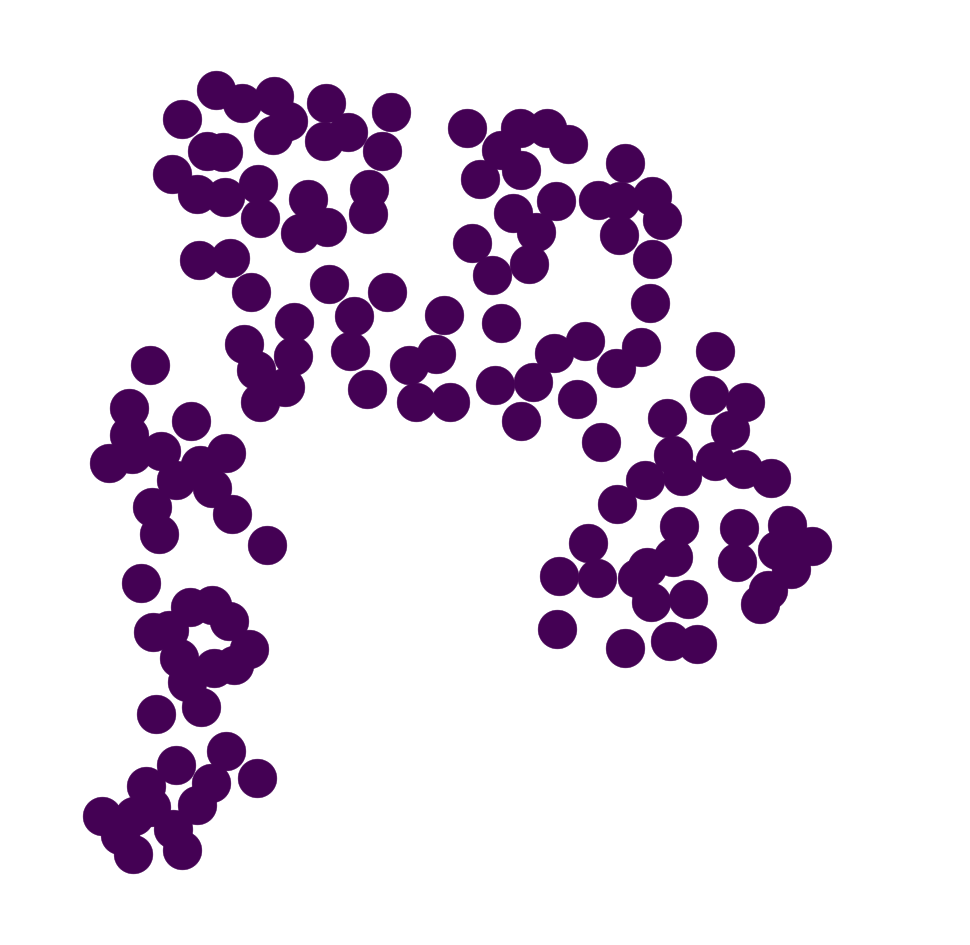

In [263]:
data = AP_Krts_score.loc['co']
cells = cl_c_ANA
tsne = umap_ANA_IRS.ix[cells.index]
cmap = plt.cm.viridis
time = cells_stage
markers = markers_time
vmin = 0#np.percentile(data, 5)
vmax = np.percentile(data, 95)

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(tsne['x']), np.max(tsne['x'])
y_min, y_max = np.min(tsne['y']), np.max(tsne['y'])
x_diff, y_diff = x_max - x_min, y_max - y_min

pad = 2.0

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_min * (x_diff / y_diff) - pad, y_max * (x_diff / y_diff) + pad)

if x_diff < y_diff:
    xlim = (x_min * (y_diff/x_diff) - pad, x_max * (y_diff/x_diff) + pad)
    ylim = (y_min - pad, y_max + pad)

text_pad = 2
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

remove_ticks(ax1)

for ix in tsne.index:

    ax1.scatter(tsne.ix[ix,'x'],
                tsne.ix[ix,'y'], 
                s = 1500,
                linewidth = 0.5,
                c = cmap((data[ix] - vmin) / (vmax - vmin)),
                edgecolor=cmap((data[ix] - vmin) / (vmax - vmin)), 
                marker = markers[time[ix]])

clean_axis(ax1)

figname = 'v1.5_Fig3_AP_ANA_IRS_co_nb.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

### Medulla

/Users/simjoo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


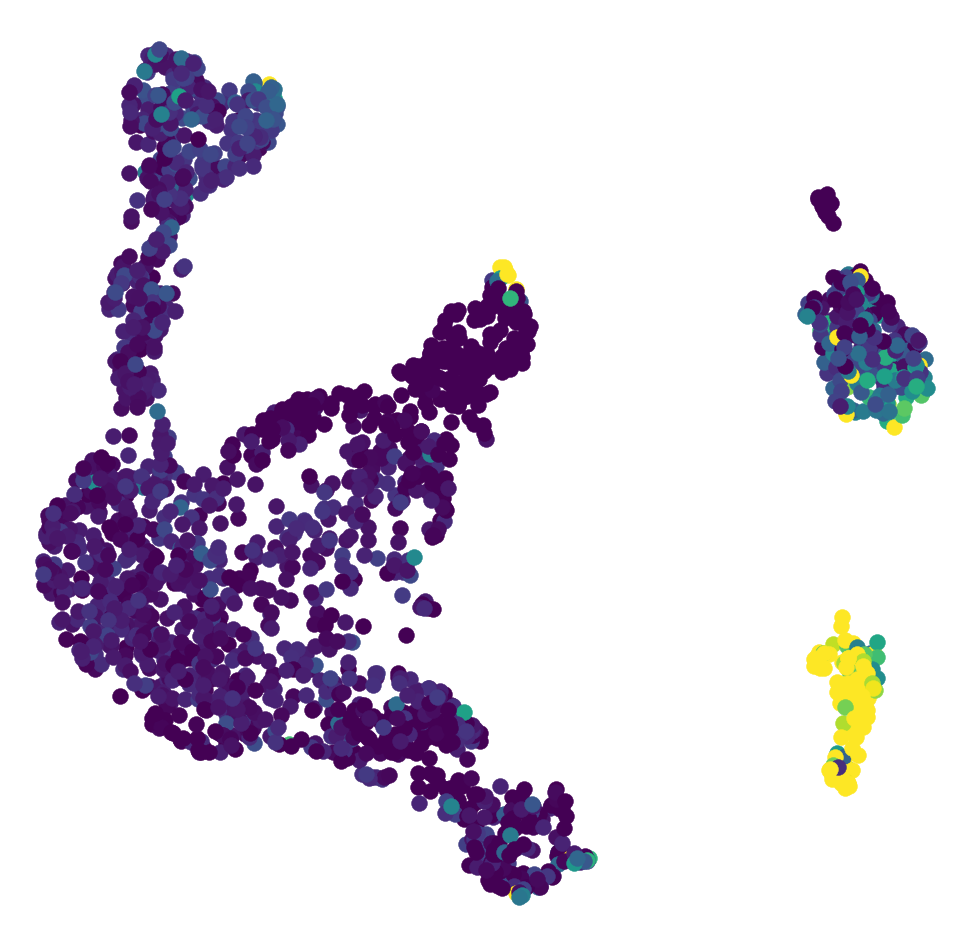

In [264]:
data = AP_Krts_score.loc['med']
cells = cl_c_ANA
tsne = umap_ANA.ix[cells.index]
cmap = plt.cm.viridis
time = cells_stage
markers = markers_time
vmin = 0#np.percentile(data, 5)
vmax = np.percentile(data, 95)

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(tsne['x']), np.max(tsne['x'])
y_min, y_max = np.min(tsne['y']), np.max(tsne['y'])
x_diff, y_diff = x_max - x_min, y_max - y_min

pad = 2.0

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_min * (x_diff / y_diff) - pad, y_max * (x_diff / y_diff) + pad)

if x_diff < y_diff:
    xlim = (x_min * (y_diff/x_diff) - pad, x_max * (y_diff/x_diff) + pad)
    ylim = (y_min - pad, y_max + pad)

text_pad = 2
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

remove_ticks(ax1)

for ix in tsne.index:

    ax1.scatter(tsne.ix[ix,'x'],
                tsne.ix[ix,'y'], 
                s = 250,
                linewidth = 0.5,
                c = cmap((data[ix] - vmin) / (vmax - vmin)),
                edgecolor=cmap((data[ix] - vmin) / (vmax - vmin)), 
                marker = markers[time[ix]])

clean_axis(ax1)

figname = 'v1.5_Fig3_AP_ANA_med_nb.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

/Users/simjoo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


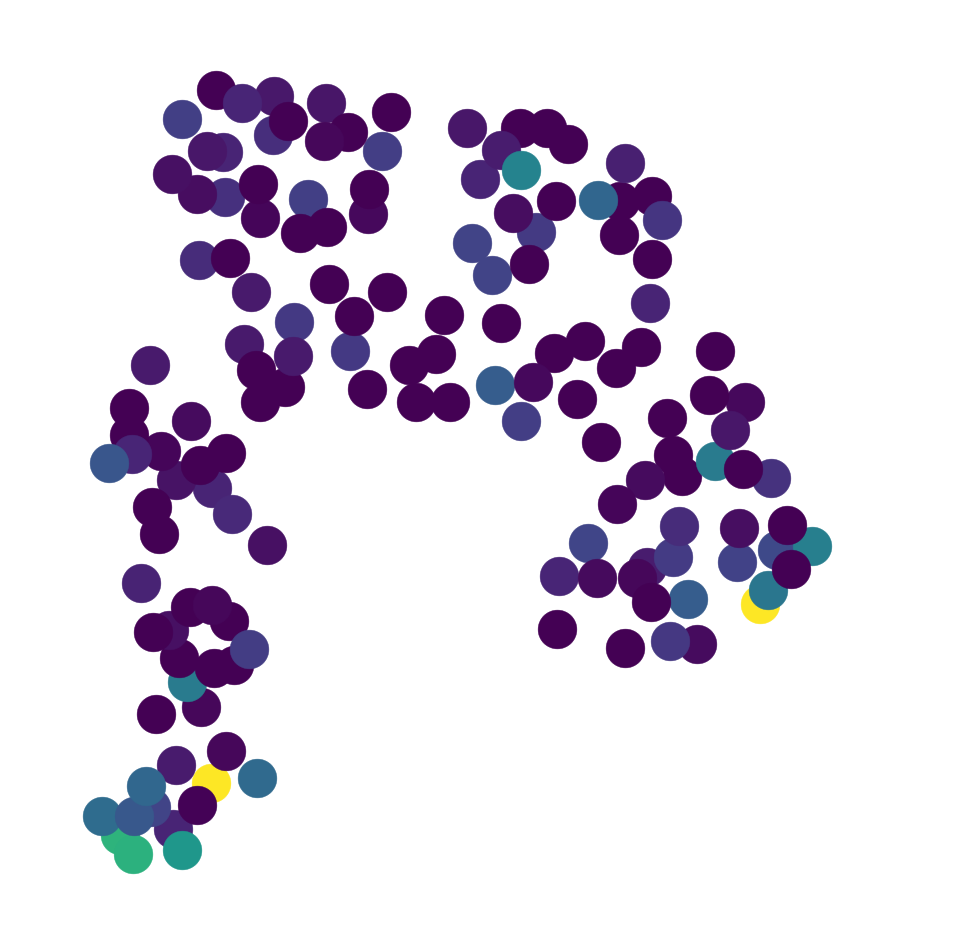

In [265]:
data = AP_Krts_score.loc['med']
cells = cl_c_ANA
tsne = umap_ANA_IRS.ix[cells.index]
cmap = plt.cm.viridis
time = cells_stage
markers = markers_time
vmin = 0#np.percentile(data, 5)
vmax = np.percentile(data, 95)

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(tsne['x']), np.max(tsne['x'])
y_min, y_max = np.min(tsne['y']), np.max(tsne['y'])
x_diff, y_diff = x_max - x_min, y_max - y_min

pad = 2.0

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_min * (x_diff / y_diff) - pad, y_max * (x_diff / y_diff) + pad)

if x_diff < y_diff:
    xlim = (x_min * (y_diff/x_diff) - pad, x_max * (y_diff/x_diff) + pad)
    ylim = (y_min - pad, y_max + pad)

text_pad = 2
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

remove_ticks(ax1)

for ix in tsne.index:

    ax1.scatter(tsne.ix[ix,'x'],
                tsne.ix[ix,'y'], 
                s = 1500,
                linewidth = 0.5,
                c = cmap((data[ix] - vmin) / (vmax - vmin)),
                edgecolor=cmap((data[ix] - vmin) / (vmax - vmin)), 
                marker = markers[time[ix]])

clean_axis(ax1)

figname = 'v1.5_Fig3_AP_ANA_IRS_med_nb.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

# Cell cycle stage

In [266]:
Counter(cc_score_v2.loc[cl_c_ANA.index])

Counter({'S': 459, 'G1': 1047, 'G2M': 468})

/Users/simjoo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:44: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


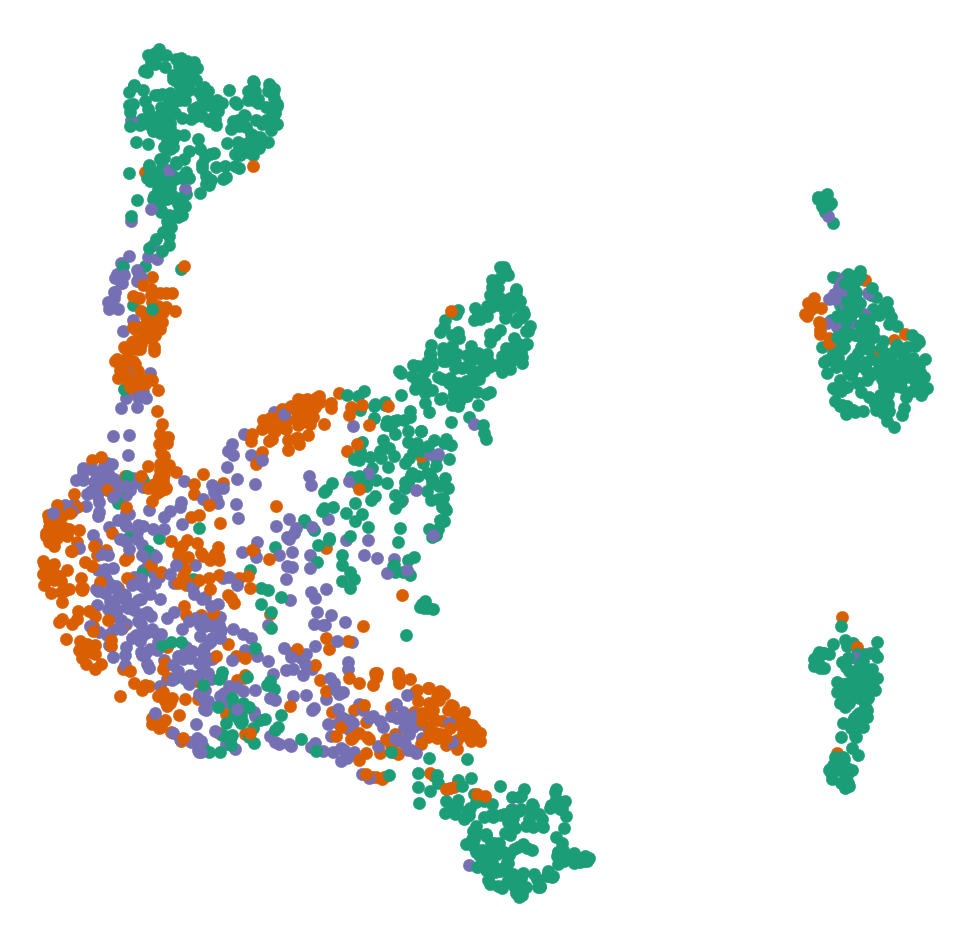

In [267]:
data = cc_score_v2.loc[cl_c_ANA.index]
cells = cl_c_ANA
tsne = umap_ANA.ix[cells.index]
cmap = {'G1':'#1b9e77','G2M':'#d95f02','S':'#7570b3'}
time = cells_stage
markers = markers_time

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(tsne['x']), np.max(tsne['x'])
y_min, y_max = np.min(tsne['y']), np.max(tsne['y'])
x_diff, y_diff = x_max - x_min, y_max - y_min

pad = 2.0

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_min * (x_diff / y_diff) - pad, y_max * (x_diff / y_diff) + pad)

if x_diff < y_diff:
    xlim = (x_min * (y_diff/x_diff) - pad, x_max * (y_diff/x_diff) + pad)
    ylim = (y_min - pad, y_max + pad)

text_pad = 2
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

remove_ticks(ax1)

for ix in tsne.index:

    ax1.scatter(tsne.ix[ix,'x'],
                tsne.ix[ix,'y'], 
                s = 150,
                linewidth = 0.5,
                c = cmap[data[ix]],
                edgecolor=cmap[data[ix]], 
                marker = markers[time[ix]])

clean_axis(ax1)

figname = 'v1.5_Fig3_ANA_CC_class.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

/Users/simjoo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:44: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


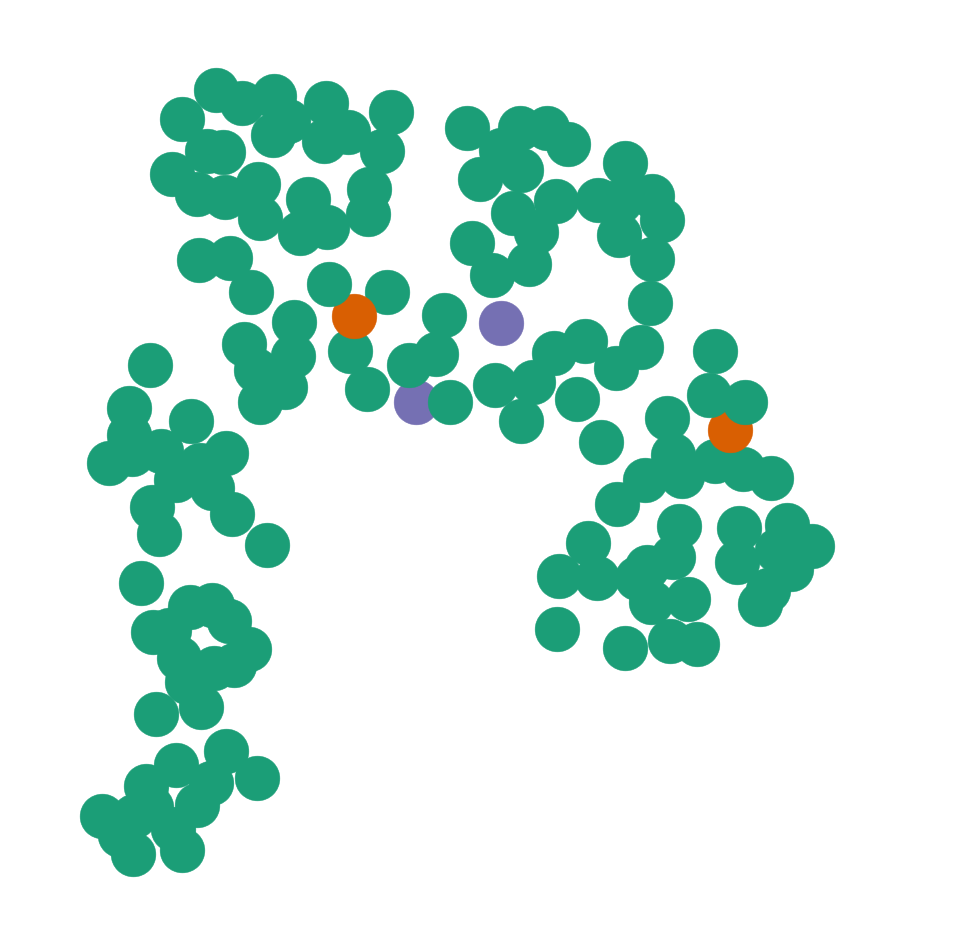

In [268]:
data = cc_score_v2.loc[cl_c_ANA_IRS.index]
cells = cl_c_ANA_IRS
tsne = umap_ANA_IRS.ix[cells.index]
cmap = {'G1':'#1b9e77','G2M':'#d95f02','S':'#7570b3'}
time = cells_stage
markers = markers_time

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(tsne['x']), np.max(tsne['x'])
y_min, y_max = np.min(tsne['y']), np.max(tsne['y'])
x_diff, y_diff = x_max - x_min, y_max - y_min

pad = 2.0

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_min * (x_diff / y_diff) - pad, y_max * (x_diff / y_diff) + pad)

if x_diff < y_diff:
    xlim = (x_min * (y_diff/x_diff) - pad, x_max * (y_diff/x_diff) + pad)
    ylim = (y_min - pad, y_max + pad)

text_pad = 2
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

remove_ticks(ax1)

for ix in tsne.index:

    ax1.scatter(tsne.ix[ix,'x'],
                tsne.ix[ix,'y'], 
                s = 2000,
                linewidth = 0.5,
                c = cmap[data[ix]],
                edgecolor=cmap[data[ix]], 
                marker = markers[time[ix]])

clean_axis(ax1)

figname = 'v1.5_Fig3_ANA_IRS_CC_class.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

# Cell-cell distance

In [269]:
seq_sel_ANA = loadData_v1(path_output, exp_id, 'seq_sel_ANA', 'DataFrame')


Dropping unexpressed genes from dataset

After mean expression cutoff of 0.025, 7218 genes remain

After high variance feature selection, 500 genes remain


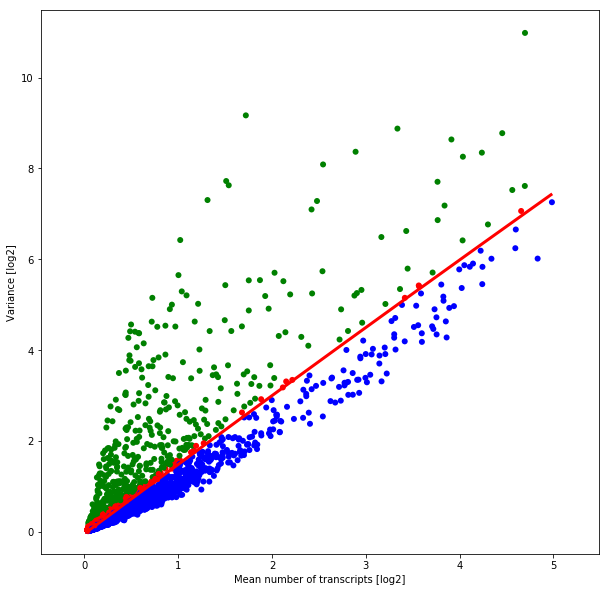

In [411]:
seq_sel_ANA_IRS = select_features_log2_var_polyfit_v2(seqN[cl_c_ANA_IRS.index], 0.025, 500)

In [270]:
seq_sel_ANA_pca, dist_c_ANA = dim_reduc_pca(seq_sel_ANA, 20, 'euclidean', inverse_transform = False)

In [412]:
seq_sel_ANA_IRS_pca, dist_c_ANA_IRS = dim_reduc_pca(seq_sel_ANA_IRS, 2, 'euclidean', inverse_transform = False)

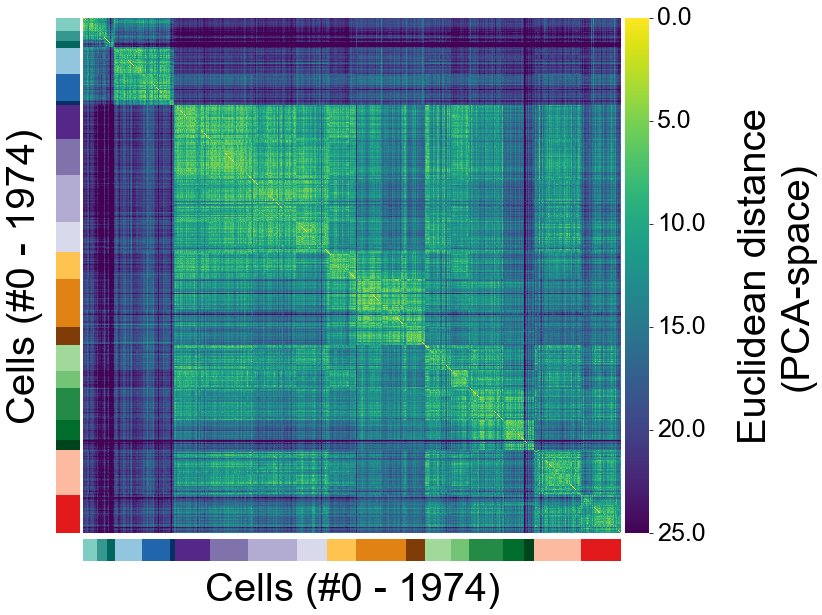

In [271]:
groups = cl_c_ANA
dist = dist_c_ANA
dist = dist.loc[groups.index, groups.index]
vmin = 0
vmax = 25
cmap = plt.cm.viridis_r
cmap_groups = cmap_2nd

#generate figure

fig = plt.figure(facecolor = 'w', figsize = (10.625, 10))
gs = plt.GridSpec(nrows = 2, ncols = 3, wspace=0.02, hspace=0.02, width_ratios=[0.5 , 11.25, 0.5], height_ratios=[11.25, 0.5])

#plot heatmap

axHM = plt.subplot(gs[0, 1])

axHM.matshow(dist, cmap = cmap, aspect = 'auto', vmin = vmin, vmax = vmax, interpolation = None)
    
axHM.set_xlabel('Cells (#0 - %s)' % len(groups), family = 'Arial', fontsize = 40)
axHM.set_ylabel('Cells (#0 - %s)' % len(groups), family = 'Arial', fontsize = 40)

axHM.xaxis.set_label_coords(0.5, -0.075)
axHM.yaxis.set_label_coords(-0.075, 0.5)
    
axHM.set_yticks([])

clean_axis(axHM)

#plot left sample groups

axSG1 = plt.subplot(gs[0, 0])

axSG1.set_ylim(len(groups), 0)

for pos, gr in enumerate(groups):
    axSG1.axhspan(pos, pos+1, color=cmap_groups[gr])
    
remove_ticks(axSG1)
clean_axis(axSG1)

#plot bottom sample groups

axSG2 = plt.subplot(gs[1, 1])

axSG2.set_xlim(0, len(groups))

for pos, gr in enumerate(groups):
    axSG2.axvspan(pos, pos+1, color=cmap_groups[gr])

remove_ticks(axSG2)
clean_axis(axSG2)

#plot label

axLabel = plt.subplot(gs[0,2])

axLabel.matshow(np.matrix(np.arange(vmin, vmax, 0.1)).T,
                cmap = cmap, aspect = 'auto', vmin = vmin, vmax = vmax)

axLabel.xaxis.set_ticks([])
axLabel.yaxis.set_ticks_position('right')

clean_axis(axLabel)

axLabel.set_yticks(np.linspace(axLabel.get_ylim()[0], axLabel.get_ylim()[1], 6))
axLabel.set_yticklabels(np.linspace(vmax, vmin, 6), family = 'Arial', fontsize = 25, va = 'center')
axLabel.tick_params(axis='y', which='major', pad=5)

axLabel.set_ylabel('Euclidean distance\n(PCA-space)', family = 'Arial', fontsize = 40)
axLabel.yaxis.set_label_coords(8, 0.5)

figname = 'v1.5_FigS4_cell_cell_distance_ANA.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

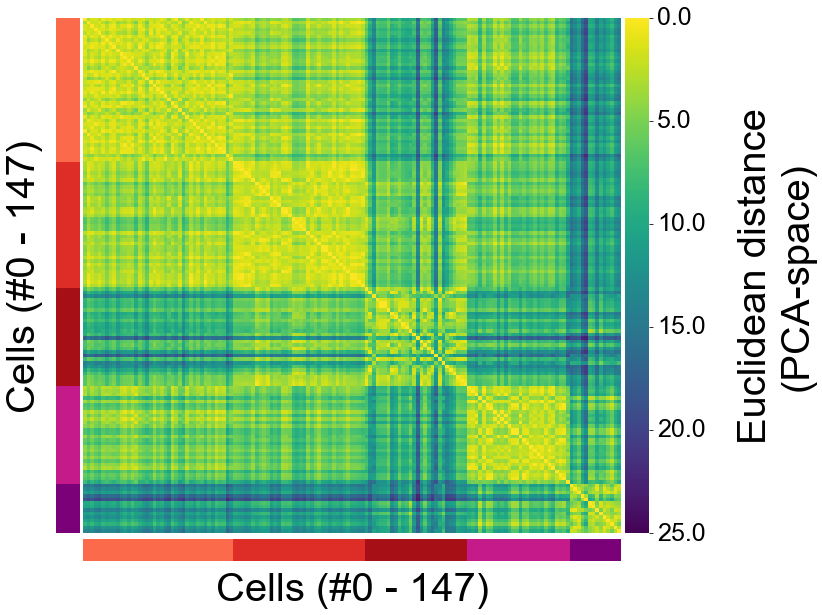

In [413]:
groups = cl_c_ANA_IRS
dist = dist_c_ANA_IRS
dist = dist.loc[groups.index, groups.index]
vmin = 0
vmax = 25
cmap = plt.cm.viridis_r
cmap_groups = cmap_2nd

#generate figure

fig = plt.figure(facecolor = 'w', figsize = (10.625, 10))
gs = plt.GridSpec(nrows = 2, ncols = 3, wspace=0.02, hspace=0.02, width_ratios=[0.5 , 11.25, 0.5], height_ratios=[11.25, 0.5])

#plot heatmap

axHM = plt.subplot(gs[0, 1])

axHM.matshow(dist, cmap = cmap, aspect = 'auto', vmin = vmin, vmax = vmax, interpolation = None)
    
axHM.set_xlabel('Cells (#0 - %s)' % len(groups), family = 'Arial', fontsize = 40)
axHM.set_ylabel('Cells (#0 - %s)' % len(groups), family = 'Arial', fontsize = 40)

axHM.xaxis.set_label_coords(0.5, -0.075)
axHM.yaxis.set_label_coords(-0.075, 0.5)
    
axHM.set_yticks([])

clean_axis(axHM)

#plot left sample groups

axSG1 = plt.subplot(gs[0, 0])

axSG1.set_ylim(len(groups), 0)

for pos, gr in enumerate(groups):
    axSG1.axhspan(pos, pos+1, color=cmap_groups[gr])
    
remove_ticks(axSG1)
clean_axis(axSG1)

#plot bottom sample groups

axSG2 = plt.subplot(gs[1, 1])

axSG2.set_xlim(0, len(groups))

for pos, gr in enumerate(groups):
    axSG2.axvspan(pos, pos+1, color=cmap_groups[gr])

remove_ticks(axSG2)
clean_axis(axSG2)

#plot label

axLabel = plt.subplot(gs[0,2])

axLabel.matshow(np.matrix(np.arange(vmin, vmax, 0.1)).T,
                cmap = cmap, aspect = 'auto', vmin = vmin, vmax = vmax)

axLabel.xaxis.set_ticks([])
axLabel.yaxis.set_ticks_position('right')

clean_axis(axLabel)

axLabel.set_yticks(np.linspace(axLabel.get_ylim()[0], axLabel.get_ylim()[1], 6))
axLabel.set_yticklabels(np.linspace(vmax, vmin, 6), family = 'Arial', fontsize = 25, va = 'center')
axLabel.tick_params(axis='y', which='major', pad=5)

axLabel.set_ylabel('Euclidean distance\n(PCA-space)', family = 'Arial', fontsize = 40)
axLabel.yaxis.set_label_coords(8, 0.5)

figname = 'v1.5_FigS4_cell_cell_distance_ANA_IRS.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

# Comparison to Seurat

In [43]:
cl_c_ANA_S = pd.read_csv('%s/Seurat/TenX_2ndLevel_ANA_ClusterIdentity.txt' % path_output, sep = '\t', header = None, index_col = 0, 
                           low_memory = False, squeeze = True)

In [44]:
tsne_ANA_S = pd.read_csv('%s/Seurat/TenX_2ndLevel_ANA_TSNEcoordinates.txt' % path_output, sep = '\t', index_col = 0, header = 0)
tsne_ANA_S.columns = ['x','y']

In [45]:
gr_sel = [7,5,0,2,8,1,9,3,4,6]
cl_c_ANA_S = AP_groups_reorder_v2(cl_c_ANA_S, gr_sel)

In [46]:
cmap_ANA_Seurat = {0:'#6a3d9a',
                   1:'#cc4c02',
                   2:'#cab2d6',
                   3:'#33a02c',
                   4:'#fb9a99',
                   5:'#4575b4',
                   6:'#e31a1c',
                   7:'#35978f',
                   8:'#fec44f',
                   9:'#b2df8a'}

## tSNE

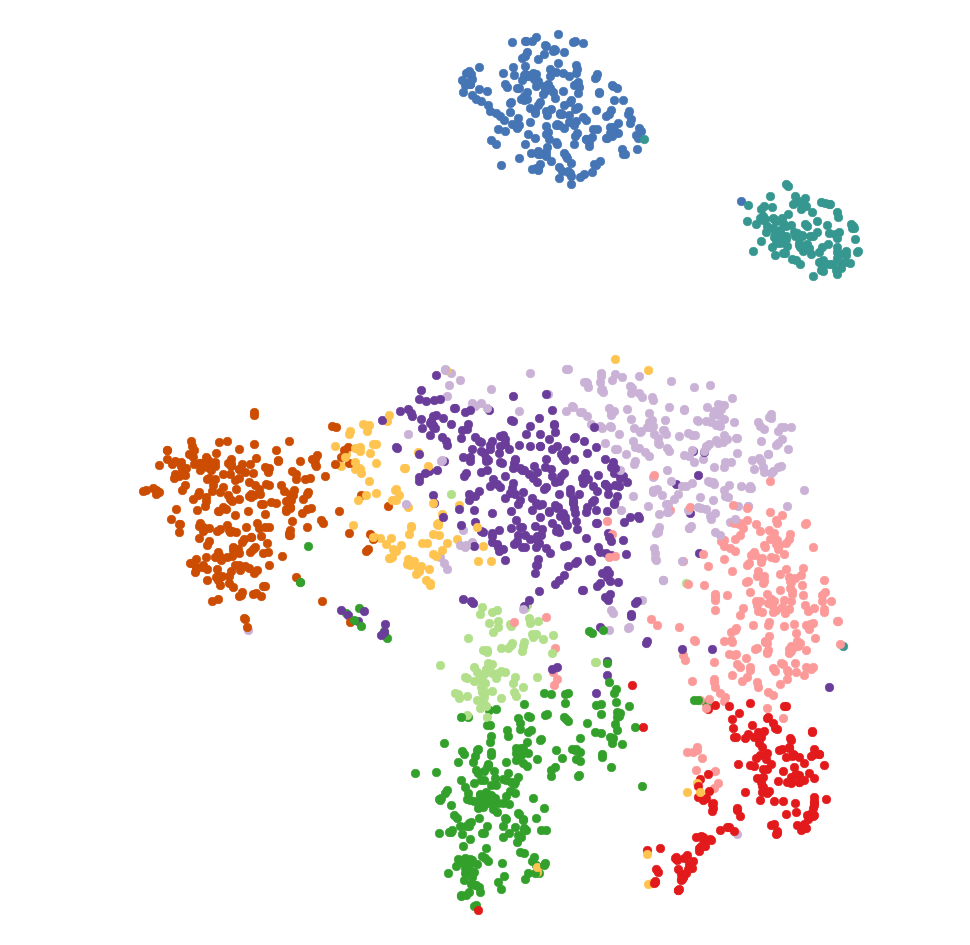

In [276]:
cells = cl_c_ANA_S
tsne = tsne_ANA_S.loc[cells.index]
cmap = cmap_ANA_Seurat
time = cells_stage
markers = markers_time

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(tsne['x']), np.max(tsne['x'])
y_min, y_max = np.min(tsne['y']), np.max(tsne['y'])
x_diff, y_diff = x_max - x_min, y_max - y_min

pad = 2.0

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_min * (x_diff / y_diff) - pad, y_max * (x_diff / y_diff) + pad)

if x_diff < y_diff:
    xlim = (x_min * (y_diff/x_diff) - pad, x_max * (y_diff/x_diff) + pad)
    ylim = (y_min - pad, y_max + pad)

text_pad = 2
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

remove_ticks(ax1)

index = list(tsne.index)
np.random.shuffle(index)

for ix in index:

    ax1.scatter(tsne.loc[ix,'x'],
                tsne.loc[ix,'y'], 
                s = 75,
                linewidth = 0.5,
                c = cmap[cells[ix]],
                edgecolor=cmap[cells[ix]], 
                marker = markers[time[ix]])

clean_axis(ax1)

figname = 'v1.5_FigS3_tSNE_ANA_Seurat.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

## Cell-cell-distance

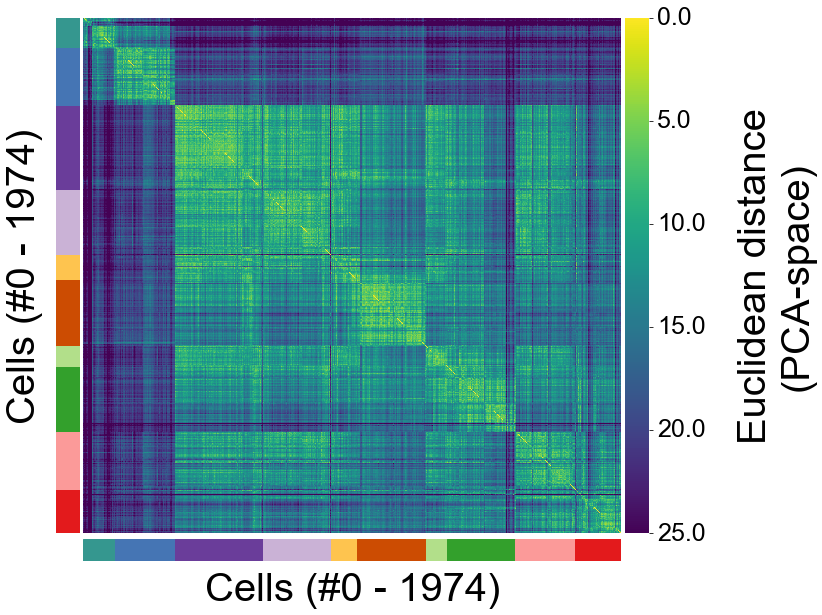

In [277]:
groups = cl_c_ANA_S
dist = dist_c_ANA
dist = dist.loc[groups.index, groups.index]
vmin = 0
vmax = 25
cmap = plt.cm.viridis_r
cmap_groups = cmap_ANA_Seurat

#generate figure

fig = plt.figure(facecolor = 'w', figsize = (10.625, 10))
gs = plt.GridSpec(nrows = 2, ncols = 3, wspace=0.02, hspace=0.02, width_ratios=[0.5 , 11.25, 0.5], height_ratios=[11.25, 0.5])

#plot heatmap

axHM = plt.subplot(gs[0, 1])

axHM.matshow(dist, cmap = cmap, aspect = 'auto', vmin = vmin, vmax = vmax, interpolation = None)
    
axHM.set_xlabel('Cells (#0 - %s)' % len(groups), family = 'Arial', fontsize = 40)
axHM.set_ylabel('Cells (#0 - %s)' % len(groups), family = 'Arial', fontsize = 40)

axHM.xaxis.set_label_coords(0.5, -0.075)
axHM.yaxis.set_label_coords(-0.075, 0.5)
    
axHM.set_yticks([])

clean_axis(axHM)

#plot left sample groups

axSG1 = plt.subplot(gs[0, 0])

axSG1.set_ylim(len(groups), 0)

for pos, gr in enumerate(groups):
    axSG1.axhspan(pos, pos+1, color=cmap_groups[gr])
    
remove_ticks(axSG1)
clean_axis(axSG1)

#plot bottom sample groups

axSG2 = plt.subplot(gs[1, 1])

axSG2.set_xlim(0, len(groups))

for pos, gr in enumerate(groups):
    axSG2.axvspan(pos, pos+1, color=cmap_groups[gr])

remove_ticks(axSG2)
clean_axis(axSG2)

#plot label

axLabel = plt.subplot(gs[0,2])

axLabel.matshow(np.matrix(np.arange(vmin, vmax, 0.1)).T,
                cmap = cmap, aspect = 'auto', vmin = vmin, vmax = vmax)

axLabel.xaxis.set_ticks([])
axLabel.yaxis.set_ticks_position('right')

clean_axis(axLabel)

axLabel.set_yticks(np.linspace(axLabel.get_ylim()[0], axLabel.get_ylim()[1], 6))
axLabel.set_yticklabels(np.linspace(vmax, vmin, 6), family = 'Arial', fontsize = 25, va = 'center')
axLabel.tick_params(axis='y', which='major', pad=5)

axLabel.set_ylabel('Euclidean distance\n(PCA-space)', family = 'Arial', fontsize = 40)
axLabel.yaxis.set_label_coords(8, 0.5)

figname = 'v1.5_FigS4_cell_cell_distance_ANA_Seurat.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

## Comparison

In [51]:
def heatmap_diag(hm):
    
    import operator
    
    #get dict and sort
    
    d = {}
    
    for r in hm.index:
        for c in hm.columns:
            d[(r,c)] = hm.loc[r,c]
            
    r_sort, c_sort = [], []
            
    d = sorted(d.items(), key=operator.itemgetter(1), reverse = True)
    
    for i in d:
        if i[0][0] not in r_sort and i[0][1] not in c_sort:
            r_sort += [i[0][0]]
            c_sort += [i[0][1]]
    
    r_sort += [r for r in hm.index if r not in r_sort]
    c_sort += [c for c in hm.columns if c not in c_sort]
    
    return hm.loc[r_sort, c_sort]

In [52]:
def seurat_vs_AP(cl_ix, cl_col, return_counts = False):
    
    #define output
    
    output_perc = pd.DataFrame(index = return_unique(cl_ix), columns = return_unique(cl_col))
    output_count = pd.DataFrame(index = return_unique(cl_ix), columns = return_unique(cl_col))
    
    for col in return_unique(cl_col):
        ix_col = set(cl_col[cl_col==col].index)
        
        for row in return_unique(cl_ix):
            ix_row = set(cl_ix[cl_ix==row].index)
            
            output_perc.loc[row, col] = float(len(ix_row&ix_col)) / float(len(ix_row))
            output_count.loc[row, col] = float(len(ix_row&ix_col))
    
    if return_counts == True:
        return heatmap_diag(output_perc), output_count
    else:    
        return heatmap_diag(output)

In [53]:
seurat_vs_AP_ANA_perc, seurat_vs_AP_ANA_count = seurat_vs_AP(cl_c_ANA, cl_c_ANA_S, True)

In [54]:
from sklearn.metrics import adjusted_rand_score as rand

In [55]:
rand_ANA = rand(cl_c_ANA, cl_c_ANA_S)

In [56]:
rand_ANA

0.5857883862973018

In [57]:
overlap_ANA_ax0 = seurat_vs_AP_ANA_count.max(axis=0).sum() / seurat_vs_AP_ANA_count.sum().sum()
overlap_ANA_ax1 = seurat_vs_AP_ANA_count.max(axis=1).sum() / seurat_vs_AP_ANA_count.sum().sum()

In [58]:
print(overlap_ANA_ax0, overlap_ANA_ax1)

0.5283687943262412 0.8191489361702128


In [288]:
ix_sel = ['ANA - 1','ANA - 21','ANA - 0',
          'ANA - 2','ANA - 3','ANA - 20',
          'ANA - 4','ANA - 5',
          'ANA - 11','ANA - 10','ANA - 7','ANA - 14',
          'ANA - 8',
          'ANA - 13','ANA - 16',
          'ANA - 18',
          'ANA - 6',
          'ANA - 15','ANA - 12',
          'ANA - 17']

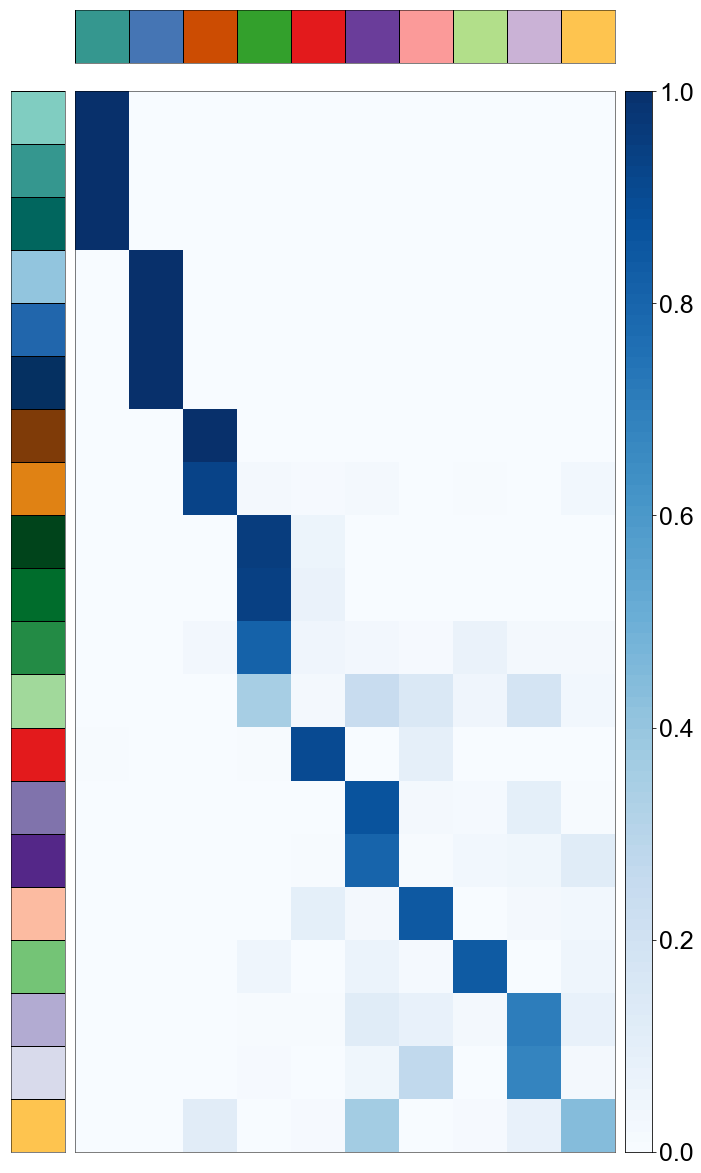

In [289]:
data = seurat_vs_AP_ANA_perc.loc[ix_sel]

cmap_ix = cmap_2nd
cmap_col = cmap_ANA_Seurat

#generate figure

fig = plt.figure(facecolor = 'w', figsize = (len(data.columns) + 1.5, len(data.index) + 1))
gs = plt.GridSpec(nrows = 2, ncols = 3, 
                  wspace=0.05, width_ratios=[1,1*len(data.columns),0.5], 
                  hspace=0.05, height_ratios=[1,1*len(data.index)])

#plot population colors

ax = plt.subplot(gs[1,0])

ax.set_ylim(len(data.index), 0)

for pos, gr in enumerate(data.index):
    ax.axhspan(pos, pos + 1, color = cmap_ix[gr])
    ax.axhline(pos, lw = 1, color = 'k')
    
remove_ticks(ax)

ax = plt.subplot(gs[0,1])

ax.set_xlim(0, len(data.columns))

for pos, gr in enumerate(data.columns):
    ax.axvspan(pos, pos + 1, color = cmap_col[gr])
    ax.axvline(pos, lw = 1, color = 'k')
    
remove_ticks(ax)

#plot data

ax = plt.subplot(gs[1,1])

ax.imshow(data.astype(float),
          cmap = plt.cm.Blues,
          aspect = 'auto',
          interpolation = 'nearest',
          vmin = 0, vmax = 1)

remove_ticks(ax)

#plot legend

ax = plt.subplot(gs[1,2])

ax.set_ylim(0,1)
ax.set_xticks([])

ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], family = 'Arial', fontsize = 25)
ax.yaxis.set_ticks_position('right')

for pos in np.arange(0,1,0.01):
    ax.axhspan(pos, pos + 0.01, color = plt.cm.Blues(pos))
    
figname = 'v1.5_FigS4_seurat_AP_comp_ANA.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

# Differentially expressed genes - main clusterings

## Import scripts and data

In [35]:
def MWU_get_binarized(mwu_pval, cutoff, neglog = True):
    
    output = pd.DataFrame(index = mwu_pval.index, columns = mwu_pval.columns).fillna(0)
    
    if neglog == True:
        output[mwu_pval>=cutoff] = 1
    else:
        output[mwu_pval<cutoff] = 1
    
    return output

In [36]:
def MWU_extract_genes_(mwu_pval, mwu_bin, number = 10, neglog = True):
    
    output = pd.DataFrame(index = range(number), columns = mwu_bin.columns).fillna('None')
    
    for gr in mwu_bin.columns:
        g_bin = mwu_bin[gr][mwu_bin[gr]==1].index
        
        if neglog == True:
            g_sel = mwu_pval.loc[g_bin, gr].sort_values()[-number:].index[::-1]
            #return g_sel
        else:
            g_sel = mwu_pval.loc[g_bin, gr].sort_values()[number:].index
            
        output.loc[range(len(g_sel)), gr] = g_sel
        
    return output

## Compared to average

In [37]:
MWU_av_ANA[MWU_av_ANA==np.inf] = 307

In [38]:
MWU_av_ANA_bin = MWU_get_binarized(MWU_av_ANA, -np.log10(0.001), neglog = True)

In [39]:
MWU_av_ANA_genes = MWU_extract_genes_(MWU_av_ANA, MWU_av_ANA_bin, number = 10, neglog = True)

In [41]:
gr_order_ANA = ['ANA - 1','ANA - 21','ANA - 0','ANA - 2','ANA - 3','ANA - 20',
                'ANA - 12','ANA - 15','ANA - 13','ANA - 16',
                'ANA - 18','ANA - 8',
                'ANA - 14','ANA - 6','ANA - 7','ANA - 10','ANA - 11',
                'ANA - 17','ANA - 5','ANA - 4']

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize

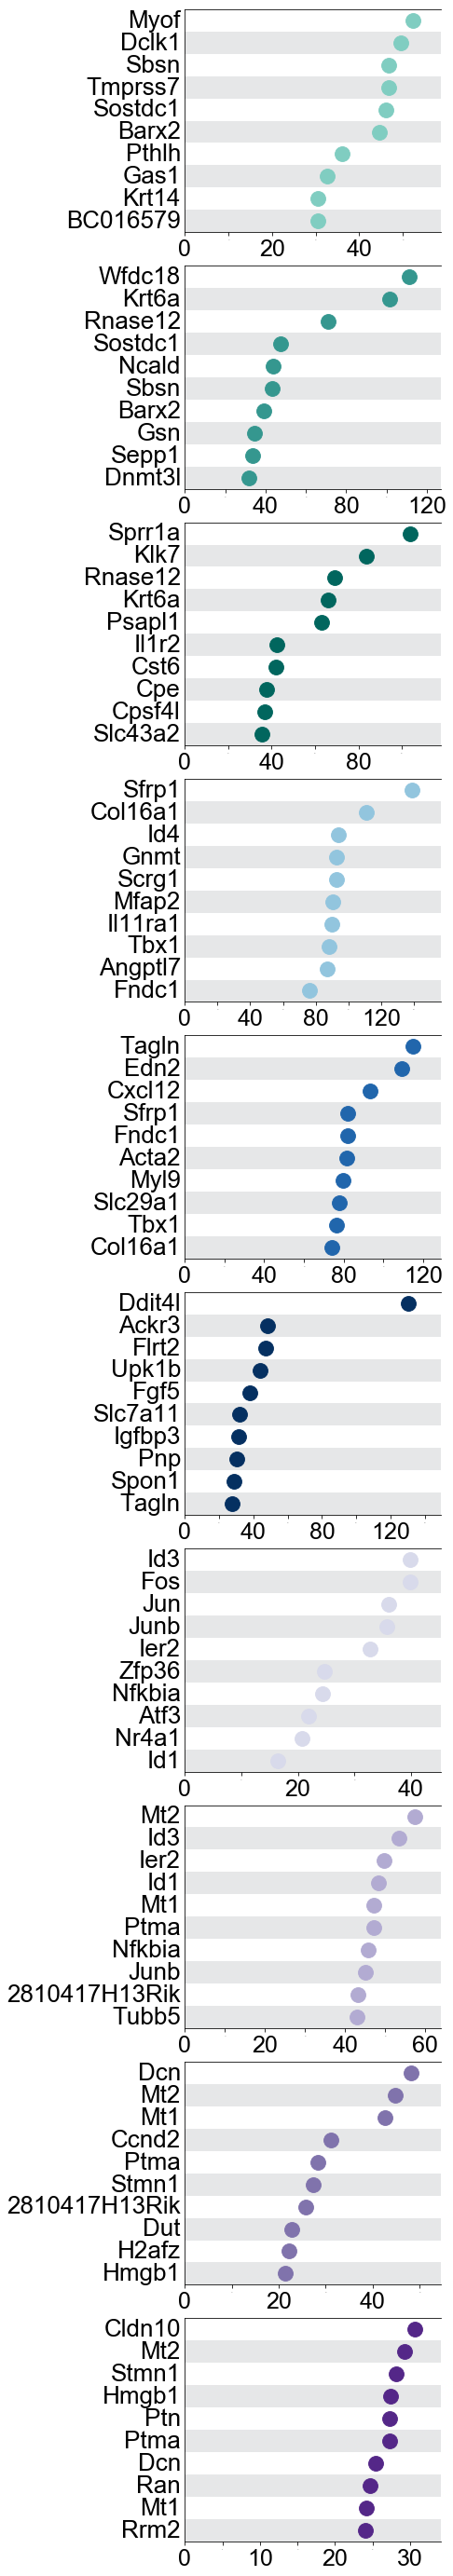

In [42]:
#define input variables

gr_order = gr_order_ANA[0:10]
genes = MWU_av_ANA_genes
L = len(genes.index)
pval = MWU_av_ANA
cmap = cmap_2nd

#initialize figure

height = 5 * len(gr_order)
width = 8

plt.figure(facecolor = 'w', figsize = (width, height))
gs = plt.GridSpec(len(gr_order), 2, hspace = 0.15, wspace = 0.0, width_ratios = [5,8])

#iterate through groups

for pos, gr in enumerate(gr_order):
    
    genes_tmp = [gene for gene in genes[gr].values if gene != 'None']
    
    #create gene name axis 
    
    ax0 = plt.subplot(gs[pos,0])
    ax0.set_ylim(L - 0.5, -0.5)
    clean_axis(ax0)
    
    #create violin plot axis
    
    ax1 = plt.subplot(gs[pos,1])
    
    ax1.spines['right'].set_color('none')

    ax1.set_ylim(L - 0.5, -0.5)
    ax1.yaxis.set_ticks_position('left')
    ax1.yaxis.set_ticks([])
    
    #iterate over genes
    
    for ix, g in enumerate(genes_tmp):
        ax0.text(0.975, ix, g, family = 'Arial', fontsize = 26, ha = 'right', va = 'center')
        
        #print background
        
        if ix % 2 == 0:
            ax1.axhspan(ix - 0.5, ix + 0.5, color = '#FFFFFF', zorder = 0)
            
        if ix % 2 == 1:
            ax1.axhspan(ix - 0.5, ix + 0.5, color = '#E6E7E8', zorder = 0)
            
        #print pvals
        
        ax1.scatter(pval.loc[g,gr], ix, marker = 'o', s = 250, color = cmap[gr])
        
    xlim = list(ax1.get_xlim())

    ax1.set_xlim(0, xlim[1] * 1.1)

    for ix, t in enumerate(ax1.xaxis.get_ticklabels()):
        if ix % 2 == 0:
            t.set_family('Arial')
            t.set_fontsize(25)
        else:
            t.set_fontsize(0)
            
figname = 'v1.5_FigS4_MWU_vs_av_ANA_1.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize

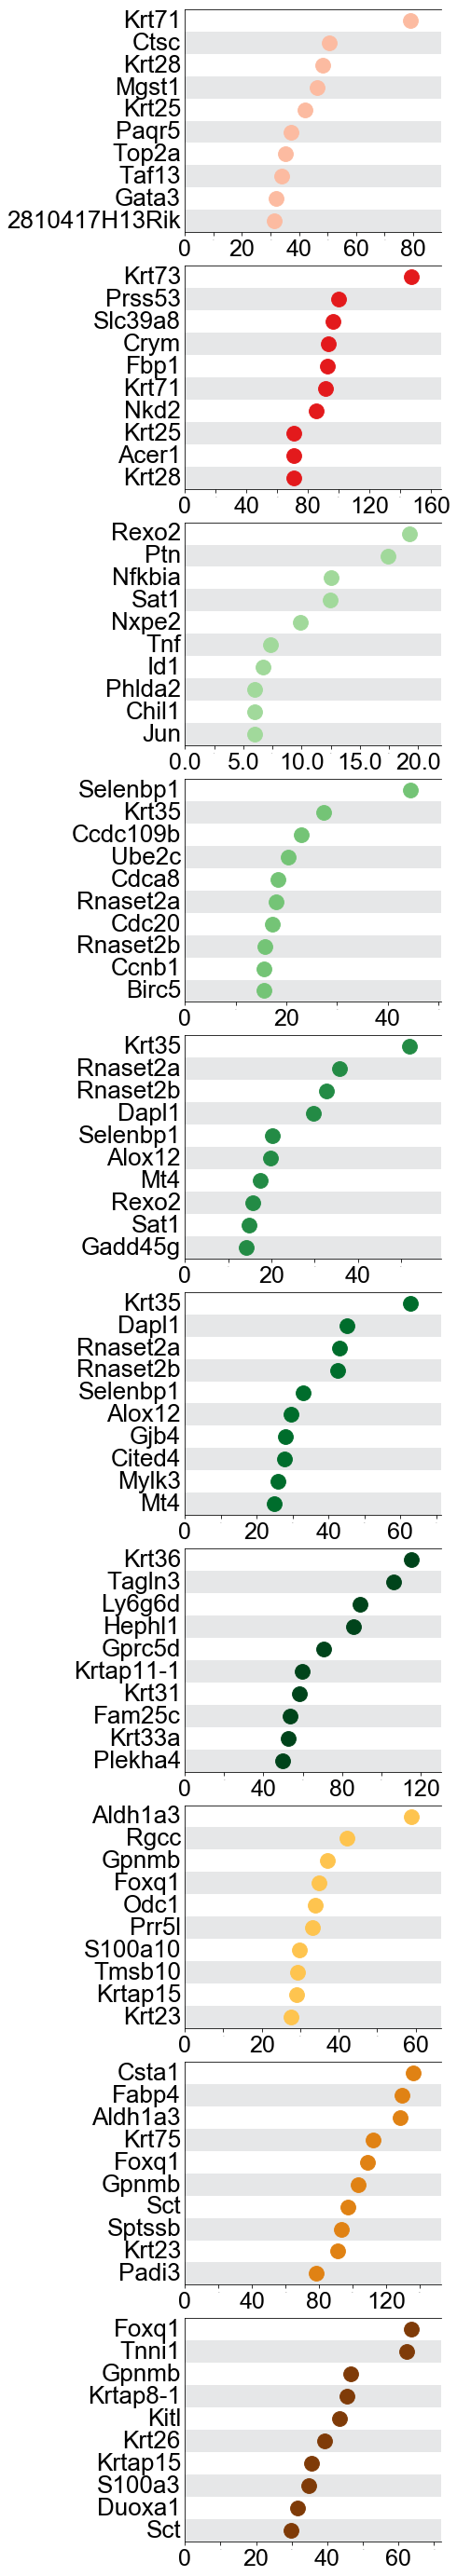

In [43]:
#define input variables

gr_order = gr_order_ANA[10:]
genes = MWU_av_ANA_genes
L = len(genes.index)
pval = MWU_av_ANA
cmap = cmap_2nd

#initialize figure

height = 5 * len(gr_order)
width = 8

plt.figure(facecolor = 'w', figsize = (width, height))
gs = plt.GridSpec(len(gr_order), 2, hspace = 0.15, wspace = 0.0, width_ratios = [5,8])

#iterate through groups

for pos, gr in enumerate(gr_order):
    
    genes_tmp = [gene for gene in genes[gr].values if gene != 'None']
    
    #create gene name axis 
    
    ax0 = plt.subplot(gs[pos,0])
    ax0.set_ylim(L - 0.5, -0.5)
    clean_axis(ax0)
    
    #create violin plot axis
    
    ax1 = plt.subplot(gs[pos,1])
    
    ax1.spines['right'].set_color('none')

    ax1.set_ylim(L - 0.5, -0.5)
    ax1.yaxis.set_ticks_position('left')
    ax1.yaxis.set_ticks([])
    
    #iterate over genes
    
    for ix, g in enumerate(genes_tmp):
        ax0.text(0.975, ix, g, family = 'Arial', fontsize = 26, ha = 'right', va = 'center')
        
        #print background
        
        if ix % 2 == 0:
            ax1.axhspan(ix - 0.5, ix + 0.5, color = '#FFFFFF', zorder = 0)
            
        if ix % 2 == 1:
            ax1.axhspan(ix - 0.5, ix + 0.5, color = '#E6E7E8', zorder = 0)
            
        #print pvals
        
        ax1.scatter(pval.loc[g,gr], ix, marker = 'o', s = 250, color = cmap[gr])
        
    xlim = list(ax1.get_xlim())

    ax1.set_xlim(0, xlim[1] * 1.1)

    for ix, t in enumerate(ax1.xaxis.get_ticklabels()):
        if ix % 2 == 0:
            t.set_family('Arial')
            t.set_fontsize(25)
        else:
            t.set_fontsize(0)
            
figname = 'v1.5_FigS4_MWU_vs_av_ANA_2.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

## Compared to groups

In [297]:
MWU_gr_ANA[MWU_gr_ANA==np.inf] = 307

In [298]:
MWU_gr_ANA_bin = MWU_get_binarized(MWU_gr_ANA, -np.log10(0.001), neglog = True)

In [300]:
MWU_gr_ANA_genes = MWU_extract_genes_(MWU_gr_ANA, MWU_gr_ANA_bin, number = 10, neglog = True)

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize

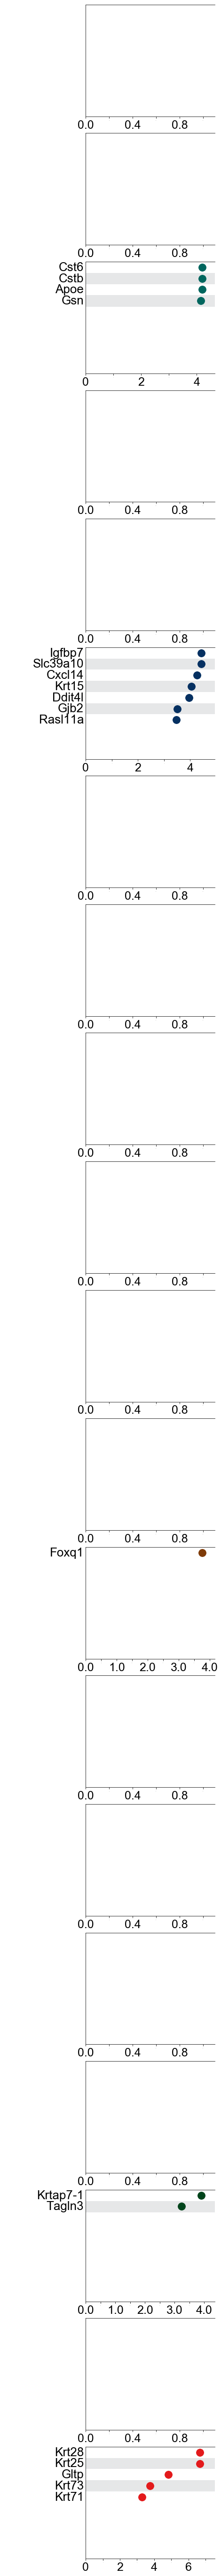

In [301]:
#define input variables

gr_order = return_unique(cl_c_ANA)
genes = MWU_gr_ANA_genes
L = len(genes.index)
pval = MWU_gr_ANA
cmap = cmap_2nd

#initialize figure

height = 5 * len(gr_order)
width = 8

plt.figure(facecolor = 'w', figsize = (width, height))
gs = plt.GridSpec(len(gr_order), 2, hspace = 0.15, wspace = 0.0, width_ratios = [5,8])

#iterate through groups

for pos, gr in enumerate(gr_order):
    
    genes_tmp = [gene for gene in genes[gr].values if gene != 'None']
    
    #create gene name axis 
    
    ax0 = plt.subplot(gs[pos,0])
    ax0.set_ylim(L - 0.5, -0.5)
    clean_axis(ax0)
    
    #create violin plot axis
    
    ax1 = plt.subplot(gs[pos,1])
    
    ax1.spines['right'].set_color('none')

    ax1.set_ylim(L - 0.5, -0.5)
    ax1.yaxis.set_ticks_position('left')
    ax1.yaxis.set_ticks([])
    
    #iterate over genes
    
    for ix, g in enumerate(genes_tmp):
        ax0.text(0.975, ix, g, family = 'Arial', fontsize = 26, ha = 'right', va = 'center')
        
        #print background
        
        if ix % 2 == 0:
            ax1.axhspan(ix - 0.5, ix + 0.5, color = '#FFFFFF', zorder = 0)
            
        if ix % 2 == 1:
            ax1.axhspan(ix - 0.5, ix + 0.5, color = '#E6E7E8', zorder = 0)
            
        #print pvals
        
        ax1.scatter(pval.loc[g,gr], ix, marker = 'o', s = 250, color = cmap[gr])
        
    xlim = list(ax1.get_xlim())

    ax1.set_xlim(0, xlim[1] * 1.1)

    for ix, t in enumerate(ax1.xaxis.get_ticklabels()):
        if ix % 2 == 0:
            t.set_family('Arial')
            t.set_fontsize(25)
        else:
            t.set_fontsize(0)

# Differentially expressed genes - IRS  subclustering

In [302]:
MWU_av_ANA_IRS[MWU_av_ANA_IRS==np.inf] = 307

In [303]:
MWU_av_ANA_IRS_bin = MWU_get_binarized(MWU_av_ANA_IRS, -np.log10(0.001), neglog = True)

In [304]:
MWU_av_ANA_IRS_genes = MWU_extract_genes_(MWU_av_ANA_IRS, MWU_av_ANA_IRS_bin, number = 10, neglog = True)

In [305]:
cl_c_ANA_IRS = AP_groups_reorder_v2(cl_c_ANA_IRS, ['ANA - IRS - 3',
                                                   'ANA - IRS - 4',
                                                   'ANA - IRS - 1',
                                                   'ANA - IRS - 2',
                                                   'ANA - IRS - 0'])

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


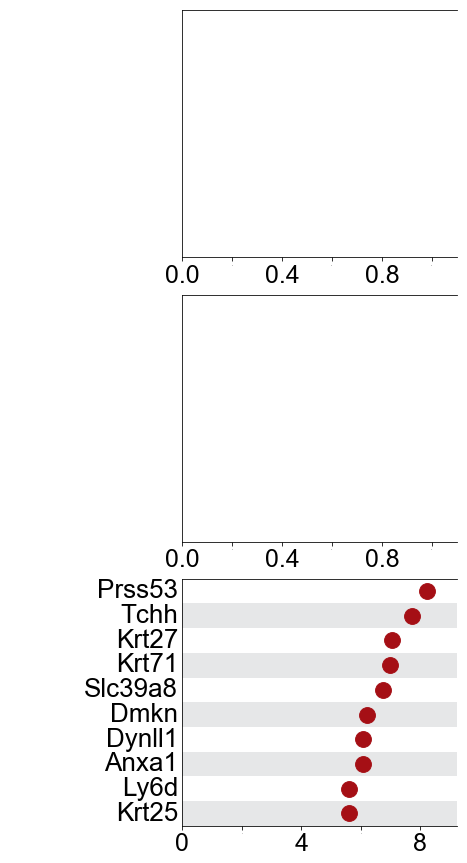

In [306]:
#define input variables

gr_order = return_unique(cl_c_ANA_IRS)[:3]
genes = MWU_av_ANA_IRS_genes
L = len(genes.index)
pval = MWU_av_ANA_IRS
cmap = cmap_2nd

#initialize figure

height = 5 * len(gr_order)
width = 8

plt.figure(facecolor = 'w', figsize = (width, height))
gs = plt.GridSpec(len(gr_order), 2, hspace = 0.15, wspace = 0.0, width_ratios = [5,8])

#iterate through groups

for pos, gr in enumerate(gr_order):
    
    genes_tmp = [gene for gene in genes[gr].values if gene != 'None']
    
    #create gene name axis 
    
    ax0 = plt.subplot(gs[pos,0])
    ax0.set_ylim(L - 0.5, -0.5)
    clean_axis(ax0)
    
    #create violin plot axis
    
    ax1 = plt.subplot(gs[pos,1])
    
    ax1.spines['right'].set_color('none')

    ax1.set_ylim(L - 0.5, -0.5)
    ax1.yaxis.set_ticks_position('left')
    ax1.yaxis.set_ticks([])
    
    #iterate over genes
    
    for ix, g in enumerate(genes_tmp):
        ax0.text(0.975, ix, g, family = 'Arial', fontsize = 26, ha = 'right', va = 'center')
        
        #print background
        
        if ix % 2 == 0:
            ax1.axhspan(ix - 0.5, ix + 0.5, color = '#FFFFFF', zorder = 0)
            
        if ix % 2 == 1:
            ax1.axhspan(ix - 0.5, ix + 0.5, color = '#E6E7E8', zorder = 0)
            
        #print pvals
        
        ax1.scatter(pval.loc[g,gr], ix, marker = 'o', s = 250, color = cmap[gr])
        
    xlim = list(ax1.get_xlim())

    ax1.set_xlim(0, xlim[1] * 1.1)

    for ix, t in enumerate(ax1.xaxis.get_ticklabels()):
        if ix % 2 == 0:
            t.set_family('Arial')
            t.set_fontsize(25)
        else:
            t.set_fontsize(0)
            
figname = 'v1.5_FigS4_MWU_vs_av_ANA_IRS_1.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


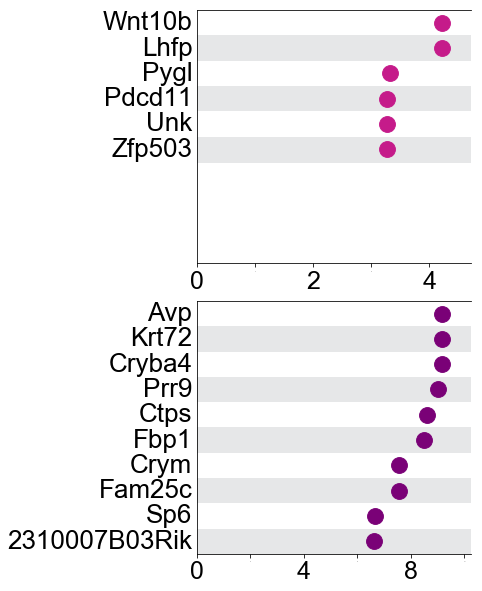

In [307]:
#define input variables

gr_order = return_unique(cl_c_ANA_IRS)[3:]
genes = MWU_av_ANA_IRS_genes
L = len(genes.index)
pval = MWU_av_ANA_IRS
cmap = cmap_2nd

#initialize figure

height = 5 * len(gr_order)
width = 8

plt.figure(facecolor = 'w', figsize = (width, height))
gs = plt.GridSpec(len(gr_order), 2, hspace = 0.15, wspace = 0.0, width_ratios = [5,8])

#iterate through groups

for pos, gr in enumerate(gr_order):
    
    genes_tmp = [gene for gene in genes[gr].values if gene != 'None']
    
    #create gene name axis 
    
    ax0 = plt.subplot(gs[pos,0])
    ax0.set_ylim(L - 0.5, -0.5)
    clean_axis(ax0)
    
    #create violin plot axis
    
    ax1 = plt.subplot(gs[pos,1])
    
    ax1.spines['right'].set_color('none')

    ax1.set_ylim(L - 0.5, -0.5)
    ax1.yaxis.set_ticks_position('left')
    ax1.yaxis.set_ticks([])
    
    #iterate over genes
    
    for ix, g in enumerate(genes_tmp):
        ax0.text(0.975, ix, g, family = 'Arial', fontsize = 26, ha = 'right', va = 'center')
        
        #print background
        
        if ix % 2 == 0:
            ax1.axhspan(ix - 0.5, ix + 0.5, color = '#FFFFFF', zorder = 0)
            
        if ix % 2 == 1:
            ax1.axhspan(ix - 0.5, ix + 0.5, color = '#E6E7E8', zorder = 0)
            
        #print pvals
        
        ax1.scatter(pval.loc[g,gr], ix, marker = 'o', s = 250, color = cmap[gr])
        
    xlim = list(ax1.get_xlim())

    ax1.set_xlim(0, xlim[1] * 1.1)

    for ix, t in enumerate(ax1.xaxis.get_ticklabels()):
        if ix % 2 == 0:
            t.set_family('Arial')
            t.set_fontsize(25)
        else:
            t.set_fontsize(0)
            
figname = 'v1.5_FigS4_MWU_vs_av_ANA_IRS_2.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

# RNA velocity: model 0

In [414]:
path_input_vcy = '/Users/simjoo/Projects/10X_Skin/velocyto/data_input/v1.5/'
path_output_vcy = '/Users/simjoo/Projects/10X_Skin/velocyto/data_output/v1.5/'

In [415]:
vlm_ana0 = vcy.load_velocyto_hdf5(path_output_vcy + exp_id + '_vlm_ana0.hdf5')

In [417]:
S_model0 = pd.DataFrame(vlm_ana0.Sx, index = vlm_ana0.ra['Gene'], columns = vlm_ana0.ca['CellID']).astype(float)
S_model0.columns = ['%s-%s' % (c.split(':')[1][:-1], c.split(':')[0][:2]) for c in vlm_ana0.ca['CellID']]

U_model0 = pd.DataFrame(vlm_ana0.Ux, index = vlm_ana0.ra['Gene'], columns = vlm_ana0.ca['CellID']).astype(float)
U_model0.columns = ['%s-%s' % (c.split(':')[1][:-1], c.split(':')[0][:2]) for c in vlm_ana0.ca['CellID']]

gammas_model0 = pd.Series(vlm_ana0.gammas, index = vlm_ana0.ra['Gene'])
q_model0 = pd.Series(vlm_ana0.q, index = vlm_ana0.ra['Gene'])

## Plot phase diagram

In [1]:
"""
for gene in ['Mt2','Dcn']:
    
    c_sel = cl_c_ANA[cl_c_ANA.isin(['ANA - 0','ANA - 1','ANA - 2','ANA - 3','ANA - 20','ANA - 21',])].index
    c_other = cl_c_ANA[~cl_c_ANA.isin(['ANA - 0','ANA - 1','ANA - 2','ANA - 3','ANA - 20','ANA - 21',])].index
    data_S = S_model0.loc[gene]
    data_U = U_model0.loc[gene]
    gamma = gammas_model0[gene]
    q = q_model0[gene]
    groups = cl_c_ANA
    cmap = cmap_2nd

    #initialize figure

    height = 10
    width = 10

    fig = plt.figure(facecolor = 'w', figsize = (width, height))

    ax = plt.subplot(111)

    #set axes

    ax.set_xlim(0, np.max(data_S) * 1.1)
    ax.set_xlabel('Spliced', family = 'Arial', fontsize = 40)
    for ix, t in enumerate(ax.xaxis.get_ticklabels()):
        t.set_family('Arial')
        t.set_fontsize(25)

    ax.set_ylim(0, np.max(data_U) * 1.1)
    ax.set_ylabel('Unspliced', family = 'Arial', fontsize = 40)
    for ix, t in enumerate(ax.yaxis.get_ticklabels()):
        t.set_family('Arial')
        t.set_fontsize(25)
        
    #plot not selected data

    ax.scatter(data_S[c_other], data_U[c_other], c = ['silver' for c in c_other], s = 100)
    xnew = np.linspace(0, ax.get_xlim()[1])
    ax.plot(xnew, gamma * xnew + q, c='k', lw = 2)
    ax.axvspan(ax.get_xlim()[0], ax.get_xlim()[1], color = 'white', zorder=0)

    #plot selected data

    ax.scatter(data_S[c_sel], data_U[c_sel], c = [cmap[groups[c]] for c in c_sel], s = 150)
    xnew = np.linspace(0, ax.get_xlim()[1])
    ax.plot(xnew, gamma * xnew + q, c='k', lw = 2)
    ax.axvspan(ax.get_xlim()[0], ax.get_xlim()[1], color = 'white', zorder=0)

    
    figname = 'v1.5_Fig4_phase_vlm_model0_%s.pdf' % gene
    plt.savefig('%s/%s' % (path_figures, figname), 
                format = 'pdf', 
                transparent = True, 
                bbox_inches = 'tight', 
                pad_inches = 0, 
                rasterized = True)
"""

"\nfor gene in ['Mt2','Dcn']:\n    \n    c_sel = cl_c_ANA[cl_c_ANA.isin(['ANA - 0','ANA - 1','ANA - 2','ANA - 3','ANA - 20','ANA - 21',])].index\n    c_other = cl_c_ANA[~cl_c_ANA.isin(['ANA - 0','ANA - 1','ANA - 2','ANA - 3','ANA - 20','ANA - 21',])].index\n    data_S = S_model0.loc[gene]\n    data_U = U_model0.loc[gene]\n    gamma = gammas_model0[gene]\n    q = q_model0[gene]\n    groups = cl_c_ANA\n    cmap = cmap_2nd\n\n    #initialize figure\n\n    height = 10\n    width = 10\n\n    fig = plt.figure(facecolor = 'w', figsize = (width, height))\n\n    ax = plt.subplot(111)\n\n    #set axes\n\n    ax.set_xlim(0, np.max(data_S) * 1.1)\n    ax.set_xlabel('Spliced', family = 'Arial', fontsize = 40)\n    for ix, t in enumerate(ax.xaxis.get_ticklabels()):\n        t.set_family('Arial')\n        t.set_fontsize(25)\n\n    ax.set_ylim(0, np.max(data_U) * 1.1)\n    ax.set_ylabel('Unspliced', family = 'Arial', fontsize = 40)\n    for ix, t in enumerate(ax.yaxis.get_ticklabels()):\n        t.set

## Plot expression as color

In [2]:
"""
for g in ['Mt2','Dcn']:
    
    data_full = S_model0.loc[g].fillna(0)
    c_sel = cl_c_ANA.index
    data = S_model0.loc[g, c_sel].fillna(0)
    tsne = umap_ANA.loc[data.index]
    cmap = plt.cm.viridis
    time = cells_stage
    markers = markers_time
    vmin = 0
    vmax = np.percentile(data_full, 99)

    #initialize figure

    height = 17
    width = 17

    fig = plt.figure(facecolor = 'w', figsize = (width, height))

    #define x- and y-limits

    x_min, x_max = np.min(tsne['x']), np.max(tsne['x'])
    y_min, y_max = np.min(tsne['y']), np.max(tsne['y'])
    x_diff, y_diff = x_max - x_min, y_max - y_min
    x_cent, y_cent = x_min + 0.5 * x_diff, y_min + 0.5 * y_diff,

    pad = 2.0

    if x_diff > y_diff:
        xlim = (x_min - pad, x_max + pad)
        ylim = (y_cent - 0.5 * x_diff - pad, y_cent + 0.5 * x_diff + pad,)

    if x_diff < y_diff:
        xlim = (x_cent - 0.5 * y_diff - pad, x_cent + 0.5 * y_diff + pad,)
        ylim = (y_min - pad, y_max + pad)

    text_pad = 2

    #draw groups

    ax1 = plt.subplot()

    ax1.set_xlim(xlim[0], xlim[1])
    ax1.set_ylim(ylim[0], ylim[1])

    for ix in tsne.index:

        ax1.scatter(tsne.ix[ix,'x'],
                    tsne.ix[ix,'y'], 
                    s = 250,
                    linewidth = 0.5,
                    c = cmap((data[ix] - vmin) / (vmax - vmin)),
                    edgecolor=cmap((data[ix] - vmin) / (vmax - vmin)), 
                    marker = markers[time[ix]])

    clean_axis(ax1)
    
    figname = 'v1.5_FigS4_vel_expr_model0_%s.pdf' % g
    plt.savefig('%s/%s' % (path_figures, figname), 
                format = 'pdf', 
                transparent = True, 
                bbox_inches = 'tight', 
                pad_inches = 0, 
                rasterized = True)
"""

"\nfor g in ['Mt2','Dcn']:\n    \n    data_full = S_model0.loc[g].fillna(0)\n    c_sel = cl_c_ANA.index\n    data = S_model0.loc[g, c_sel].fillna(0)\n    tsne = umap_ANA.loc[data.index]\n    cmap = plt.cm.viridis\n    time = cells_stage\n    markers = markers_time\n    vmin = 0\n    vmax = np.percentile(data_full, 99)\n\n    #initialize figure\n\n    height = 17\n    width = 17\n\n    fig = plt.figure(facecolor = 'w', figsize = (width, height))\n\n    #define x- and y-limits\n\n    x_min, x_max = np.min(tsne['x']), np.max(tsne['x'])\n    y_min, y_max = np.min(tsne['y']), np.max(tsne['y'])\n    x_diff, y_diff = x_max - x_min, y_max - y_min\n    x_cent, y_cent = x_min + 0.5 * x_diff, y_min + 0.5 * y_diff,\n\n    pad = 2.0\n\n    if x_diff > y_diff:\n        xlim = (x_min - pad, x_max + pad)\n        ylim = (y_cent - 0.5 * x_diff - pad, y_cent + 0.5 * x_diff + pad,)\n\n    if x_diff < y_diff:\n        xlim = (x_cent - 0.5 * y_diff - pad, x_cent + 0.5 * y_diff + pad,)\n        ylim = (y_mi

## Plot velocity as color

In [433]:
vel0 = pd.DataFrame(vlm_ana0.Sx_t - vlm_ana0.Sx, index = vlm_ana0.ra['Gene'], columns = vlm_ana0.ca['CellID'])
vel0.columns = ['%s-%s' % (c.split(':')[1][:-1], c.split(':')[0][:2]) for c in vlm_ana0.ca['CellID']]

In [3]:
"""
for g in ['Mt2','Dcn']:
    
    data_full = vel0.loc[g]
    c_sel = cl_c_ANA.index
    data = vel0.loc[g,c_sel]
    tsne = umap_ANA.ix[data.index]
    cmap = plt.cm.RdBu_r
    time = cells_stage
    markers = markers_time
    vmin = -np.max(np.abs(np.percentile(data_full, [1, 99])))
    vmax = np.max(np.abs(np.percentile(data_full, [1, 99])))

    #initialize figure

    height = 17
    width = 17

    fig = plt.figure(facecolor = 'w', figsize = (width, height))

    #define x- and y-limits

    x_min, x_max = np.min(tsne['x']), np.max(tsne['x'])
    y_min, y_max = np.min(tsne['y']), np.max(tsne['y'])
    x_diff, y_diff = x_max - x_min, y_max - y_min
    x_cent, y_cent = x_min + 0.5 * x_diff, y_min + 0.5 * y_diff,

    pad = 2.0

    if x_diff > y_diff:
        xlim = (x_min - pad, x_max + pad)
        ylim = (y_cent - 0.5 * x_diff - pad, y_cent + 0.5 * x_diff + pad,)

    if x_diff < y_diff:
        xlim = (x_cent - 0.5 * y_diff - pad, x_cent + 0.5 * y_diff + pad,)
        ylim = (y_min - pad, y_max + pad)

    text_pad = 2

    #draw groups

    ax1 = plt.subplot()

    ax1.set_xlim(xlim[0], xlim[1])
    ax1.set_ylim(ylim[0], ylim[1])

    remove_ticks(ax1)

    for ix in tsne.index:

        ax1.scatter(tsne.ix[ix,'x'],
                    tsne.ix[ix,'y'], 
                    s = 250,
                    linewidth = 0.5,
                    c = cmap((data[ix] - vmin) / (vmax - vmin)),
                    edgecolor=cmap((data[ix] - vmin) / (vmax - vmin)), 
                    marker = markers[time[ix]])

    clean_axis(ax1)
    
    figname = 'v1.5_Fig4_vel_vlm_model0_%s.pdf' % g
    plt.savefig('%s/%s' % (path_figures, figname), 
                format = 'pdf', 
                transparent = True, 
                bbox_inches = 'tight', 
                pad_inches = 0, 
                rasterized = True)
"""

"\nfor g in ['Mt2','Dcn']:\n    \n    data_full = vel0.loc[g]\n    c_sel = cl_c_ANA.index\n    data = vel0.loc[g,c_sel]\n    tsne = umap_ANA.ix[data.index]\n    cmap = plt.cm.RdBu_r\n    time = cells_stage\n    markers = markers_time\n    vmin = -np.max(np.abs(np.percentile(data_full, [1, 99])))\n    vmax = np.max(np.abs(np.percentile(data_full, [1, 99])))\n\n    #initialize figure\n\n    height = 17\n    width = 17\n\n    fig = plt.figure(facecolor = 'w', figsize = (width, height))\n\n    #define x- and y-limits\n\n    x_min, x_max = np.min(tsne['x']), np.max(tsne['x'])\n    y_min, y_max = np.min(tsne['y']), np.max(tsne['y'])\n    x_diff, y_diff = x_max - x_min, y_max - y_min\n    x_cent, y_cent = x_min + 0.5 * x_diff, y_min + 0.5 * y_diff,\n\n    pad = 2.0\n\n    if x_diff > y_diff:\n        xlim = (x_min - pad, x_max + pad)\n        ylim = (y_cent - 0.5 * x_diff - pad, y_cent + 0.5 * x_diff + pad,)\n\n    if x_diff < y_diff:\n        xlim = (x_cent - 0.5 * y_diff - pad, x_cent + 0.5